In [1]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import iminuit
import probfit
import probfit.pdf

In [2]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = ( rawEnergy + preshowerEnergy )/genEnergy", inplace=True)
    else:
        df.eval("target = rawEnergy/genEnergy", inplace=True)

    return df


In [3]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=1500000,isEE=isEE)



Entries in ntuple:
3428975
(3428975, 30)


In [4]:
DF=DF.query('pt>20')

#  Parameter

train-effrms-mean


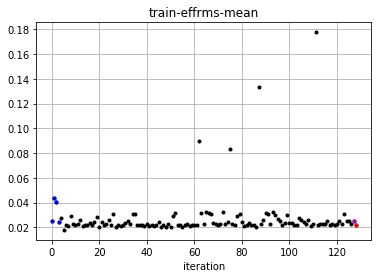

0.003395200000000001


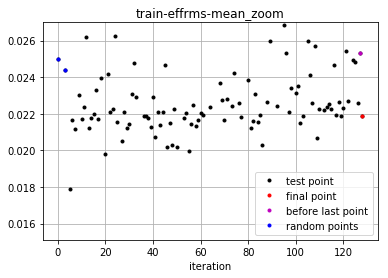

train-effrms-std


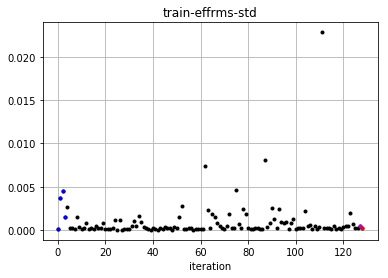

0.0002578865120540988


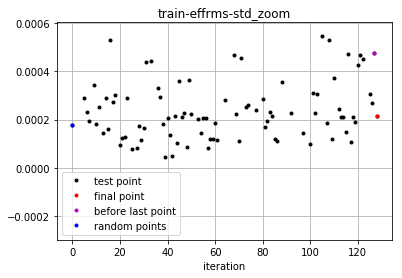

test-effrms-mean


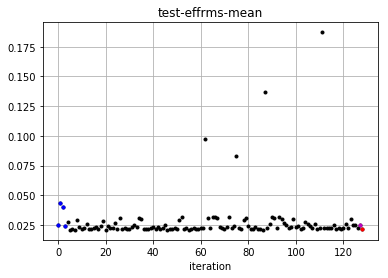

0.003423599999999999


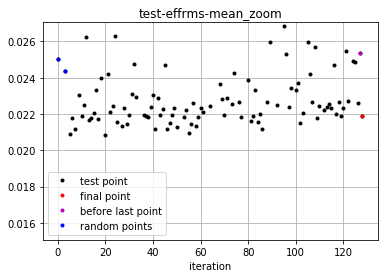

test-effrms-std


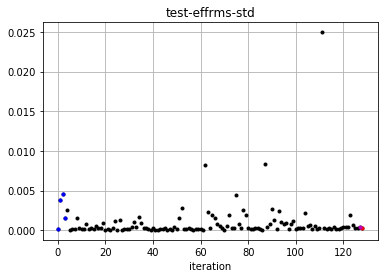

0.00022743910638109723


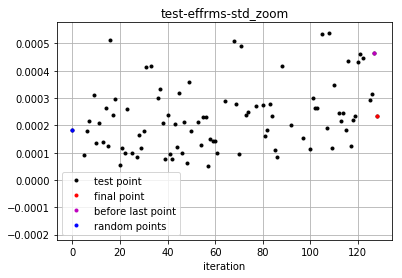

min_child_weight


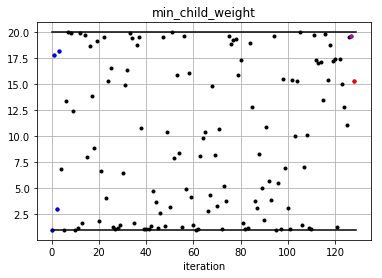

4.410299711670021


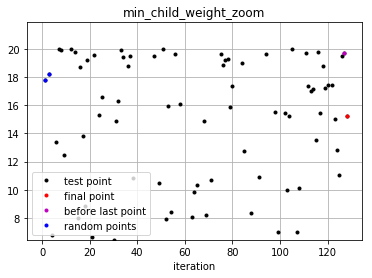

colsample_bytree


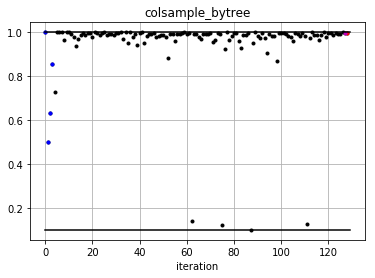

0.0012110228076791518


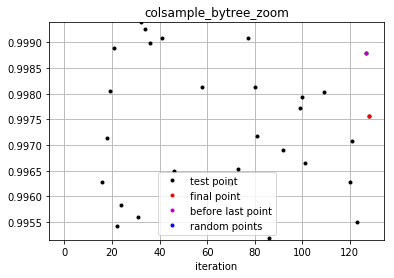

max_depth


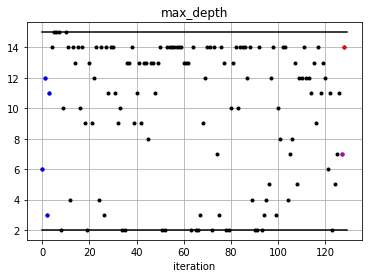

7


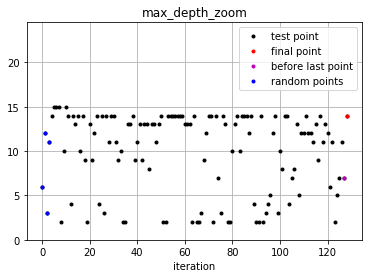

gamma


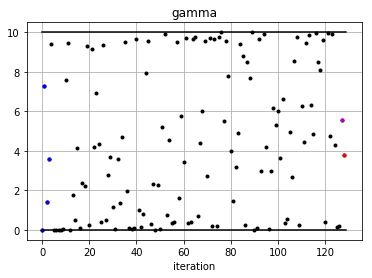

1.7989554150779798


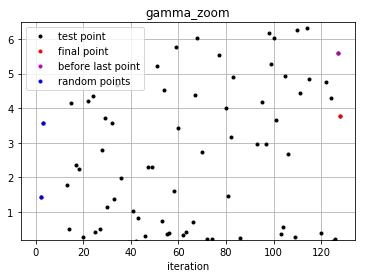

reg_lambda


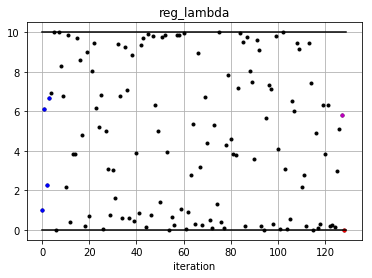

5.8238515827322805


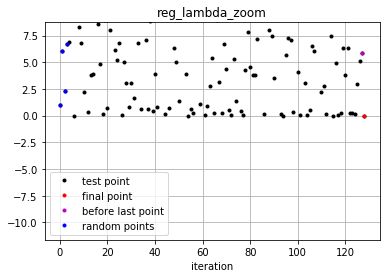

n_estimators


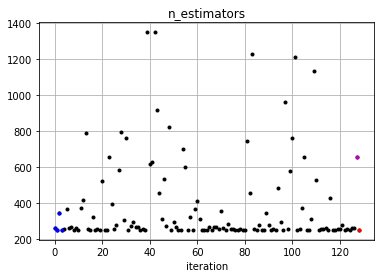

403


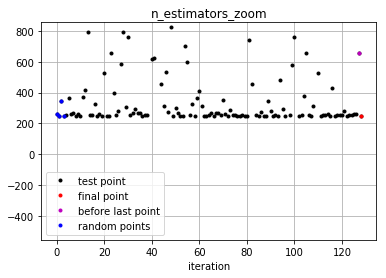

callback


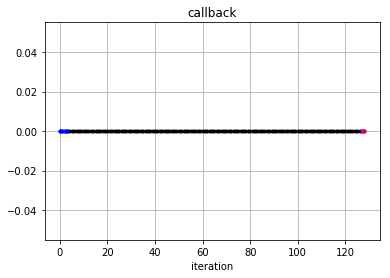

0


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


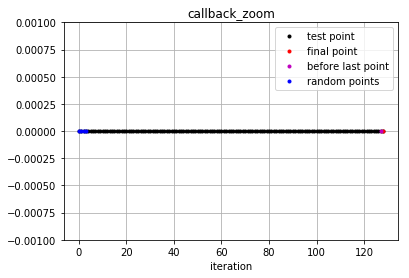

In [8]:
out_dir='/work/okiss/SemesterProject_2/xgbo/Energy_Regression_test/'
parameter=pd.read_csv(out_dir+'Electron_perfectIC-lowpt-EB_test2019049/summary.csv')
rangemax=np.array([20,1,15,10,10])
rangemin=np.array([1,0.1,2,0,0])
i=0
j=0
for para in parameter.columns:
    if i==0:
        para0=para
    else:
        print para
        plt.figure()
        plt.plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.plot(parameter[para0].iloc[:4],parameter[para].iloc[:4],'b.',label='random points')  
        plt.title(para)
        plt.xlabel('iteration')
        plt.grid()
        
        
        if 4<i<10:
            one =np.linspace(0,np.size(parameter[para0]),1000)
            plt.plot(one,np.ones_like(one)*rangemax[j],'k-',label='maximal range')
            plt.plot(one,np.ones_like(one)*rangemin[j],'k-',label='minimal range')
            j+=1
        #plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution'+'.png'))
        plt.show()
        plt.figure()
        plt.plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.plot(parameter[para0].iloc[:4],parameter[para].iloc[:4],'b.',label='random points') 
        plt.title(para+'_zoom')
        plt.xlabel('iteration')
        plt.grid()
        zoom=(parameter[para].iloc[-1]-parameter[para].iloc[-2])
        zoom=abs(zoom)
        plt.ylim(parameter[para].iloc[-1]-2*zoom,parameter[para].iloc[-1]+1.5*zoom)
        print(zoom)
        plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution_zoom'+'.png'))
        plt.show()
        
    i+=1

#  Data

Entries in ntuple:
3428975
(3428975, 30)


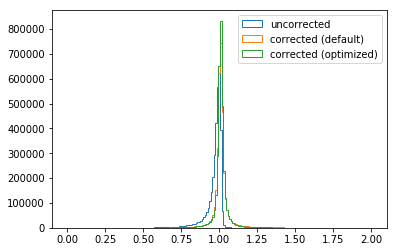

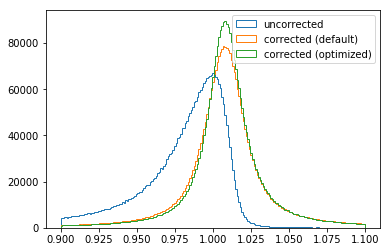

In [6]:
df_test  = load_data(file_name, isEE=isEE, entrystop=1500000)
X_test  = df_test[features_EB]
y_test  = df_test["target"]
xgtest  = xgb.DMatrix(X_test , label=y_test)

xgbo_default = xgb.Booster({'nthread':4}) #init model
#xgbo_default.load_model("Photon_perfectIC-highpt-EB/model_default/model.bin") # load data
xgbo_default.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_default/model.bin")
xgbo_bo = xgb.Booster({'nthread':4}) #init model
#xgbo_bo.load_model("Photon_perfectIC-highpt-EB/model_optimized/model.bin") # load data
xgbo_bo.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_optimized/model.bin") # load data

preds_default = xgbo_default.predict(xgtest)
preds_bo      = xgbo_bo.predict(xgtest)

# preds = 1.

# Etrue / Eraw after applying corrections
z_default = preds_default / (df_test['genEnergy']/df_test['rawEnergy'])
z_bo      = preds_bo / (df_test['genEnergy']/df_test['rawEnergy'])

bins = np.linspace(0.0, 2.0, 200)
bins_zoom = np.linspace(0.9, 1.1, 200)

plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison'+'.png'))
plt.show()


plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins_zoom, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins_zoom, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins_zoom, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison_zoom'+'.png'))
plt.show()

In [7]:
data=pd.DataFrame()
data['eta']=df_test['eta']
data['pt']=df_test['pt']
data['target']=df_test['target']
data['z_default']=z_default
data['z_bo']=z_bo
print(data.columns)

Index([u'eta', u'pt', u'target', u'z_default', u'z_bo'], dtype='object')


# ETA

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


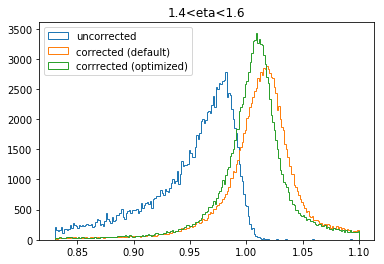

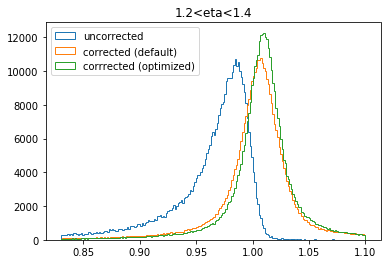

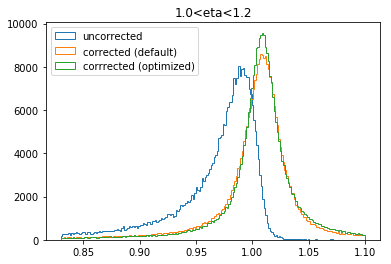

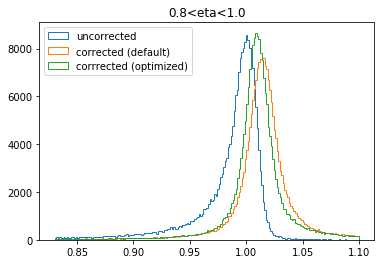

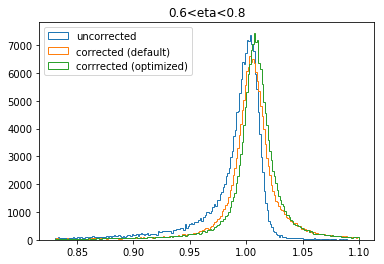

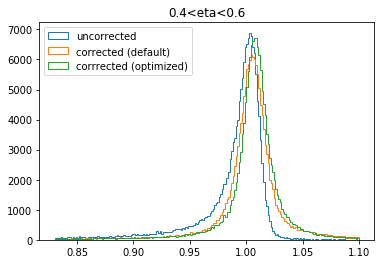

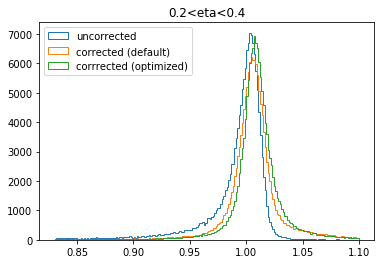

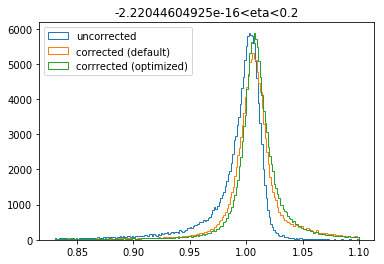

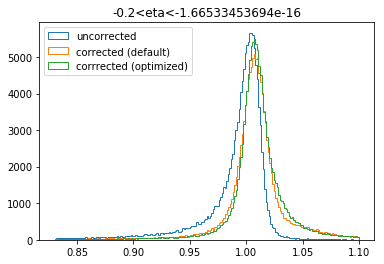

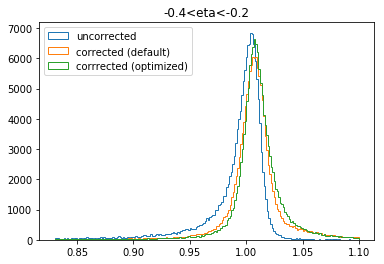

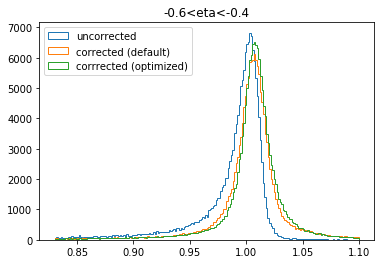

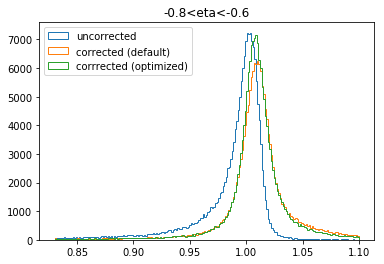

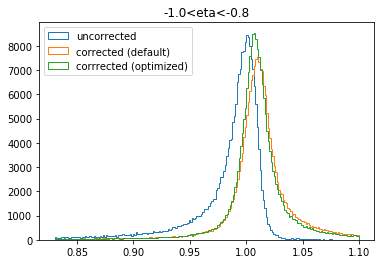

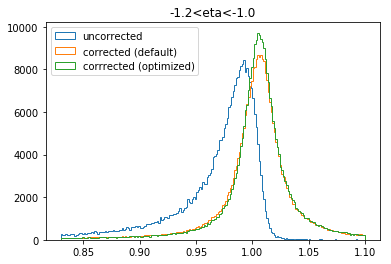

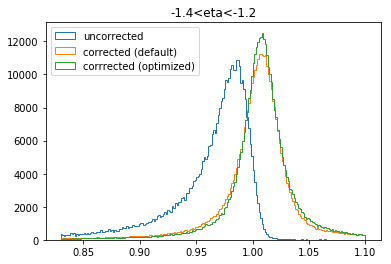

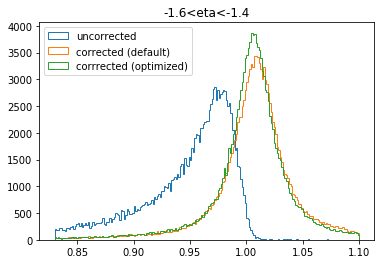

In [9]:
n=16
feat=[]
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for para in feat:
    rmin = 0.83
    rmax = 1.1
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_eta_'+para+'.png'))
    
    plt.show()
    #plt.ylim([0,500])
    
    #surface_hist=sum(out[0][:]*np.diff(out[1][:]))
   
   
    
   

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.16490895094725533)


FCN = 1607.48249084 
 TOTAL NCALL = 642 
 NCALLS = 631 
 
 
 EDM = 515.437557492 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.704734 
 0.0103725 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.66778 
 0.849489 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00095 
 0.0147956 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.797311 
 2.15944 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.976231 
 0.00014482 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0129217 
 9.83668e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.704734 & 0.0103725 & & & & & No\\
\hline
1 & alpha2 & 3.66778 & 0.849489 & & & & & No\\
\hline
2 & n & 1.00095 & 0.0147956 & & & & & No\\
\hline
3 & n2 & 0.797311 & 2.15944 & & & & & No\\
\hline
4 & mean & 0.976231 & 0.00014482 & & & & & No\\
\hline
5 & $\sigma$ & 0.0129217 & 9.83668e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 455.976113773 
 TOTAL NCALL = 474 
 NCALLS = 474 
 
 
 EDM = 3.41715580127e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.3019 
 0.00607943 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.33413 
 0.107079 
 
 
 
 
 No 
 
 
 2 
 n 
 4.22204 
 0.21907 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.11817 
 0.261795 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.979772 
 0.000154435 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110765 
 9.33125e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.3019 & 0.00607943 & & & & & No\\
\hline
1 & alpha2 & 3.33413 & 0.107079 & & & & & No\\
\hline
2 & n & 4.22204 & 0.21907 & & & & & No\\
\hline
3 & n2 & 1.11817 & 0.261795 & & & & & No\\
\hline
4 & mean & 0.979772 & 0.000154435 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110765 & 9.33125e-05 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


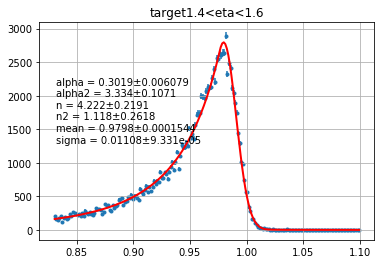

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.24321510851954653)


FCN = 988.58125984 
 TOTAL NCALL = 563 
 NCALLS = 563 
 
 
 EDM = 7.07239864601e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.434549 
 0.0041853 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.69801 
 0.0277352 
 
 
 
 
 No 
 
 
 2 
 n 
 4.3264 
 0.0843486 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8898 
 0.0983075 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.98497 
 7.21954e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108784 
 4.75851e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.434549 & 0.0041853 & & & & & No\\
\hline
1 & alpha2 & 2.69801 & 0.0277352 & & & & & No\\
\hline
2 & n & 4.3264 & 0.0843486 & & & & & No\\
\hline
3 & n2 & 1.8898 & 0.0983075 & & & & & No\\
\hline
4 & mean & 0.98497 & 7.21954e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108784 & 4.75851e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 988.58125984 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 6.8322777153e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.434549 
 0.003845 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.69801 
 0.0274743 
 
 
 
 
 No 
 
 
 2 
 n 
 4.3264 
 0.0830902 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8898 
 0.0981482 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.98497 
 6.26961e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108784 
 4.07592e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.434549 & 0.003845 & & & & & No\\
\hline
1 & alpha2 & 2.69801 & 0.0274743 & & & & & No\\
\hline
2 & n & 4.3264 & 0.0830902 & & & & & No\\
\hline
3 & n2 & 1.8898 & 0.0981482 & & & & & No\\
\hline
4 & mean & 0.98497 & 6.26961e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108784 & 4.07592e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


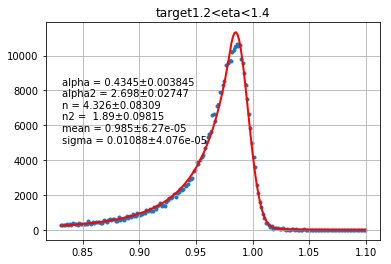

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2508812262104189)


FCN = 826.052828865 
 TOTAL NCALL = 506 
 NCALLS = 506 
 
 
 EDM = 2.13582428903e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.458526 
 0.00522788 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.5575 
 0.0312875 
 
 
 
 
 No 
 
 
 2 
 n 
 3.1629 
 0.0555111 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.13645 
 0.120371 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.990685 
 8.31005e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108149 
 5.68263e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.458526 & 0.00522788 & & & & & No\\
\hline
1 & alpha2 & 2.5575 & 0.0312875 & & & & & No\\
\hline
2 & n & 3.1629 & 0.0555111 & & & & & No\\
\hline
3 & n2 & 2.13645 & 0.120371 & & & & & No\\
\hline
4 & mean & 0.990685 & 8.31005e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108149 & 5.68263e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 826.052828865 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 2.09962847884e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.458526 
 0.00486301 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.5575 
 0.0309567 
 
 
 
 
 No 
 
 
 2 
 n 
 3.1629 
 0.0547514 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.13645 
 0.120205 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.990685 
 7.3468e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108149 
 4.96624e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.458526 & 0.00486301 & & & & & No\\
\hline
1 & alpha2 & 2.5575 & 0.0309567 & & & & & No\\
\hline
2 & n & 3.1629 & 0.0547514 & & & & & No\\
\hline
3 & n2 & 2.13645 & 0.120205 & & & & & No\\
\hline
4 & mean & 0.990685 & 7.3468e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108149 & 4.96624e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


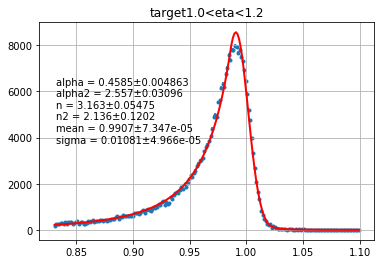

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2998140074742366)


FCN = 455.207551453 
 TOTAL NCALL = 403 
 NCALLS = 403 
 
 
 EDM = 2.373232435e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.708529 
 0.00705173 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28246 
 0.0250515 
 
 
 
 
 No 
 
 
 2 
 n 
 2.45406 
 0.0291132 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.90547 
 0.0773627 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999645 
 5.25986e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00876777 
 4.3247e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.708529 & 0.00705173 & & & & & No\\
\hline
1 & alpha2 & 2.28246 & 0.0250515 & & & & & No\\
\hline
2 & n & 2.45406 & 0.0291132 & & & & & No\\
\hline
3 & n2 & 1.90547 & 0.0773627 & & & & & No\\
\hline
4 & mean & 0.999645 & 5.25986e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00876777 & 4.3247e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 455.207551453 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 2.17759976055e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.708529 
 0.00681532 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28246 
 0.0247048 
 
 
 
 
 No 
 
 
 2 
 n 
 2.45406 
 0.0289336 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.90547 
 0.0769957 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999645 
 4.96787e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00876777 
 4.02878e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.708529 & 0.00681532 & & & & & No\\
\hline
1 & alpha2 & 2.28246 & 0.0247048 & & & & & No\\
\hline
2 & n & 2.45406 & 0.0289336 & & & & & No\\
\hline
3 & n2 & 1.90547 & 0.0769957 & & & & & No\\
\hline
4 & mean & 0.999645 & 4.96787e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00876777 & 4.02878e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


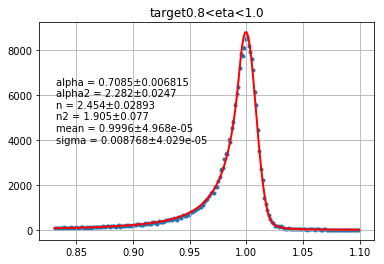

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2916827309593097)


FCN = 422.66453186 
 TOTAL NCALL = 443 
 NCALLS = 443 
 
 
 EDM = 1.07857465007e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.771797 
 0.00849588 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.18316 
 0.0254886 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22522 
 0.0275718 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8402 
 0.0734704 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00196 
 5.47904e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00854904 
 4.79385e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.771797 & 0.00849588 & & & & & No\\
\hline
1 & alpha2 & 2.18316 & 0.0254886 & & & & & No\\
\hline
2 & n & 2.22522 & 0.0275718 & & & & & No\\
\hline
3 & n2 & 1.8402 & 0.0734704 & & & & & No\\
\hline
4 & mean & 1.00196 & 5.47904e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00854904 & 4.79385e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 422.664525587 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 4.51207402862e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.771796 
 0.008495 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.18316 
 0.0254873 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22522 
 0.0275701 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8402 
 0.0734678 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00196 
 5.47837e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00854912 
 4.79328e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.771796 & 0.008495 & & & & & No\\
\hline
1 & alpha2 & 2.18316 & 0.0254873 & & & & & No\\
\hline
2 & n & 2.22522 & 0.0275701 & & & & & No\\
\hline
3 & n2 & 1.8402 & 0.0734678 & & & & & No\\
\hline
4 & mean & 1.00196 & 5.47837e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00854912 & 4.79328e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


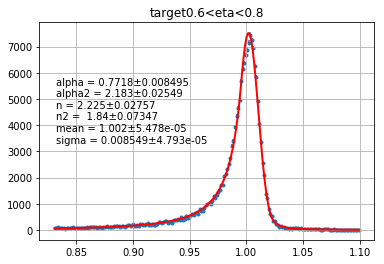

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.28468061980259907)


FCN = 425.692546357 
 TOTAL NCALL = 428 
 NCALLS = 428 
 
 
 EDM = 2.17821942369e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.793553 
 0.00867573 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.36423 
 0.0271778 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14026 
 0.0263436 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.50583 
 0.0683125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00229 
 5.45338e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0084132 
 4.49413e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.793553 & 0.00867573 & & & & & No\\
\hline
1 & alpha2 & 2.36423 & 0.0271778 & & & & & No\\
\hline
2 & n & 2.14026 & 0.0263436 & & & & & No\\
\hline
3 & n2 & 1.50583 & 0.0683125 & & & & & No\\
\hline
4 & mean & 1.00229 & 5.45338e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0084132 & 4.49413e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 425.692546357 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 2.17951701481e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.793553 
 0.00842562 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.36423 
 0.0269061 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14026 
 0.0261608 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.50583 
 0.0680447 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00229 
 5.18903e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0084132 
 4.23041e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.793553 & 0.00842562 & & & & & No\\
\hline
1 & alpha2 & 2.36423 & 0.0269061 & & & & & No\\
\hline
2 & n & 2.14026 & 0.0261608 & & & & & No\\
\hline
3 & n2 & 1.50583 & 0.0680447 & & & & & No\\
\hline
4 & mean & 1.00229 & 5.18903e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0084132 & 4.23041e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


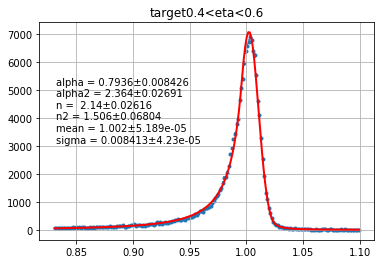

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2893156794372116)


FCN = 336.789712632 
 TOTAL NCALL = 428 
 NCALLS = 428 
 
 
 EDM = 4.83950251851e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.79064 
 0.00906321 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21943 
 0.027253 
 
 
 
 
 No 
 
 
 2 
 n 
 2.5666 
 0.0346959 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.88254 
 0.0797916 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00329 
 5.38159e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00806577 
 4.68377e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.79064 & 0.00906321 & & & & & No\\
\hline
1 & alpha2 & 2.21943 & 0.027253 & & & & & No\\
\hline
2 & n & 2.5666 & 0.0346959 & & & & & No\\
\hline
3 & n2 & 1.88254 & 0.0797916 & & & & & No\\
\hline
4 & mean & 1.00329 & 5.38159e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00806577 & 4.68377e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 336.789710078 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 2.28614216786e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.790639 
 0.00906242 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21943 
 0.0272521 
 
 
 
 
 No 
 
 
 2 
 n 
 2.5666 
 0.0346942 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.88254 
 0.0797896 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00329 
 5.38101e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00806582 
 4.68328e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.790639 & 0.00906242 & & & & & No\\
\hline
1 & alpha2 & 2.21943 & 0.0272521 & & & & & No\\
\hline
2 & n & 2.5666 & 0.0346942 & & & & & No\\
\hline
3 & n2 & 1.88254 & 0.0797896 & & & & & No\\
\hline
4 & mean & 1.00329 & 5.38101e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00806582 & 4.68328e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


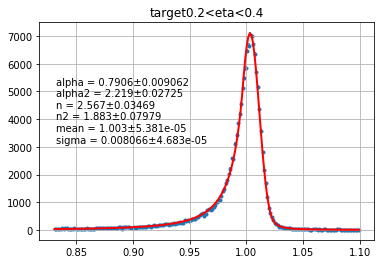

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.26658779132822147)


FCN = 299.359485822 
 TOTAL NCALL = 399 
 NCALLS = 399 
 
 
 EDM = 2.50945999657e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76103 
 0.00921756 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11892 
 0.0263984 
 
 
 
 
 No 
 
 
 2 
 n 
 2.57251 
 0.0368002 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96882 
 0.0813987 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00317 
 5.89235e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00823758 
 5.17658e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76103 & 0.00921756 & & & & & No\\
\hline
1 & alpha2 & 2.11892 & 0.0263984 & & & & & No\\
\hline
2 & n & 2.57251 & 0.0368002 & & & & & No\\
\hline
3 & n2 & 1.96882 & 0.0813987 & & & & & No\\
\hline
4 & mean & 1.00317 & 5.89235e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00823758 & 5.17658e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 299.359485822 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 2.34038434852e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76103 
 0.00893911 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11892 
 0.0260829 
 
 
 
 
 No 
 
 
 2 
 n 
 2.57251 
 0.0365826 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96882 
 0.0811243 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00317 
 5.62751e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00823758 
 4.88127e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76103 & 0.00893911 & & & & & No\\
\hline
1 & alpha2 & 2.11892 & 0.0260829 & & & & & No\\
\hline
2 & n & 2.57251 & 0.0365826 & & & & & No\\
\hline
3 & n2 & 1.96882 & 0.0811243 & & & & & No\\
\hline
4 & mean & 1.00317 & 5.62751e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00823758 & 4.88127e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


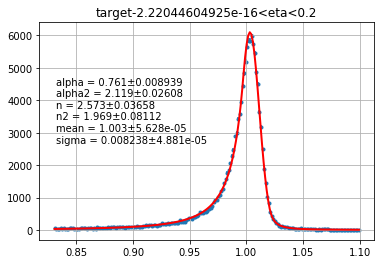

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.26211473305231314)


FCN = 284.818343128 
 TOTAL NCALL = 438 
 NCALLS = 438 
 
 
 EDM = 2.19083993611e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.808188 
 0.0100379 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21101 
 0.0281407 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33329 
 0.0336235 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.69677 
 0.0756312 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00287 
 6.04833e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00851052 
 5.31409e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.808188 & 0.0100379 & & & & & No\\
\hline
1 & alpha2 & 2.21101 & 0.0281407 & & & & & No\\
\hline
2 & n & 2.33329 & 0.0336235 & & & & & No\\
\hline
3 & n2 & 1.69677 & 0.0756312 & & & & & No\\
\hline
4 & mean & 1.00287 & 6.04833e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00851052 & 5.31409e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 284.818343128 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 2.20392539718e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.808188 
 0.00976056 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21101 
 0.0278177 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33329 
 0.0333918 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.69677 
 0.0753135 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00287 
 5.79698e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00851052 
 5.03786e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.808188 & 0.00976056 & & & & & No\\
\hline
1 & alpha2 & 2.21101 & 0.0278177 & & & & & No\\
\hline
2 & n & 2.33329 & 0.0333918 & & & & & No\\
\hline
3 & n2 & 1.69677 & 0.0753135 & & & & & No\\
\hline
4 & mean & 1.00287 & 5.79698e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00851052 & 5.03786e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


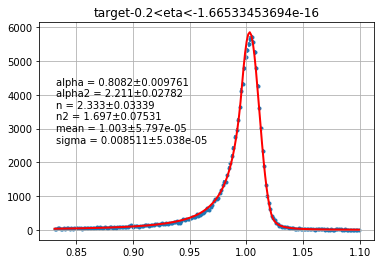

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2863839837439828)


FCN = 395.91884199 
 TOTAL NCALL = 426 
 NCALLS = 426 
 
 
 EDM = 6.95955562346e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.794631 
 0.00921482 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.1836 
 0.0275954 
 
 
 
 
 No 
 
 
 2 
 n 
 2.49128 
 0.0335547 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99177 
 0.0851422 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00332 
 5.4188e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00805484 
 4.76611e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.794631 & 0.00921482 & & & & & No\\
\hline
1 & alpha2 & 2.1836 & 0.0275954 & & & & & No\\
\hline
2 & n & 2.49128 & 0.0335547 & & & & & No\\
\hline
3 & n2 & 1.99177 & 0.0851422 & & & & & No\\
\hline
4 & mean & 1.00332 & 5.4188e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00805484 & 4.76611e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 395.918797865 
 TOTAL NCALL = 114 
 NCALLS = 114 
 
 
 EDM = 2.54465891576e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.794629 
 0.00921463 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.18355 
 0.0275852 
 
 
 
 
 No 
 
 
 2 
 n 
 2.49129 
 0.0335541 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99157 
 0.0850939 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00332 
 5.4188e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00805489 
 4.76616e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.794629 & 0.00921463 & & & & & No\\
\hline
1 & alpha2 & 2.18355 & 0.0275852 & & & & & No\\
\hline
2 & n & 2.49129 & 0.0335541 & & & & & No\\
\hline
3 & n2 & 1.99157 & 0.0850939 & & & & & No\\
\hline
4 & mean & 1.00332 & 5.4188e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00805489 & 4.76616e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


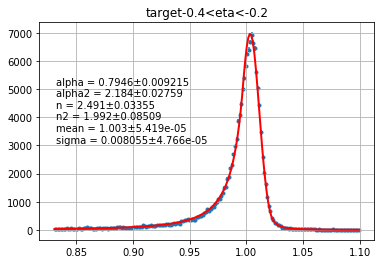

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2801640015507789)


FCN = 446.336898506 
 TOTAL NCALL = 454 
 NCALLS = 454 
 
 
 EDM = 1.99012110672e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.759177 
 0.00889281 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.25406 
 0.0294999 
 
 
 
 
 No 
 
 
 2 
 n 
 2.123 
 0.0265665 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.80855 
 0.0826082 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00227 
 5.89674e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00838782 
 5.1021e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.759177 & 0.00889281 & & & & & No\\
\hline
1 & alpha2 & 2.25406 & 0.0294999 & & & & & No\\
\hline
2 & n & 2.123 & 0.0265665 & & & & & No\\
\hline
3 & n2 & 1.80855 & 0.0826082 & & & & & No\\
\hline
4 & mean & 1.00227 & 5.89674e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00838782 & 5.1021e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 446.336898506 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 1.98570868274e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.759177 
 0.00853703 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.25406 
 0.0291008 
 
 
 
 
 No 
 
 
 2 
 n 
 2.123 
 0.0262789 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.80855 
 0.0822457 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00227 
 5.52649e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00838782 
 4.73423e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.759177 & 0.00853703 & & & & & No\\
\hline
1 & alpha2 & 2.25406 & 0.0291008 & & & & & No\\
\hline
2 & n & 2.123 & 0.0262789 & & & & & No\\
\hline
3 & n2 & 1.80855 & 0.0822457 & & & & & No\\
\hline
4 & mean & 1.00227 & 5.52649e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00838782 & 4.73423e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


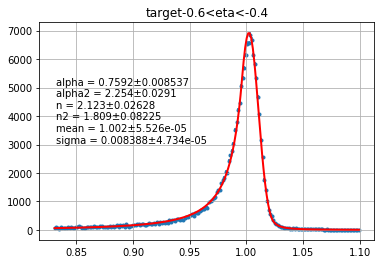

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2927257253045709)


FCN = 372.121950622 
 TOTAL NCALL = 448 
 NCALLS = 448 
 
 
 EDM = 4.64320005058e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.746118 
 0.00802077 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.16283 
 0.0241645 
 
 
 
 
 No 
 
 
 2 
 n 
 2.3242 
 0.0284154 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8547 
 0.0702725 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00239 
 5.34541e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00834682 
 4.63096e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.746118 & 0.00802077 & & & & & No\\
\hline
1 & alpha2 & 2.16283 & 0.0241645 & & & & & No\\
\hline
2 & n & 2.3242 & 0.0284154 & & & & & No\\
\hline
3 & n2 & 1.8547 & 0.0702725 & & & & & No\\
\hline
4 & mean & 1.00239 & 5.34541e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00834682 & 4.63096e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 372.121950586 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 4.60735436777e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.746118 
 0.0080203 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.16283 
 0.0241643 
 
 
 
 
 No 
 
 
 2 
 n 
 2.3242 
 0.0284149 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8547 
 0.0702722 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00239 
 5.34486e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00834683 
 4.63046e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.746118 & 0.0080203 & & & & & No\\
\hline
1 & alpha2 & 2.16283 & 0.0241643 & & & & & No\\
\hline
2 & n & 2.3242 & 0.0284149 & & & & & No\\
\hline
3 & n2 & 1.8547 & 0.0702722 & & & & & No\\
\hline
4 & mean & 1.00239 & 5.34486e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00834683 & 4.63046e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


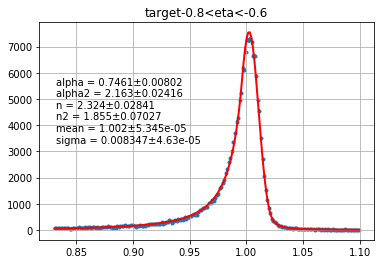

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2984394613511095)


FCN = 468.845887439 
 TOTAL NCALL = 444 
 NCALLS = 444 
 
 
 EDM = 9.35377115004e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.704469 
 0.00737788 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.27006 
 0.0260189 
 
 
 
 
 No 
 
 
 2 
 n 
 2.36106 
 0.0281396 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.87651 
 0.07737 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.9998 
 5.50425e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00868592 
 4.5749e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.704469 & 0.00737788 & & & & & No\\
\hline
1 & alpha2 & 2.27006 & 0.0260189 & & & & & No\\
\hline
2 & n & 2.36106 & 0.0281396 & & & & & No\\
\hline
3 & n2 & 1.87651 & 0.07737 & & & & & No\\
\hline
4 & mean & 0.9998 & 5.50425e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00868592 & 4.5749e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 468.845887435 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 9.31177885118e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.704469 
 0.00737718 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.27006 
 0.0260186 
 
 
 
 
 No 
 
 
 2 
 n 
 2.36106 
 0.0281387 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.87651 
 0.0773697 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.9998 
 5.50339e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00868592 
 4.57416e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.704469 & 0.00737718 & & & & & No\\
\hline
1 & alpha2 & 2.27006 & 0.0260186 & & & & & No\\
\hline
2 & n & 2.36106 & 0.0281387 & & & & & No\\
\hline
3 & n2 & 1.87651 & 0.0773697 & & & & & No\\
\hline
4 & mean & 0.9998 & 5.50339e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00868592 & 4.57416e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


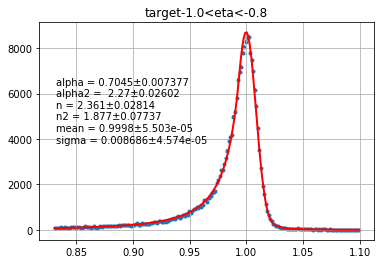

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2579197734504536)


FCN = 795.053673719 
 TOTAL NCALL = 528 
 NCALLS = 528 
 
 
 EDM = 3.64653231864e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.450062 
 0.00501147 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.63564 
 0.0310466 
 
 
 
 
 No 
 
 
 2 
 n 
 3.20237 
 0.0537224 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67263 
 0.094161 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991977 
 7.94211e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103047 
 5.38282e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.450062 & 0.00501147 & & & & & No\\
\hline
1 & alpha2 & 2.63564 & 0.0310466 & & & & & No\\
\hline
2 & n & 3.20237 & 0.0537224 & & & & & No\\
\hline
3 & n2 & 1.67263 & 0.094161 & & & & & No\\
\hline
4 & mean & 0.991977 & 7.94211e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103047 & 5.38282e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 795.053673501 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 3.62464794464e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.450062 
 0.00501041 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.63564 
 0.0310459 
 
 
 
 
 No 
 
 
 2 
 n 
 3.20237 
 0.0537182 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67262 
 0.0941599 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991977 
 7.9397e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103047 
 5.38117e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.450062 & 0.00501041 & & & & & No\\
\hline
1 & alpha2 & 2.63564 & 0.0310459 & & & & & No\\
\hline
2 & n & 3.20237 & 0.0537182 & & & & & No\\
\hline
3 & n2 & 1.67262 & 0.0941599 & & & & & No\\
\hline
4 & mean & 0.991977 & 7.9397e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103047 & 5.38117e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


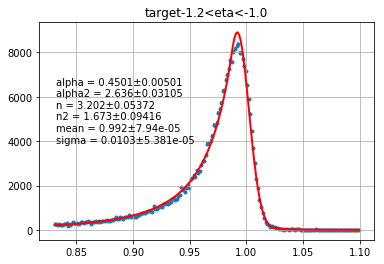

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.24514295889811588)


FCN = 1007.29565002 
 TOTAL NCALL = 596 
 NCALLS = 596 
 
 
 EDM = 5.51185003987e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.439935 
 0.0041965 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.74064 
 0.0282401 
 
 
 
 
 No 
 
 
 2 
 n 
 4.29012 
 0.0833124 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.7597 
 0.0947504 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984617 
 7.16512e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110334 
 4.7066e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.439935 & 0.0041965 & & & & & No\\
\hline
1 & alpha2 & 2.74064 & 0.0282401 & & & & & No\\
\hline
2 & n & 4.29012 & 0.0833124 & & & & & No\\
\hline
3 & n2 & 1.7597 & 0.0947504 & & & & & No\\
\hline
4 & mean & 0.984617 & 7.16512e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110334 & 4.7066e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1007.29565002 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 5.41213613904e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.439935 
 0.00387728 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.74064 
 0.0280291 
 
 
 
 
 No 
 
 
 2 
 n 
 4.29012 
 0.0822099 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.7597 
 0.0946321 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984617 
 6.26227e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110334 
 4.05809e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.439935 & 0.00387728 & & & & & No\\
\hline
1 & alpha2 & 2.74064 & 0.0280291 & & & & & No\\
\hline
2 & n & 4.29012 & 0.0822099 & & & & & No\\
\hline
3 & n2 & 1.7597 & 0.0946321 & & & & & No\\
\hline
4 & mean & 0.984617 & 6.26227e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110334 & 4.05809e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


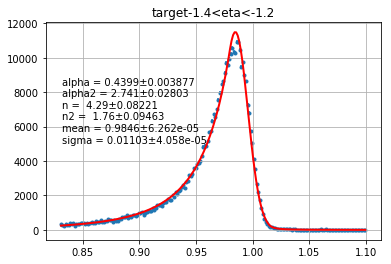

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.18117226847988124)


FCN = 610.60628094 
 TOTAL NCALL = 1009 
 NCALLS = 1009 
 
 
 EDM = 1.61060482713e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.288638 
 0.00584908 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.16722 
 0.0776178 
 
 
 
 
 No 
 
 
 2 
 n 
 4.82701 
 0.277514 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.23661 
 0.208216 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.978751 
 0.000162072 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111582 
 9.60815e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.288638 & 0.00584908 & & & & & No\\
\hline
1 & alpha2 & 3.16722 & 0.0776178 & & & & & No\\
\hline
2 & n & 4.82701 & 0.277514 & & & & & No\\
\hline
3 & n2 & 1.23661 & 0.208216 & & & & & No\\
\hline
4 & mean & 0.978751 & 0.000162072 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111582 & 9.60815e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 610.60628094 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 1.52640457024e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.288638 
 0.00541226 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.16722 
 0.0773169 
 
 
 
 
 No 
 
 
 2 
 n 
 4.82701 
 0.274602 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.23661 
 0.207893 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.978751 
 0.000140124 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111582 
 8.20516e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.288638 & 0.00541226 & & & & & No\\
\hline
1 & alpha2 & 3.16722 & 0.0773169 & & & & & No\\
\hline
2 & n & 4.82701 & 0.274602 & & & & & No\\
\hline
3 & n2 & 1.23661 & 0.207893 & & & & & No\\
\hline
4 & mean & 0.978751 & 0.000140124 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111582 & 8.20516e-05 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


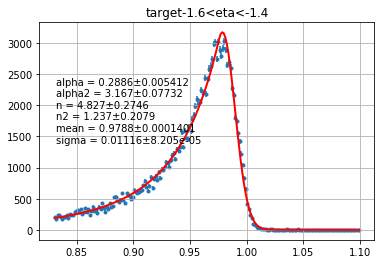

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.295600079627098)


FCN = 195.824969592 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 1.10552561802e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08347 
 0.0175669 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46172 
 0.0167103 
 
 
 
 
 No 
 
 
 2 
 n 
 3.23307 
 0.111315 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.32567 
 0.0334505 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0156 
 9.75967e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0183131 
 0.000134217 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08347 & 0.0175669 & & & & & No\\
\hline
1 & alpha2 & 1.46172 & 0.0167103 & & & & & No\\
\hline
2 & n & 3.23307 & 0.111315 & & & & & No\\
\hline
3 & n2 & 1.32567 & 0.0334505 & & & & & No\\
\hline
4 & mean & 1.0156 & 9.75967e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0183131 & 0.000134217 & & & & & No\\
\hline
\end{tabular}

FCN = 195.824969592 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 1.08670540508e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08347 
 0.0174521 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46172 
 0.0166314 
 
 
 
 
 No 
 
 
 2 
 n 
 3.23307 
 0.111244 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.32567 
 0.0333929 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0156 
 9.72767e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0183131 
 0.000132349 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08347 & 0.0174521 & & & & & No\\
\hline
1 & alpha2 & 1.46172 & 0.0166314 & & & & & No\\
\hline
2 & n & 3.23307 & 0.111244 & & & & & No\\
\hline
3 & n2 & 1.32567 & 0.0333929 & & & & & No\\
\hline
4 & mean & 1.0156 & 9.72767e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0183131 & 0.000132349 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


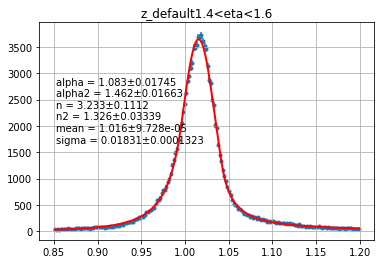

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.48048342343351397)


FCN = 304.838582768 
 TOTAL NCALL = 430 
 NCALLS = 430 
 
 
 EDM = 3.2097736776e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23994 
 0.00942744 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46282 
 0.00946959 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14849 
 0.0323909 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.51044 
 0.0194034 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.25125e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0159254 
 5.93444e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23994 & 0.00942744 & & & & & No\\
\hline
1 & alpha2 & 1.46282 & 0.00946959 & & & & & No\\
\hline
2 & n & 2.14849 & 0.0323909 & & & & & No\\
\hline
3 & n2 & 1.51044 & 0.0194034 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.25125e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0159254 & 5.93444e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 304.838576768 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 2.60944314955e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23994 
 0.00942651 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46282 
 0.00946913 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14848 
 0.0323885 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.51044 
 0.0194029 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.25119e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0159255 
 5.9339e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23994 & 0.00942651 & & & & & No\\
\hline
1 & alpha2 & 1.46282 & 0.00946913 & & & & & No\\
\hline
2 & n & 2.14848 & 0.0323885 & & & & & No\\
\hline
3 & n2 & 1.51044 & 0.0194029 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.25119e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0159255 & 5.9339e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


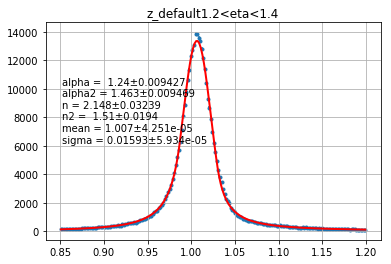

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.43546425985038756)


FCN = 279.29088438 
 TOTAL NCALL = 410 
 NCALLS = 410 
 
 
 EDM = 1.85801630073e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18488 
 0.0102755 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38922 
 0.0107041 
 
 
 
 
 No 
 
 
 2 
 n 
 1.8541 
 0.0279272 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71212 
 0.0237236 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 4.76417e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0148094 
 7.08564e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18488 & 0.0102755 & & & & & No\\
\hline
1 & alpha2 & 1.38922 & 0.0107041 & & & & & No\\
\hline
2 & n & 1.8541 & 0.0279272 & & & & & No\\
\hline
3 & n2 & 1.71212 & 0.0237236 & & & & & No\\
\hline
4 & mean & 1.00881 & 4.76417e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0148094 & 7.08564e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 279.290880632 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 1.4830563094e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18488 
 0.0102747 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38922 
 0.0107034 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85411 
 0.0279262 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71213 
 0.023723 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 4.76411e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0148095 
 7.08487e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18488 & 0.0102747 & & & & & No\\
\hline
1 & alpha2 & 1.38922 & 0.0107034 & & & & & No\\
\hline
2 & n & 1.85411 & 0.0279262 & & & & & No\\
\hline
3 & n2 & 1.71213 & 0.023723 & & & & & No\\
\hline
4 & mean & 1.00881 & 4.76411e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0148095 & 7.08487e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


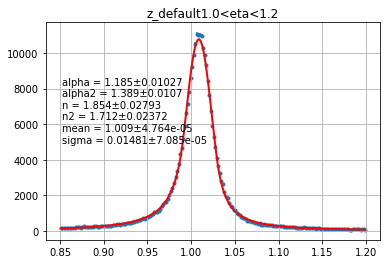

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.42960459971118536)


FCN = 268.047198631 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 7.13538436166e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.43071 
 0.0128451 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25311 
 0.0107664 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86309 
 0.0305268 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.95147 
 0.0263239 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01419 
 4.24489e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0117784 
 6.07376e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.43071 & 0.0128451 & & & & & No\\
\hline
1 & alpha2 & 1.25311 & 0.0107664 & & & & & No\\
\hline
2 & n & 1.86309 & 0.0305268 & & & & & No\\
\hline
3 & n2 & 1.95147 & 0.0263239 & & & & & No\\
\hline
4 & mean & 1.01419 & 4.24489e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0117784 & 6.07376e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 268.04714568 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 1.84120400973e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.43073 
 0.0128461 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25311 
 0.0107668 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86315 
 0.0305319 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.95154 
 0.0263272 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01419 
 4.24493e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0117787 
 6.07363e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.43073 & 0.0128461 & & & & & No\\
\hline
1 & alpha2 & 1.25311 & 0.0107668 & & & & & No\\
\hline
2 & n & 1.86315 & 0.0305319 & & & & & No\\
\hline
3 & n2 & 1.95154 & 0.0263272 & & & & & No\\
\hline
4 & mean & 1.01419 & 4.24493e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0117787 & 6.07363e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


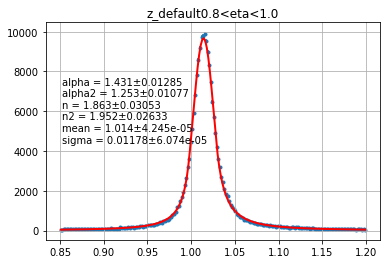

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3380187254471097)


FCN = 230.898740662 
 TOTAL NCALL = 421 
 NCALLS = 421 
 
 
 EDM = 4.31945105392e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33144 
 0.0137299 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1628 
 0.0108758 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94234 
 0.0337422 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.21662 
 0.0304979 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00488 
 4.53128e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109273 
 6.6951e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33144 & 0.0137299 & & & & & No\\
\hline
1 & alpha2 & 1.1628 & 0.0108758 & & & & & No\\
\hline
2 & n & 1.94234 & 0.0337422 & & & & & No\\
\hline
3 & n2 & 2.21662 & 0.0304979 & & & & & No\\
\hline
4 & mean & 1.00488 & 4.53128e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109273 & 6.6951e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 230.898720093 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 2.26225816283e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33143 
 0.0137272 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1628 
 0.0108757 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94232 
 0.0337365 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.21664 
 0.0305 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00488 
 4.53127e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109274 
 6.6942e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33143 & 0.0137272 & & & & & No\\
\hline
1 & alpha2 & 1.1628 & 0.0108757 & & & & & No\\
\hline
2 & n & 1.94232 & 0.0337365 & & & & & No\\
\hline
3 & n2 & 2.21664 & 0.0305 & & & & & No\\
\hline
4 & mean & 1.00488 & 4.53127e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109274 & 6.6942e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


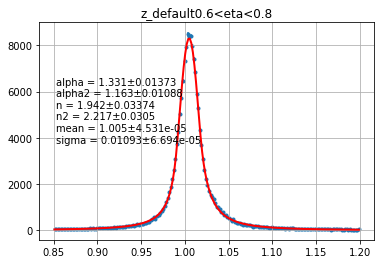

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32197869313769306)


FCN = 224.04251538 
 TOTAL NCALL = 408 
 NCALLS = 408 
 
 
 EDM = 1.29597254472e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35642 
 0.0139498 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.36825 
 0.0122511 
 
 
 
 
 No 
 
 
 2 
 n 
 1.79972 
 0.0320175 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.82312 
 0.0270924 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00494 
 4.50355e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110106 
 6.19651e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35642 & 0.0139498 & & & & & No\\
\hline
1 & alpha2 & 1.36825 & 0.0122511 & & & & & No\\
\hline
2 & n & 1.79972 & 0.0320175 & & & & & No\\
\hline
3 & n2 & 1.82312 & 0.0270924 & & & & & No\\
\hline
4 & mean & 1.00494 & 4.50355e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110106 & 6.19651e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 224.04251538 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 1.26628112665e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35642 
 0.013817 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.36825 
 0.0121677 
 
 
 
 
 No 
 
 
 2 
 n 
 1.79972 
 0.0319072 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.82312 
 0.0270456 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00494 
 4.49956e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110106 
 6.09065e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35642 & 0.013817 & & & & & No\\
\hline
1 & alpha2 & 1.36825 & 0.0121677 & & & & & No\\
\hline
2 & n & 1.79972 & 0.0319072 & & & & & No\\
\hline
3 & n2 & 1.82312 & 0.0270456 & & & & & No\\
\hline
4 & mean & 1.00494 & 4.49956e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110106 & 6.09065e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


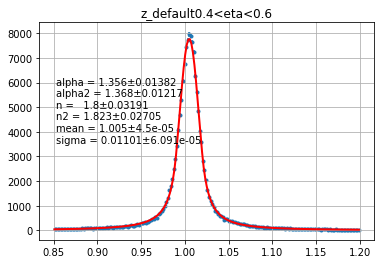

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3242467640648533)


FCN = 336.782165262 
 TOTAL NCALL = 420 
 NCALLS = 420 
 
 
 EDM = 2.82898824727e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38038 
 0.0157063 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.39606 
 0.0118349 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22242 
 0.044226 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66345 
 0.0235782 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00538 
 4.28794e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102464 
 5.76558e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38038 & 0.0157063 & & & & & No\\
\hline
1 & alpha2 & 1.39606 & 0.0118349 & & & & & No\\
\hline
2 & n & 2.22242 & 0.044226 & & & & & No\\
\hline
3 & n2 & 1.66345 & 0.0235782 & & & & & No\\
\hline
4 & mean & 1.00538 & 4.28794e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102464 & 5.76558e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 336.782156226 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 1.92514460487e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38038 
 0.0157037 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.39606 
 0.0118339 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22241 
 0.044221 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66345 
 0.0235775 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00538 
 4.28785e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102466 
 5.76462e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38038 & 0.0157037 & & & & & No\\
\hline
1 & alpha2 & 1.39606 & 0.0118339 & & & & & No\\
\hline
2 & n & 2.22241 & 0.044221 & & & & & No\\
\hline
3 & n2 & 1.66345 & 0.0235775 & & & & & No\\
\hline
4 & mean & 1.00538 & 4.28785e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102466 & 5.76462e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


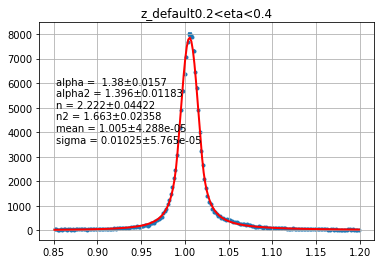

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.30513086002044976)


FCN = 332.774018685 
 TOTAL NCALL = 385 
 NCALLS = 385 
 
 
 EDM = 4.29897955819e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40946 
 0.0165669 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28765 
 0.0119186 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94209 
 0.0400851 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.6989 
 0.0246771 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00583 
 4.76207e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105519 
 6.5524e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40946 & 0.0165669 & & & & & No\\
\hline
1 & alpha2 & 1.28765 & 0.0119186 & & & & & No\\
\hline
2 & n & 1.94209 & 0.0400851 & & & & & No\\
\hline
3 & n2 & 1.6989 & 0.0246771 & & & & & No\\
\hline
4 & mean & 1.00583 & 4.76207e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105519 & 6.5524e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 332.774018651 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 4.26468077575e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40946 
 0.0165658 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28765 
 0.0119182 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94209 
 0.0400841 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.6989 
 0.0246769 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00583 
 4.76206e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105519 
 6.55166e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40946 & 0.0165658 & & & & & No\\
\hline
1 & alpha2 & 1.28765 & 0.0119182 & & & & & No\\
\hline
2 & n & 1.94209 & 0.0400841 & & & & & No\\
\hline
3 & n2 & 1.6989 & 0.0246769 & & & & & No\\
\hline
4 & mean & 1.00583 & 4.76206e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105519 & 6.55166e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


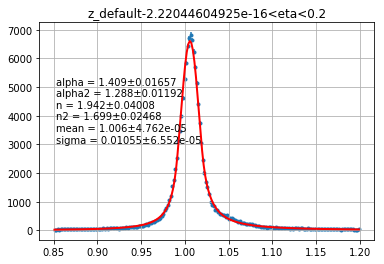

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3071397688920428)


FCN = 293.502268016 
 TOTAL NCALL = 383 
 NCALLS = 383 
 
 
 EDM = 2.40121268413e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41268 
 0.0162811 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28455 
 0.0124389 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87641 
 0.0380349 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.63862 
 0.024498 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.84268e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105412 
 6.67074e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41268 & 0.0162811 & & & & & No\\
\hline
1 & alpha2 & 1.28455 & 0.0124389 & & & & & No\\
\hline
2 & n & 1.87641 & 0.0380349 & & & & & No\\
\hline
3 & n2 & 1.63862 & 0.024498 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.84268e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105412 & 6.67074e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 293.502268016 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 2.39683141228e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41268 
 0.0161314 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28455 
 0.0123661 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87641 
 0.0379199 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.63862 
 0.0244654 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.84094e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105412 
 6.56254e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41268 & 0.0161314 & & & & & No\\
\hline
1 & alpha2 & 1.28455 & 0.0123661 & & & & & No\\
\hline
2 & n & 1.87641 & 0.0379199 & & & & & No\\
\hline
3 & n2 & 1.63862 & 0.0244654 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.84094e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105412 & 6.56254e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


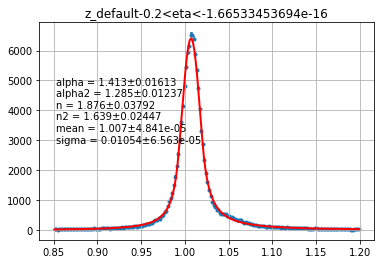

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32727944014850713)


FCN = 298.463348848 
 TOTAL NCALL = 403 
 NCALLS = 403 
 
 
 EDM = 3.53916824638e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37575 
 0.0154673 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37175 
 0.0120114 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1419 
 0.0415088 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67675 
 0.0238942 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00662 
 4.32353e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101812 
 5.90568e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37575 & 0.0154673 & & & & & No\\
\hline
1 & alpha2 & 1.37175 & 0.0120114 & & & & & No\\
\hline
2 & n & 2.1419 & 0.0415088 & & & & & No\\
\hline
3 & n2 & 1.67675 & 0.0238942 & & & & & No\\
\hline
4 & mean & 1.00662 & 4.32353e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101812 & 5.90568e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 298.463348848 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 3.43134954404e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37575 
 0.0152866 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37175 
 0.0119241 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1419 
 0.0413486 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67675 
 0.0238505 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00662 
 4.31821e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101812 
 5.78722e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37575 & 0.0152866 & & & & & No\\
\hline
1 & alpha2 & 1.37175 & 0.0119241 & & & & & No\\
\hline
2 & n & 2.1419 & 0.0413486 & & & & & No\\
\hline
3 & n2 & 1.67675 & 0.0238505 & & & & & No\\
\hline
4 & mean & 1.00662 & 4.31821e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101812 & 5.78722e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


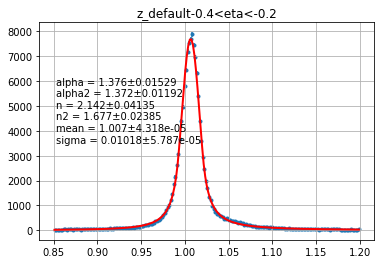

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32446046143689156)


FCN = 233.649390426 
 TOTAL NCALL = 406 
 NCALLS = 406 
 
 
 EDM = 1.22779497805e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26598 
 0.0135716 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37638 
 0.0124003 
 
 
 
 
 No 
 
 
 2 
 n 
 1.8689 
 0.0321115 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.7808 
 0.0264568 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0062 
 4.67904e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109328 
 6.5751e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26598 & 0.0135716 & & & & & No\\
\hline
1 & alpha2 & 1.37638 & 0.0124003 & & & & & No\\
\hline
2 & n & 1.8689 & 0.0321115 & & & & & No\\
\hline
3 & n2 & 1.7808 & 0.0264568 & & & & & No\\
\hline
4 & mean & 1.0062 & 4.67904e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109328 & 6.5751e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 233.649389221 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 1.10735582706e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26598 
 0.0135707 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37639 
 0.0123996 
 
 
 
 
 No 
 
 
 2 
 n 
 1.8689 
 0.0321109 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.78081 
 0.0264564 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0062 
 4.67898e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109328 
 6.57433e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26598 & 0.0135707 & & & & & No\\
\hline
1 & alpha2 & 1.37639 & 0.0123996 & & & & & No\\
\hline
2 & n & 1.8689 & 0.0321109 & & & & & No\\
\hline
3 & n2 & 1.78081 & 0.0264564 & & & & & No\\
\hline
4 & mean & 1.0062 & 4.67898e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109328 & 6.57433e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


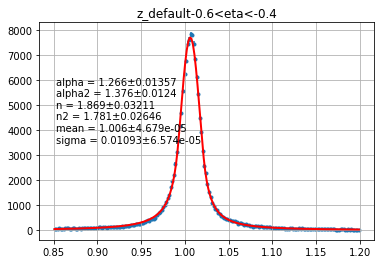

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.36114457509772385)


FCN = 297.933773357 
 TOTAL NCALL = 381 
 NCALLS = 381 
 
 
 EDM = 2.23988719555e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36262 
 0.0148218 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08372 
 0.0106009 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90298 
 0.034576 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99095 
 0.0269619 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 4.79349e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109659 
 7.18904e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36262 & 0.0148218 & & & & & No\\
\hline
1 & alpha2 & 1.08372 & 0.0106009 & & & & & No\\
\hline
2 & n & 1.90298 & 0.034576 & & & & & No\\
\hline
3 & n2 & 1.99095 & 0.0269619 & & & & & No\\
\hline
4 & mean & 1.00883 & 4.79349e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109659 & 7.18904e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 297.933773357 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 2.2349179401e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36262 
 0.0146391 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08372 
 0.0105176 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90298 
 0.0344388 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99095 
 0.0269431 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 4.79343e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109659 
 7.03551e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36262 & 0.0146391 & & & & & No\\
\hline
1 & alpha2 & 1.08372 & 0.0105176 & & & & & No\\
\hline
2 & n & 1.90298 & 0.0344388 & & & & & No\\
\hline
3 & n2 & 1.99095 & 0.0269431 & & & & & No\\
\hline
4 & mean & 1.00883 & 4.79343e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109659 & 7.03551e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


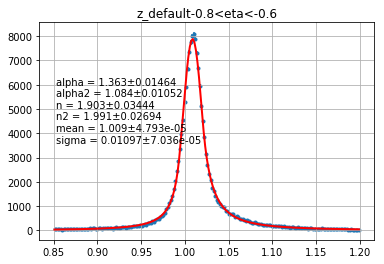

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4059587150426165)


FCN = 280.493273391 
 TOTAL NCALL = 405 
 NCALLS = 405 
 
 
 EDM = 7.99045577915e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.45997 
 0.0142092 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04058 
 0.00951099 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70646 
 0.0295704 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.11021 
 0.0264513 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00944 
 4.5212e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112598 
 6.70514e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.45997 & 0.0142092 & & & & & No\\
\hline
1 & alpha2 & 1.04058 & 0.00951099 & & & & & No\\
\hline
2 & n & 1.70646 & 0.0295704 & & & & & No\\
\hline
3 & n2 & 2.11021 & 0.0264513 & & & & & No\\
\hline
4 & mean & 1.00944 & 4.5212e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112598 & 6.70514e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 280.493272105 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 7.86101804386e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.45997 
 0.0142078 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04058 
 0.00951022 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70646 
 0.0295692 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.11021 
 0.0264505 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00944 
 4.52119e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112599 
 6.70414e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.45997 & 0.0142078 & & & & & No\\
\hline
1 & alpha2 & 1.04058 & 0.00951022 & & & & & No\\
\hline
2 & n & 1.70646 & 0.0295692 & & & & & No\\
\hline
3 & n2 & 2.11021 & 0.0264505 & & & & & No\\
\hline
4 & mean & 1.00944 & 4.52119e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112599 & 6.70414e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


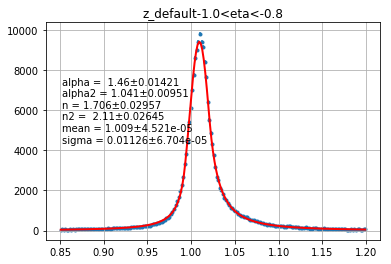

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4235355496412207)


FCN = 259.352020411 
 TOTAL NCALL = 438 
 NCALLS = 438 
 
 
 EDM = 8.43522580297e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21706 
 0.0110224 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19966 
 0.0096795 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95787 
 0.0306793 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98443 
 0.0251496 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00569 
 4.72952e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.014349 
 7.52573e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21706 & 0.0110224 & & & & & No\\
\hline
1 & alpha2 & 1.19966 & 0.0096795 & & & & & No\\
\hline
2 & n & 1.95787 & 0.0306793 & & & & & No\\
\hline
3 & n2 & 1.98443 & 0.0251496 & & & & & No\\
\hline
4 & mean & 1.00569 & 4.72952e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.014349 & 7.52573e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 259.352015867 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 3.89045244581e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21706 
 0.0110213 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19966 
 0.00967873 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95786 
 0.0306776 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98442 
 0.0251485 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00569 
 4.72949e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0143491 
 7.52483e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21706 & 0.0110213 & & & & & No\\
\hline
1 & alpha2 & 1.19966 & 0.00967873 & & & & & No\\
\hline
2 & n & 1.95786 & 0.0306776 & & & & & No\\
\hline
3 & n2 & 1.98442 & 0.0251485 & & & & & No\\
\hline
4 & mean & 1.00569 & 4.72949e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0143491 & 7.52483e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


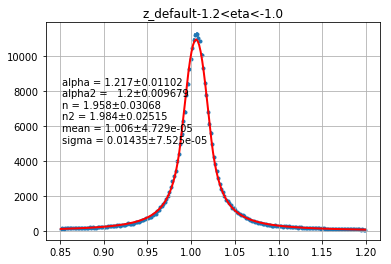

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.49344071715088655)


FCN = 238.811873743 
 TOTAL NCALL = 702 
 NCALLS = 702 
 
 
 EDM = 2.87368923062e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15819 
 0.00892784 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.53804 
 0.00911378 
 
 
 
 
 No 
 
 
 2 
 n 
 2.35601 
 0.0338834 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.37189 
 0.0168259 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00747 
 4.15918e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150673 
 5.61636e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15819 & 0.00892784 & & & & & No\\
\hline
1 & alpha2 & 1.53804 & 0.00911378 & & & & & No\\
\hline
2 & n & 2.35601 & 0.0338834 & & & & & No\\
\hline
3 & n2 & 1.37189 & 0.0168259 & & & & & No\\
\hline
4 & mean & 1.00747 & 4.15918e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150673 & 5.61636e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 238.811868119 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 2.31111575963e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15819 
 0.008927 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.53804 
 0.00911326 
 
 
 
 
 No 
 
 
 2 
 n 
 2.356 
 0.0338811 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.37188 
 0.0168254 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00747 
 4.15907e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150674 
 5.61579e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15819 & 0.008927 & & & & & No\\
\hline
1 & alpha2 & 1.53804 & 0.00911326 & & & & & No\\
\hline
2 & n & 2.356 & 0.0338811 & & & & & No\\
\hline
3 & n2 & 1.37188 & 0.0168254 & & & & & No\\
\hline
4 & mean & 1.00747 & 4.15907e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150674 & 5.61579e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


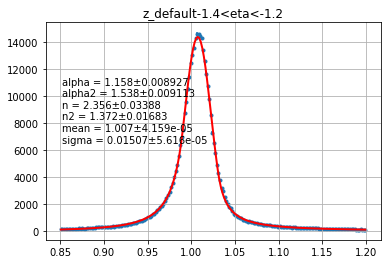

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2948693609241887)


FCN = 211.693054373 
 TOTAL NCALL = 374 
 NCALLS = 374 
 
 
 EDM = 1.22034397537e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.20518 
 0.018211 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18977 
 0.0151767 
 
 
 
 
 No 
 
 
 2 
 n 
 2.28803 
 0.0674907 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.97321 
 0.0433598 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00866 
 8.62861e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0179529 
 0.000142022 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.20518 & 0.018211 & & & & & No\\
\hline
1 & alpha2 & 1.18977 & 0.0151767 & & & & & No\\
\hline
2 & n & 2.28803 & 0.0674907 & & & & & No\\
\hline
3 & n2 & 1.97321 & 0.0433598 & & & & & No\\
\hline
4 & mean & 1.00866 & 8.62861e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0179529 & 0.000142022 & & & & & No\\
\hline
\end{tabular}

FCN = 211.693045872 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = 3.70313083119e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.20519 
 0.0182142 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18976 
 0.0151756 
 
 
 
 
 No 
 
 
 2 
 n 
 2.28808 
 0.0675085 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.97321 
 0.0433565 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00866 
 8.62877e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.017953 
 0.000142018 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.20519 & 0.0182142 & & & & & No\\
\hline
1 & alpha2 & 1.18976 & 0.0151756 & & & & & No\\
\hline
2 & n & 2.28808 & 0.0675085 & & & & & No\\
\hline
3 & n2 & 1.97321 & 0.0433565 & & & & & No\\
\hline
4 & mean & 1.00866 & 8.62877e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.017953 & 0.000142018 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


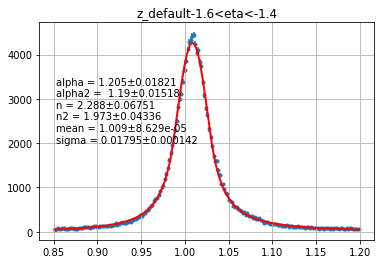

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.27423304170778334)


FCN = 247.599801219 
 TOTAL NCALL = 461 
 NCALLS = 461 
 
 
 EDM = 4.39966732109e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.977178 
 0.0169333 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26523 
 0.0154821 
 
 
 
 
 No 
 
 
 2 
 n 
 3.31786 
 0.101907 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75746 
 0.0356833 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 9.04402e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150953 
 0.000140016 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.977178 & 0.0169333 & & & & & No\\
\hline
1 & alpha2 & 1.26523 & 0.0154821 & & & & & No\\
\hline
2 & n & 3.31786 & 0.101907 & & & & & No\\
\hline
3 & n2 & 1.75746 & 0.0356833 & & & & & No\\
\hline
4 & mean & 1.00881 & 9.04402e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150953 & 0.000140016 & & & & & No\\
\hline
\end{tabular}

FCN = 247.599801219 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 4.26797415585e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.977178 
 0.016711 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26523 
 0.0153095 
 
 
 
 
 No 
 
 
 2 
 n 
 3.31786 
 0.101847 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75746 
 0.0356045 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 9.00556e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150953 
 0.00013631 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.977178 & 0.016711 & & & & & No\\
\hline
1 & alpha2 & 1.26523 & 0.0153095 & & & & & No\\
\hline
2 & n & 3.31786 & 0.101847 & & & & & No\\
\hline
3 & n2 & 1.75746 & 0.0356045 & & & & & No\\
\hline
4 & mean & 1.00881 & 9.00556e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150953 & 0.00013631 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


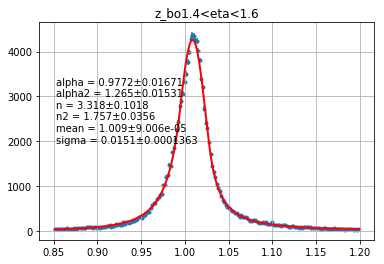

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.5267884752459302)


FCN = 244.940457419 
 TOTAL NCALL = 452 
 NCALLS = 452 
 
 
 EDM = 1.66139482299e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23876 
 0.00930449 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1977 
 0.00816567 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22088 
 0.0294708 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14517 
 0.0234297 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0092 
 3.77213e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0135103 
 5.73001e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23876 & 0.00930449 & & & & & No\\
\hline
1 & alpha2 & 1.1977 & 0.00816567 & & & & & No\\
\hline
2 & n & 2.22088 & 0.0294708 & & & & & No\\
\hline
3 & n2 & 2.14517 & 0.0234297 & & & & & No\\
\hline
4 & mean & 1.0092 & 3.77213e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0135103 & 5.73001e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 244.940456143 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 1.53365901829e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23876 
 0.00930382 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1977 
 0.00816502 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22088 
 0.0294704 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14517 
 0.023429 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0092 
 3.77212e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0135103 
 5.7292e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23876 & 0.00930382 & & & & & No\\
\hline
1 & alpha2 & 1.1977 & 0.00816502 & & & & & No\\
\hline
2 & n & 2.22088 & 0.0294704 & & & & & No\\
\hline
3 & n2 & 2.14517 & 0.023429 & & & & & No\\
\hline
4 & mean & 1.0092 & 3.77212e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0135103 & 5.7292e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


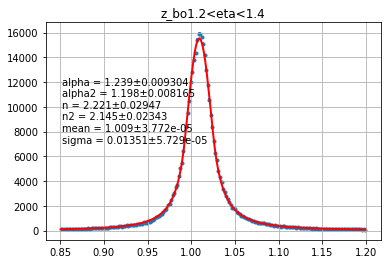

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4537117273615254)


FCN = 237.221020109 
 TOTAL NCALL = 447 
 NCALLS = 447 
 
 
 EDM = 6.92346777271e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1996 
 0.0107172 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03888 
 0.0092233 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84103 
 0.0251485 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.33871 
 0.0282309 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00825 
 4.44952e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0125151 
 7.58986e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1996 & 0.0107172 & & & & & No\\
\hline
1 & alpha2 & 1.03888 & 0.0092233 & & & & & No\\
\hline
2 & n & 1.84103 & 0.0251485 & & & & & No\\
\hline
3 & n2 & 2.33871 & 0.0282309 & & & & & No\\
\hline
4 & mean & 1.00825 & 4.44952e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0125151 & 7.58986e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 237.220993139 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 4.22557070071e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1996 
 0.0107152 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03888 
 0.00922191 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84101 
 0.0251448 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.3387 
 0.0282285 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00825 
 4.44946e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0125152 
 7.58849e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1996 & 0.0107152 & & & & & No\\
\hline
1 & alpha2 & 1.03888 & 0.00922191 & & & & & No\\
\hline
2 & n & 1.84101 & 0.0251448 & & & & & No\\
\hline
3 & n2 & 2.3387 & 0.0282285 & & & & & No\\
\hline
4 & mean & 1.00825 & 4.44946e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0125152 & 7.58849e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


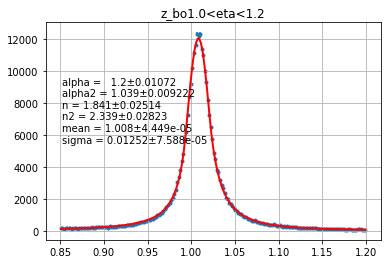

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4118942526654148)


FCN = 243.394223559 
 TOTAL NCALL = 371 
 NCALLS = 371 
 
 
 EDM = 6.48199957704e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38788 
 0.0124752 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.27063 
 0.0104285 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9307 
 0.0295191 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.76783 
 0.0213539 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 3.76734e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103518 
 5.48157e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38788 & 0.0124752 & & & & & No\\
\hline
1 & alpha2 & 1.27063 & 0.0104285 & & & & & No\\
\hline
2 & n & 1.9307 & 0.0295191 & & & & & No\\
\hline
3 & n2 & 1.76783 & 0.0213539 & & & & & No\\
\hline
4 & mean & 1.00934 & 3.76734e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103518 & 5.48157e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 243.394189682 
 TOTAL NCALL = 110 
 NCALLS = 110 
 
 
 EDM = 3.09515257911e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3879 
 0.0124771 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.27062 
 0.0104272 
 
 
 
 
 No 
 
 
 2 
 n 
 1.93073 
 0.0295249 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.76781 
 0.0213507 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 3.76734e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103518 
 5.4816e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3879 & 0.0124771 & & & & & No\\
\hline
1 & alpha2 & 1.27062 & 0.0104272 & & & & & No\\
\hline
2 & n & 1.93073 & 0.0295249 & & & & & No\\
\hline
3 & n2 & 1.76781 & 0.0213507 & & & & & No\\
\hline
4 & mean & 1.00934 & 3.76734e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103518 & 5.4816e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


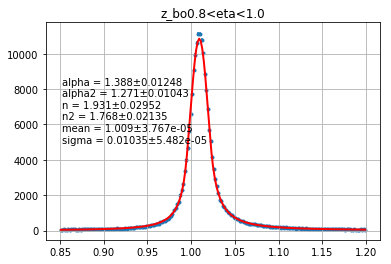

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.36432691105728643)


FCN = 235.019499397 
 TOTAL NCALL = 418 
 NCALLS = 418 
 
 
 EDM = 8.5641334956e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38931 
 0.0131678 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.12607 
 0.0118683 
 
 
 
 
 No 
 
 
 2 
 n 
 1.75225 
 0.0275824 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54992 
 0.0374186 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 4.32193e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100665 
 6.4968e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38931 & 0.0131678 & & & & & No\\
\hline
1 & alpha2 & 1.12607 & 0.0118683 & & & & & No\\
\hline
2 & n & 1.75225 & 0.0275824 & & & & & No\\
\hline
3 & n2 & 2.54992 & 0.0374186 & & & & & No\\
\hline
4 & mean & 1.00805 & 4.32193e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100665 & 6.4968e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 235.01949686 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 6.02791689884e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38931 
 0.0131676 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.12607 
 0.0118681 
 
 
 
 
 No 
 
 
 2 
 n 
 1.75225 
 0.0275819 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54992 
 0.0374177 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 4.32196e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100665 
 6.49687e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38931 & 0.0131676 & & & & & No\\
\hline
1 & alpha2 & 1.12607 & 0.0118681 & & & & & No\\
\hline
2 & n & 1.75225 & 0.0275819 & & & & & No\\
\hline
3 & n2 & 2.54992 & 0.0374177 & & & & & No\\
\hline
4 & mean & 1.00805 & 4.32196e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100665 & 6.49687e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


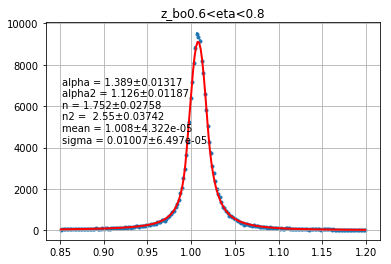

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.34567732582228144)


FCN = 198.273107733 
 TOTAL NCALL = 459 
 NCALLS = 459 
 
 
 EDM = 2.20037887341e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37698 
 0.0132718 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16323 
 0.012374 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70349 
 0.0270332 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.55043 
 0.0390552 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.31664e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00992088 
 6.43062e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37698 & 0.0132718 & & & & & No\\
\hline
1 & alpha2 & 1.16323 & 0.012374 & & & & & No\\
\hline
2 & n & 1.70349 & 0.0270332 & & & & & No\\
\hline
3 & n2 & 2.55043 & 0.0390552 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.31664e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00992088 & 6.43062e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 198.273107451 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 2.17221702626e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37698 
 0.0132708 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16323 
 0.0123731 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70349 
 0.0270325 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.55044 
 0.0390552 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.31664e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00992091 
 6.42973e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37698 & 0.0132708 & & & & & No\\
\hline
1 & alpha2 & 1.16323 & 0.0123731 & & & & & No\\
\hline
2 & n & 1.70349 & 0.0270325 & & & & & No\\
\hline
3 & n2 & 2.55044 & 0.0390552 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.31664e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00992091 & 6.42973e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


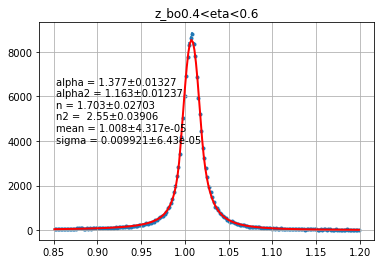

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.35041989535633544)


FCN = 229.097570274 
 TOTAL NCALL = 400 
 NCALLS = 400 
 
 
 EDM = 3.96893359869e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.52798 
 0.0155574 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13933 
 0.0120783 
 
 
 
 
 No 
 
 
 2 
 n 
 1.93421 
 0.0360335 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.52456 
 0.0378996 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.008 
 4.24474e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00948932 
 5.90749e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.52798 & 0.0155574 & & & & & No\\
\hline
1 & alpha2 & 1.13933 & 0.0120783 & & & & & No\\
\hline
2 & n & 1.93421 & 0.0360335 & & & & & No\\
\hline
3 & n2 & 2.52456 & 0.0378996 & & & & & No\\
\hline
4 & mean & 1.008 & 4.24474e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00948932 & 5.90749e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 229.097569083 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 2.77852751808e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.52798 
 0.0155502 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13933 
 0.0120756 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9342 
 0.0360225 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.52456 
 0.0378972 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.008 
 4.24521e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00948937 
 5.90568e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.52798 & 0.0155502 & & & & & No\\
\hline
1 & alpha2 & 1.13933 & 0.0120756 & & & & & No\\
\hline
2 & n & 1.9342 & 0.0360225 & & & & & No\\
\hline
3 & n2 & 2.52456 & 0.0378972 & & & & & No\\
\hline
4 & mean & 1.008 & 4.24521e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00948937 & 5.90568e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


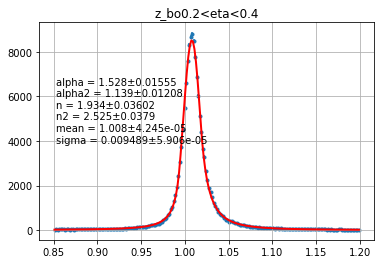

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3252596503361047)


FCN = 249.362360134 
 TOTAL NCALL = 509 
 NCALLS = 509 
 
 
 EDM = 8.7876656372e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.48891 
 0.016902 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05724 
 0.012841 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85559 
 0.0362781 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.48558 
 0.0390046 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00759 
 4.93265e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00957615 
 7.27958e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.48891 & 0.016902 & & & & & No\\
\hline
1 & alpha2 & 1.05724 & 0.012841 & & & & & No\\
\hline
2 & n & 1.85559 & 0.0362781 & & & & & No\\
\hline
3 & n2 & 2.48558 & 0.0390046 & & & & & No\\
\hline
4 & mean & 1.00759 & 4.93265e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00957615 & 7.27958e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 249.362359815 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 8.46823770747e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.48891 
 0.0169 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05724 
 0.0128396 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85559 
 0.0362765 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.48558 
 0.0390037 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00759 
 4.93254e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00957618 
 7.27816e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.48891 & 0.0169 & & & & & No\\
\hline
1 & alpha2 & 1.05724 & 0.0128396 & & & & & No\\
\hline
2 & n & 1.85559 & 0.0362765 & & & & & No\\
\hline
3 & n2 & 2.48558 & 0.0390037 & & & & & No\\
\hline
4 & mean & 1.00759 & 4.93254e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00957618 & 7.27816e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


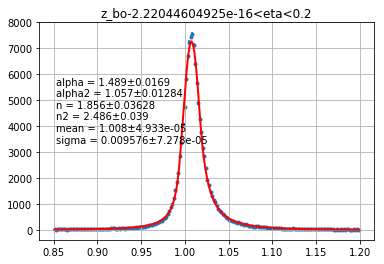

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3211929156987454)


FCN = 197.648100152 
 TOTAL NCALL = 471 
 NCALLS = 471 
 
 
 EDM = 2.88728915625e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50766 
 0.0167875 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.971364 
 0.0115864 
 
 
 
 
 No 
 
 
 2 
 n 
 1.75225 
 0.0343282 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.53482 
 0.0383387 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.20164e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00954769 
 7.28272e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50766 & 0.0167875 & & & & & No\\
\hline
1 & alpha2 & 0.971364 & 0.0115864 & & & & & No\\
\hline
2 & n & 1.75225 & 0.0343282 & & & & & No\\
\hline
3 & n2 & 2.53482 & 0.0383387 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.20164e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00954769 & 7.28272e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 197.648100152 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 2.88266159333e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50766 
 0.0165405 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.971364 
 0.0114394 
 
 
 
 
 No 
 
 
 2 
 n 
 1.75225 
 0.0341495 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.53482 
 0.0382921 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.18587e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00954769 
 7.09842e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50766 & 0.0165405 & & & & & No\\
\hline
1 & alpha2 & 0.971364 & 0.0114394 & & & & & No\\
\hline
2 & n & 1.75225 & 0.0341495 & & & & & No\\
\hline
3 & n2 & 2.53482 & 0.0382921 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.18587e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00954769 & 7.09842e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


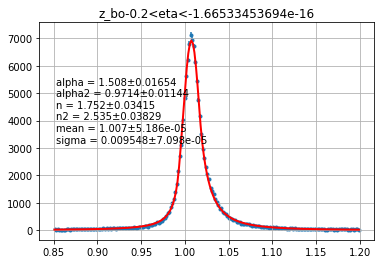

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.34697771482995565)


FCN = 284.367597523 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 7.77318977844e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.55164 
 0.0163643 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03629 
 0.0119956 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84 
 0.0351594 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.63688 
 0.0399387 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00792 
 4.74699e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00950283 
 6.66531e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.55164 & 0.0163643 & & & & & No\\
\hline
1 & alpha2 & 1.03629 & 0.0119956 & & & & & No\\
\hline
2 & n & 1.84 & 0.0351594 & & & & & No\\
\hline
3 & n2 & 2.63688 & 0.0399387 & & & & & No\\
\hline
4 & mean & 1.00792 & 4.74699e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00950283 & 6.66531e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 284.367597523 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 7.74011434139e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.55164 
 0.0160629 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03629 
 0.0117854 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84 
 0.0349205 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.63688 
 0.0398142 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00792 
 4.72546e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00950283 
 6.45707e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.55164 & 0.0160629 & & & & & No\\
\hline
1 & alpha2 & 1.03629 & 0.0117854 & & & & & No\\
\hline
2 & n & 1.84 & 0.0349205 & & & & & No\\
\hline
3 & n2 & 2.63688 & 0.0398142 & & & & & No\\
\hline
4 & mean & 1.00792 & 4.72546e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00950283 & 6.45707e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


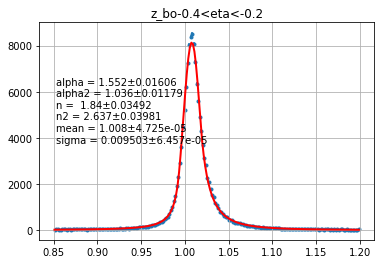

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3429443127789347)


FCN = 217.628494404 
 TOTAL NCALL = 456 
 NCALLS = 456 
 
 
 EDM = 2.08294801869e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35738 
 0.0134136 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13771 
 0.0126192 
 
 
 
 
 No 
 
 
 2 
 n 
 1.67667 
 0.0268561 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.49847 
 0.0385288 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00772 
 4.5695e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101867 
 7.00789e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35738 & 0.0134136 & & & & & No\\
\hline
1 & alpha2 & 1.13771 & 0.0126192 & & & & & No\\
\hline
2 & n & 1.67667 & 0.0268561 & & & & & No\\
\hline
3 & n2 & 2.49847 & 0.0385288 & & & & & No\\
\hline
4 & mean & 1.00772 & 4.5695e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101867 & 7.00789e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 217.628494132 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 1.81104435411e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35738 
 0.0134125 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13771 
 0.0126181 
 
 
 
 
 No 
 
 
 2 
 n 
 1.67667 
 0.0268554 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.49847 
 0.0385281 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00772 
 4.56949e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101867 
 7.00685e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35738 & 0.0134125 & & & & & No\\
\hline
1 & alpha2 & 1.13771 & 0.0126181 & & & & & No\\
\hline
2 & n & 1.67667 & 0.0268554 & & & & & No\\
\hline
3 & n2 & 2.49847 & 0.0385281 & & & & & No\\
\hline
4 & mean & 1.00772 & 4.56949e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101867 & 7.00685e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


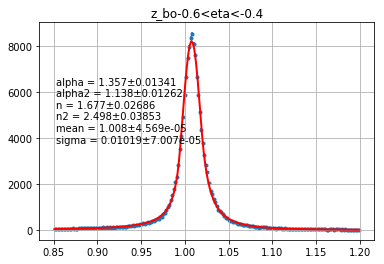

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.36537313577987796)


FCN = 202.914702226 
 TOTAL NCALL = 418 
 NCALLS = 418 
 
 
 EDM = 8.58987294413e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.4099 
 0.0138924 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05824 
 0.011265 
 
 
 
 
 No 
 
 
 2 
 n 
 1.78442 
 0.029071 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.39057 
 0.0331166 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00793 
 4.46464e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00987625 
 6.68942e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.4099 & 0.0138924 & & & & & No\\
\hline
1 & alpha2 & 1.05824 & 0.011265 & & & & & No\\
\hline
2 & n & 1.78442 & 0.029071 & & & & & No\\
\hline
3 & n2 & 2.39057 & 0.0331166 & & & & & No\\
\hline
4 & mean & 1.00793 & 4.46464e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00987625 & 6.68942e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 202.914702226 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 8.37253496938e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.4099 
 0.0137219 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05824 
 0.0111296 
 
 
 
 
 No 
 
 
 2 
 n 
 1.78442 
 0.0289649 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.39057 
 0.0330537 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00793 
 4.45744e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00987625 
 6.53724e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.4099 & 0.0137219 & & & & & No\\
\hline
1 & alpha2 & 1.05824 & 0.0111296 & & & & & No\\
\hline
2 & n & 1.78442 & 0.0289649 & & & & & No\\
\hline
3 & n2 & 2.39057 & 0.0330537 & & & & & No\\
\hline
4 & mean & 1.00793 & 4.45744e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00987625 & 6.53724e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


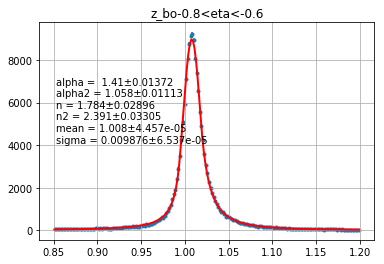

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.40256469211391854)


FCN = 240.352815069 
 TOTAL NCALL = 399 
 NCALLS = 399 
 
 
 EDM = 1.1883800818e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.4161 
 0.0128836 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.10361 
 0.00980961 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84927 
 0.0286186 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99447 
 0.0231892 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.02059e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.010151 
 5.9249e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.4161 & 0.0128836 & & & & & No\\
\hline
1 & alpha2 & 1.10361 & 0.00980961 & & & & & No\\
\hline
2 & n & 1.84927 & 0.0286186 & & & & & No\\
\hline
3 & n2 & 1.99447 & 0.0231892 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.02059e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.010151 & 5.9249e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 240.35280885 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 5.66490633551e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.4161 
 0.0128821 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.10361 
 0.00980863 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84927 
 0.0286168 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99447 
 0.0231882 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.02056e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101511 
 5.924e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.4161 & 0.0128821 & & & & & No\\
\hline
1 & alpha2 & 1.10361 & 0.00980863 & & & & & No\\
\hline
2 & n & 1.84927 & 0.0286168 & & & & & No\\
\hline
3 & n2 & 1.99447 & 0.0231882 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.02056e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101511 & 5.924e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


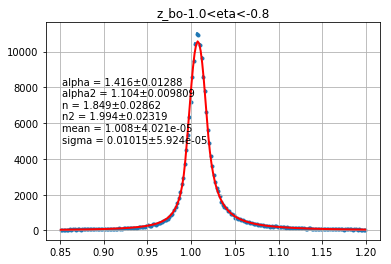

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.43929687509781795)


FCN = 236.339208226 
 TOTAL NCALL = 468 
 NCALLS = 468 
 
 
 EDM = 7.28465395564e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23473 
 0.0106206 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03908 
 0.00906303 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90053 
 0.0265376 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50438 
 0.0308887 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0058 
 4.42121e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127286 
 7.25138e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23473 & 0.0106206 & & & & & No\\
\hline
1 & alpha2 & 1.03908 & 0.00906303 & & & & & No\\
\hline
2 & n & 1.90053 & 0.0265376 & & & & & No\\
\hline
3 & n2 & 2.50438 & 0.0308887 & & & & & No\\
\hline
4 & mean & 1.0058 & 4.42121e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127286 & 7.25138e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 236.339208224 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 5.91907352738e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23473 
 0.0106196 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03908 
 0.00906228 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90053 
 0.0265371 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50438 
 0.0308884 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0058 
 4.42121e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127286 
 7.25015e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23473 & 0.0106196 & & & & & No\\
\hline
1 & alpha2 & 1.03908 & 0.00906228 & & & & & No\\
\hline
2 & n & 1.90053 & 0.0265371 & & & & & No\\
\hline
3 & n2 & 2.50438 & 0.0308884 & & & & & No\\
\hline
4 & mean & 1.0058 & 4.42121e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127286 & 7.25015e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


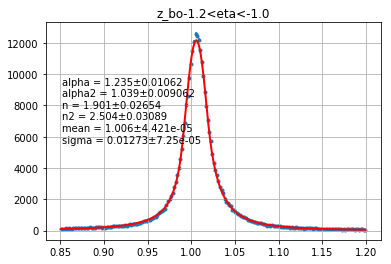

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.5211947495717226)


FCN = 278.722162798 
 TOTAL NCALL = 463 
 NCALLS = 463 
 
 
 EDM = 6.75455056066e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27299 
 0.00953134 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18246 
 0.00830913 
 
 
 
 
 No 
 
 
 2 
 n 
 2.2243 
 0.0304444 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.20154 
 0.0244788 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 3.82239e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0138456 
 5.88327e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27299 & 0.00953134 & & & & & No\\
\hline
1 & alpha2 & 1.18246 & 0.00830913 & & & & & No\\
\hline
2 & n & 2.2243 & 0.0304444 & & & & & No\\
\hline
3 & n2 & 2.20154 & 0.0244788 & & & & & No\\
\hline
4 & mean & 1.00766 & 3.82239e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0138456 & 5.88327e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 278.722130215 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 3.49552566963e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27299 
 0.00952981 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18245 
 0.00830787 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22429 
 0.0304412 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.20153 
 0.0244764 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 3.82234e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0138458 
 5.88229e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27299 & 0.00952981 & & & & & No\\
\hline
1 & alpha2 & 1.18245 & 0.00830787 & & & & & No\\
\hline
2 & n & 2.22429 & 0.0304412 & & & & & No\\
\hline
3 & n2 & 2.20153 & 0.0244764 & & & & & No\\
\hline
4 & mean & 1.00766 & 3.82234e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0138458 & 5.88229e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


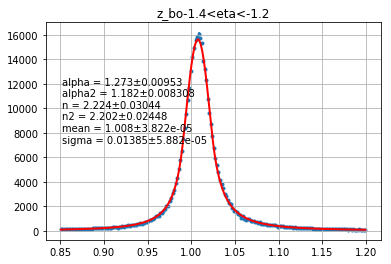

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2892068742900622)


FCN = 244.335202636 
 TOTAL NCALL = 409 
 NCALLS = 409 
 
 
 EDM = 4.95259509736e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17862 
 0.0177163 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.09509 
 0.0153401 
 
 
 
 
 No 
 
 
 2 
 n 
 2.17669 
 0.0574514 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.65691 
 0.0594478 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00646 
 7.99603e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0161075 
 0.000142069 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17862 & 0.0177163 & & & & & No\\
\hline
1 & alpha2 & 1.09509 & 0.0153401 & & & & & No\\
\hline
2 & n & 2.17669 & 0.0574514 & & & & & No\\
\hline
3 & n2 & 2.65691 & 0.0594478 & & & & & No\\
\hline
4 & mean & 1.00646 & 7.99603e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0161075 & 0.000142069 & & & & & No\\
\hline
\end{tabular}

FCN = 244.3352017 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = 4.01481347593e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17862 
 0.0177135 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.09509 
 0.0153398 
 
 
 
 
 No 
 
 
 2 
 n 
 2.17668 
 0.0574459 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.65691 
 0.0594471 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00646 
 7.99606e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0161076 
 0.000142053 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17862 & 0.0177135 & & & & & No\\
\hline
1 & alpha2 & 1.09509 & 0.0153398 & & & & & No\\
\hline
2 & n & 2.17668 & 0.0574459 & & & & & No\\
\hline
3 & n2 & 2.65691 & 0.0594471 & & & & & No\\
\hline
4 & mean & 1.00646 & 7.99606e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0161076 & 0.000142053 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


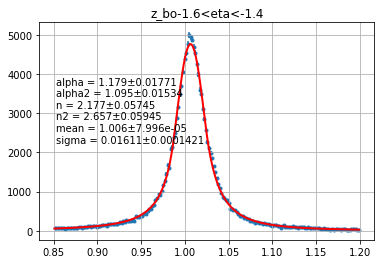

In [12]:
Tipe=['target','z_default','z_bo']
n=16

mean_eta_un=np.zeros((n))
mean_eta_de=np.zeros((n))
mean_eta_bo=np.zeros((n))

mean_err_eta_un=np.zeros((n))
mean_err_eta_de=np.zeros((n))
mean_err_eta_bo=np.zeros((n))

sigma_eta_un=np.zeros((n))
sigma_eta_de=np.zeros((n))
sigma_eta_bo=np.zeros((n))

sigma_err_eta_un=np.zeros((n))
sigma_err_eta_de=np.zeros((n))
sigma_err_eta_bo=np.zeros((n))

feat=[]
eta=np.zeros((n))
nbins=200
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for tipe in Tipe:
    for para in feat:
        if tipe=='target':
            rmin = 0.83
            rmax = 1.1
        else:
            rmin=0.85
            rmax=1.2
        df=data.query(para).astype('double')
        df=df[tipe]
        bound_DCB=[rmin, rmax]
        normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
        binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
        for j in range(2):
        #first step
            if j==0: 
                pars_dcb = dict(mean  = 0.97, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
                           
        #optimize parameter withoptimized start parameter
            else:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
            minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
            minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
        binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
        if tipe=='target':
            mean_eta_un[i]=minuit.values['mean']
            mean_err_eta_un[i]=minuit.errors['mean']
            sigma_eta_un[i]=minuit.values['sigma']
            sigma_err_eta_un[i]=minuit.errors['sigma']
        if tipe=='z_default':
            mean_eta_de[i]=minuit.values['mean']
            mean_err_eta_de[i]=minuit.errors['mean']
            sigma_eta_de[i]=minuit.values['sigma']
            sigma_err_eta_de[i]=minuit.errors['sigma']       
        if tipe=='z_bo':
            mean_eta_bo[i]=minuit.values['mean']
            mean_err_eta_bo[i]=minuit.errors['mean']
            sigma_eta_bo[i]=minuit.values['sigma']
            sigma_err_eta_bo[i]=minuit.errors['sigma'] 
        print(para)
    
        i+=1
        if i==16:
            i=0
        
        plt.title(tipe+para)
        plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
        plt.show()

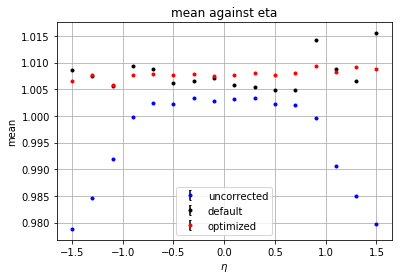

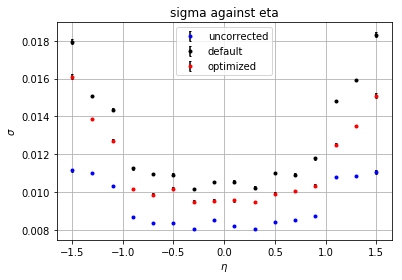

In [13]:
plt.figure()
plt.errorbar(eta,mean_eta_un, yerr=mean_err_eta_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_de, yerr=mean_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_bo, yerr=mean_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against eta')
plt.xlabel('$\eta$')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_eta'+'.png'))
plt.show()

plt.figure()
plt.errorbar(eta,sigma_eta_un, yerr=sigma_err_eta_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_de, yerr=sigma_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_bo, yerr=sigma_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('sigma against eta')
plt.xlabel('$\eta$')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_eta'+'.png'))
plt.show()

#  PT

0


<Figure size 432x288 with 0 Axes>

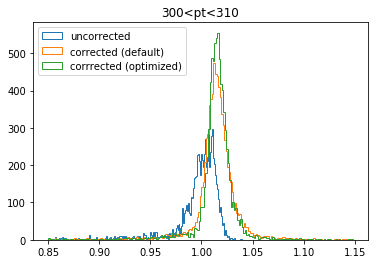

1


<Figure size 432x288 with 0 Axes>

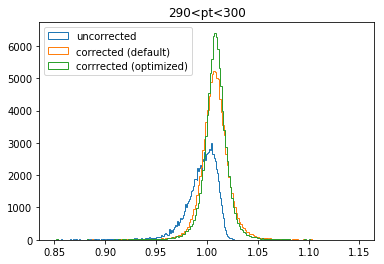

2


<Figure size 432x288 with 0 Axes>

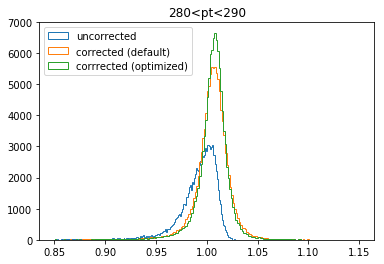

3


<Figure size 432x288 with 0 Axes>

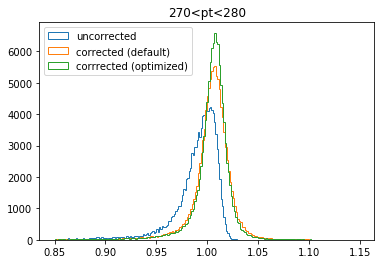

4


<Figure size 432x288 with 0 Axes>

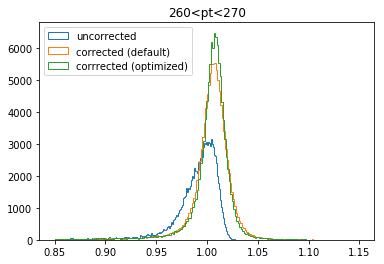

5


<Figure size 432x288 with 0 Axes>

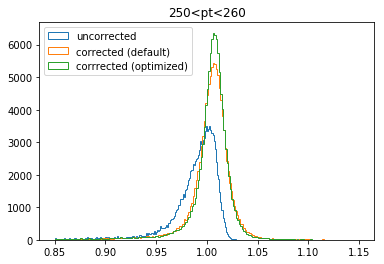

6


<Figure size 432x288 with 0 Axes>

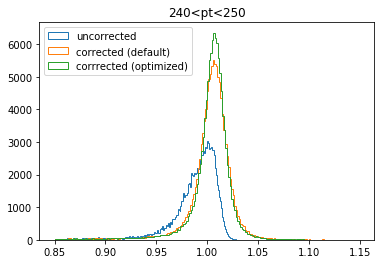

7


<Figure size 432x288 with 0 Axes>

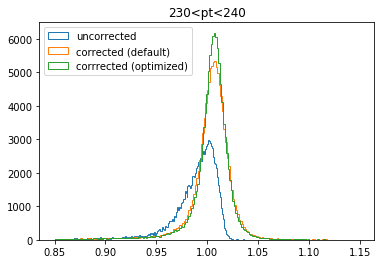

8


<Figure size 432x288 with 0 Axes>

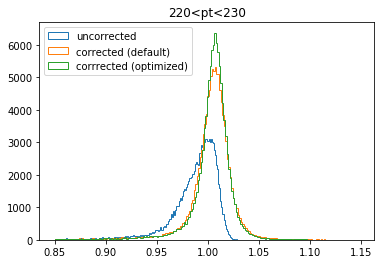

9


<Figure size 432x288 with 0 Axes>

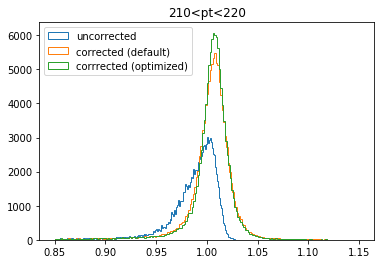

10


<Figure size 432x288 with 0 Axes>

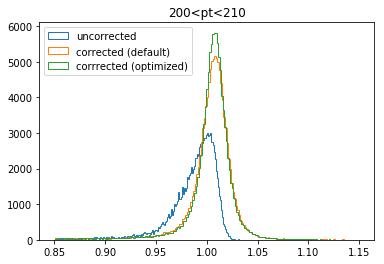

11


<Figure size 432x288 with 0 Axes>

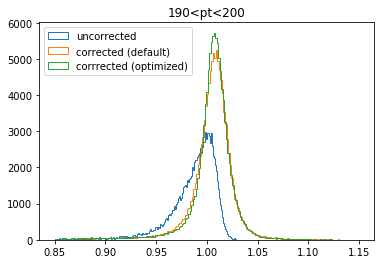

12


<Figure size 432x288 with 0 Axes>

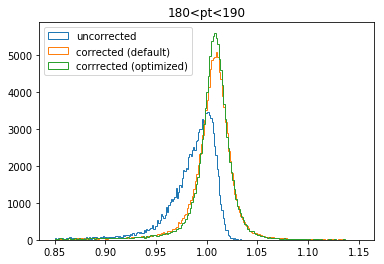

13


<Figure size 432x288 with 0 Axes>

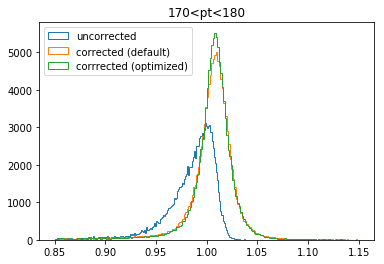

14


<Figure size 432x288 with 0 Axes>

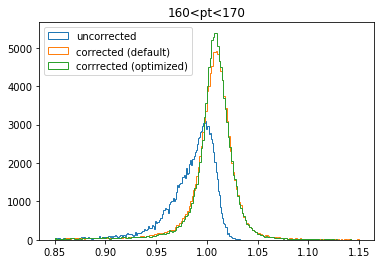

15


<Figure size 432x288 with 0 Axes>

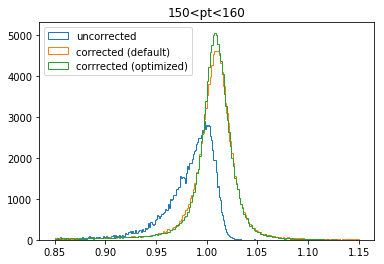

16


<Figure size 432x288 with 0 Axes>

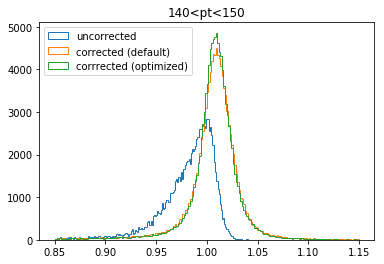

17


<Figure size 432x288 with 0 Axes>

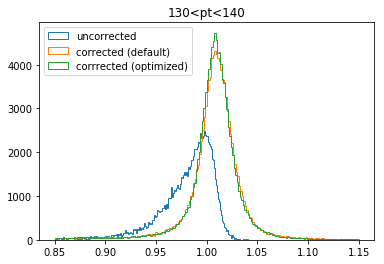

18


<Figure size 432x288 with 0 Axes>

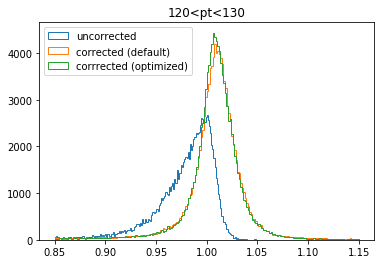

19


<Figure size 432x288 with 0 Axes>

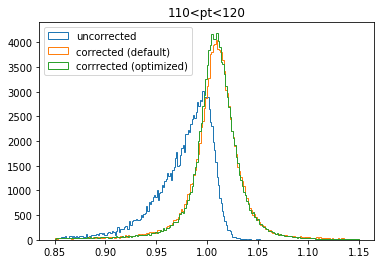

20


<Figure size 432x288 with 0 Axes>

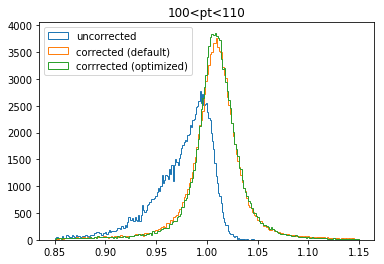

21


<Figure size 432x288 with 0 Axes>

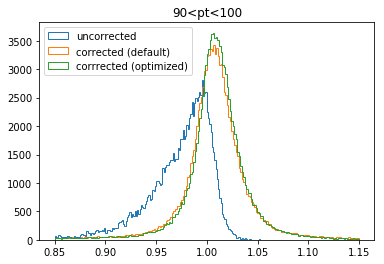

22


<Figure size 432x288 with 0 Axes>

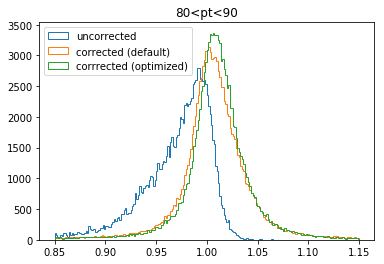

23


<Figure size 432x288 with 0 Axes>

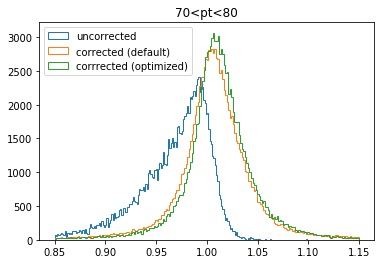

24


<Figure size 432x288 with 0 Axes>

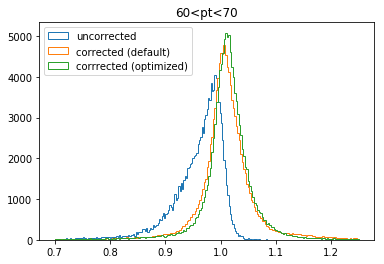

25


<Figure size 432x288 with 0 Axes>

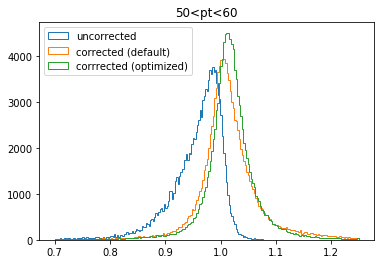

26


<Figure size 432x288 with 0 Axes>

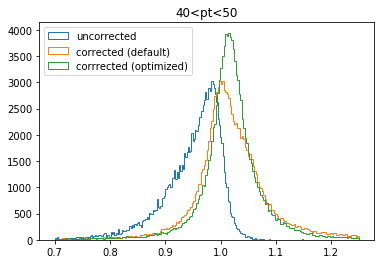

27


<Figure size 432x288 with 0 Axes>

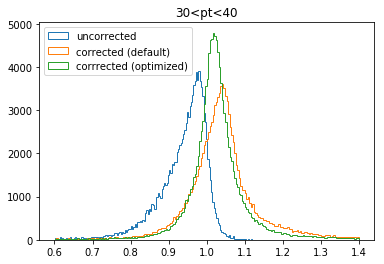

28


<Figure size 432x288 with 0 Axes>

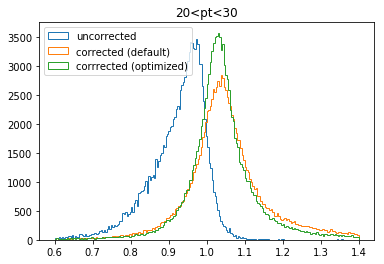

In [10]:
n=29
pt=np.zeros((n))
mean_pt=np.zeros((n))
err_mean_pt=np.zeros((n))
sigma_pt=np.zeros((n))
err_sigma_pt=np.zeros((n))

feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
i=0

for para in feat_pt:
    plt.figure()
    df=DF.query(para).astype('double')
    if i<=23:
        rmin = 0.85
        rmax = 1.15
    elif 23<i<27:
        rmin=0.7
        rmax=1.25
    else:
        rmin=0.6
        rmax=1.4
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_pt_'+para+'.png'))
    print(i)
    plt.show()
    i+=1

In [14]:
Tipe=['target','z_default','z_bo']
n=29

mean_pt_un=np.zeros((n))
mean_pt_de=np.zeros((n))
mean_pt_bo=np.zeros((n))

mean_err_pt_un=np.zeros((n))
mean_err_pt_de=np.zeros((n))
mean_err_pt_bo=np.zeros((n))

sigma_pt_un=np.zeros((n))
sigma_pt_de=np.zeros((n))
sigma_pt_bo=np.zeros((n))

sigma_err_pt_un=np.zeros((n))
sigma_err_pt_de=np.zeros((n))
sigma_err_pt_bo=np.zeros((n))

pt=np.zeros((n))
feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
nbins=200

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.09851976111952807)


FCN = 571.7557402 
 TOTAL NCALL = 590 
 NCALLS = 579 
 
 
 EDM = 0.716661095342 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.144068 
 0.102998 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.383339 
 0.267202 
 
 
 
 
 No 
 
 
 2 
 n 
 4.39421 
 0.279789 
 
 
 
 
 No 
 
 
 3 
 n2 
 101.344 
 47.3038 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01012 
 0.00037574 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00173519 
 0.00122111 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.144068 & 0.102998 & & & & & No\\
\hline
1 & alpha2 & -0.383339 & 0.267202 & & & & & No\\
\hline
2 & n & 4.39421 & 0.279789 & & & & & No\\
\hline
3 & n2 & 101.344 & 47.3038 & & & & & No\\
\hline
4 & mean & 1.01012 & 0.00037574 & & & & & No\\
\hline
5 & $\sigma$ & 0.00173519 & 0.00122111 & & & & & No\\
\hline
\end{tabular}

FCN = 571.7557402 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 0.65730987252 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.144068 
 0.00664739 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.383339 
 0.0155012 
 
 
 
 
 No 
 
 
 2 
 n 
 4.39421 
 0.236845 
 
 
 
 
 No 
 
 
 3 
 n2 
 101.344 
 47.2205 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01012 
 0.000135122 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00173519 
 5.96818e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.144068 & 0.00664739 & & & & & No\\
\hline
1 & alpha2 & -0.383339 & 0.0155012 & & & & & No\\
\hline
2 & n & 4.39421 & 0.236845 & & & & & No\\
\hline
3 & n2 & 101.344 & 47.2205 & & & & & No\\
\hline
4 & mean & 1.01012 & 0.000135122 & & & & & No\\
\hline
5 & $\sigma$ & 0.00173519 & 5.96818e-05 & & & & & No\\
\hline
\end{tabular}

300<pt<310


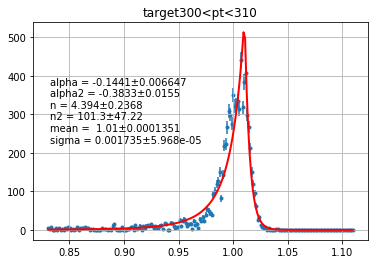

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.3362513025583783)


FCN = 4101.15947825 
 TOTAL NCALL = 808 
 NCALLS = 797 
 
 
 EDM = 4.44174677279 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.187641 
 0.00604825 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.511337 
 0.0177218 
 
 
 
 
 No 
 
 
 2 
 n 
 19.1264 
 0.604516 
 
 
 
 
 No 
 
 
 3 
 n2 
 108.511 
 8.34424 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00413 
 4.28759e-08 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00282031 
 9.45637e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.187641 & 0.00604825 & & & & & No\\
\hline
1 & alpha2 & -0.511337 & 0.0177218 & & & & & No\\
\hline
2 & n & 19.1264 & 0.604516 & & & & & No\\
\hline
3 & n2 & 108.511 & 8.34424 & & & & & No\\
\hline
4 & mean & 1.00413 & 4.28759e-08 & & & & & No\\
\hline
5 & $\sigma$ & 0.00282031 & 9.45637e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 4101.15947825 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 15.5956725421 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.187641 
 0.00159067 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.511337 
 0.00386998 
 
 
 
 
 No 
 
 
 2 
 n 
 19.1264 
 1.07605 
 
 
 
 
 No 
 
 
 3 
 n2 
 108.511 
 9.59577 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00413 
 3.20877e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00282031 
 1.57605e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.187641 & 0.00159067 & & & & & No\\
\hline
1 & alpha2 & -0.511337 & 0.00386998 & & & & & No\\
\hline
2 & n & 19.1264 & 1.07605 & & & & & No\\
\hline
3 & n2 & 108.511 & 9.59577 & & & & & No\\
\hline
4 & mean & 1.00413 & 3.20877e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00282031 & 1.57605e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300


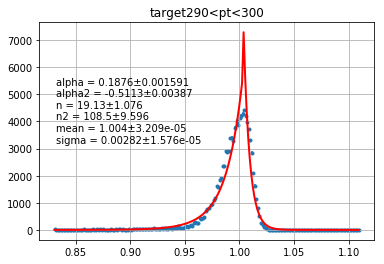

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.3840989313423168)


FCN = 2934.55625219 
 TOTAL NCALL = 457 
 NCALLS = 446 
 
 
 EDM = 399.966946401 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.183409 
 1600.39 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.713373 
 1600.39 
 
 
 
 
 No 
 
 
 2 
 n 
 34.6117 
 4.23541 
 
 
 
 
 No 
 
 
 3 
 n2 
 96.5842 
 1594.04 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00504 
 1600.39 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00351326 
 1600.39 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.183409 & 1600.39 & & & & & No\\
\hline
1 & alpha2 & 0.713373 & 1600.39 & & & & & No\\
\hline
2 & n & 34.6117 & 4.23541 & & & & & No\\
\hline
3 & n2 & 96.5842 & 1594.04 & & & & & No\\
\hline
4 & mean & 1.00504 & 1600.39 & & & & & No\\
\hline
5 & $\sigma$ & 0.00351326 & 1600.39 & & & & & No\\
\hline
\end{tabular}

FCN = 2859.27415485 
 TOTAL NCALL = 131 
 NCALLS = 120 
 
 
 EDM = 282.277842655 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.190673 
 0.00159283 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.762343 
 0.00834805 
 
 
 
 
 No 
 
 
 2 
 n 
 19.6701 
 1.40481 
 
 
 
 
 No 
 
 
 3 
 n2 
 121.478 
 8.73489 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00508 
 6.05096e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00354389 
 2.49681e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.190673 & 0.00159283 & & & & & No\\
\hline
1 & alpha2 & 0.762343 & 0.00834805 & & & & & No\\
\hline
2 & n & 19.6701 & 1.40481 & & & & & No\\
\hline
3 & n2 & 121.478 & 8.73489 & & & & & No\\
\hline
4 & mean & 1.00508 & 6.05096e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00354389 & 2.49681e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290


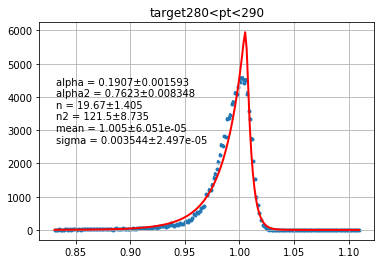

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.3981855418999556)


FCN = 1975.23948777 
 TOTAL NCALL = 681 
 NCALLS = 670 
 
 
 EDM = 321.463439594 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.369152 
 1.62195 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.66611 
 1.62414 
 
 
 
 
 No 
 
 
 2 
 n 
 28.9593 
 0.707107 
 
 
 
 
 No 
 
 
 3 
 n2 
 69.2269 
 2.07693 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00238 
 1.62195 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00735105 
 1.62195 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.369152 & 1.62195 & & & & & No\\
\hline
1 & alpha2 & 2.66611 & 1.62414 & & & & & No\\
\hline
2 & n & 28.9593 & 0.707107 & & & & & No\\
\hline
3 & n2 & 69.2269 & 2.07693 & & & & & No\\
\hline
4 & mean & 1.00238 & 1.62195 & & & & & No\\
\hline
5 & $\sigma$ & 0.00735105 & 1.62195 & & & & & No\\
\hline
\end{tabular}

FCN = 1425.87128408 
 TOTAL NCALL = 406 
 NCALLS = 395 
 
 
 EDM = 141.809947511 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.530906 
 0.00482504 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.11074 
 2.09004 
 
 
 
 
 No 
 
 
 2 
 n 
 6.2381 
 0.127396 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.2478 
 9.07918 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00094 
 6.3244e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00819624 
 4.36662e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.530906 & 0.00482504 & & & & & No\\
\hline
1 & alpha2 & 4.11074 & 2.09004 & & & & & No\\
\hline
2 & n & 6.2381 & 0.127396 & & & & & No\\
\hline
3 & n2 & 1.2478 & 9.07918 & & & & & No\\
\hline
4 & mean & 1.00094 & 6.3244e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00819624 & 4.36662e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280


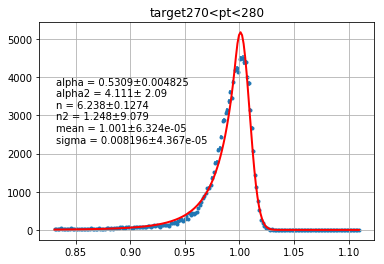

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.4008757957626462)


FCN = 2972.64211829 
 TOTAL NCALL = 417 
 NCALLS = 406 
 
 
 EDM = 32019.9349197 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.25438 
 3.65727 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18231 
 3.65728 
 
 
 
 
 No 
 
 
 2 
 n 
 34.1536 
 0.707107 
 
 
 
 
 No 
 
 
 3 
 n2 
 93.2891 
 9.06395 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00395 
 3.65727 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00547747 
 3.65727 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.25438 & 3.65727 & & & & & No\\
\hline
1 & alpha2 & 1.18231 & 3.65728 & & & & & No\\
\hline
2 & n & 34.1536 & 0.707107 & & & & & No\\
\hline
3 & n2 & 93.2891 & 9.06395 & & & & & No\\
\hline
4 & mean & 1.00395 & 3.65727 & & & & & No\\
\hline
5 & $\sigma$ & 0.00547747 & 3.65727 & & & & & No\\
\hline
\end{tabular}

FCN = 2175.63246526 
 TOTAL NCALL = 183 
 NCALLS = 172 
 
 
 EDM = 79.4260484904 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.375627 
 0.00399092 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.05367 
 0.0249653 
 
 
 
 
 No 
 
 
 2 
 n 
 11.8585 
 0.551995 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.571 
 29.2331 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00254 
 7.85629e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00737829 
 6.43695e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.375627 & 0.00399092 & & & & & No\\
\hline
1 & alpha2 & 2.05367 & 0.0249653 & & & & & No\\
\hline
2 & n & 11.8585 & 0.551995 & & & & & No\\
\hline
3 & n2 & 124.571 & 29.2331 & & & & & No\\
\hline
4 & mean & 1.00254 & 7.85629e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00737829 & 6.43695e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270


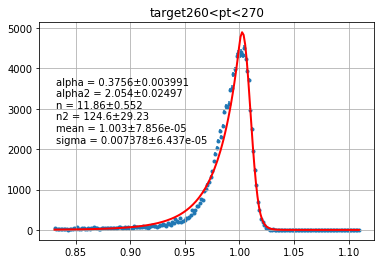

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.4089360960109456)


FCN = 2497.09603249 
 TOTAL NCALL = 643 
 NCALLS = 643 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.335521 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.50899 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 68.2847 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 165.117 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00228 
 nan 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00739671 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.335521 & nan & & & & & No\\
\hline
1 & alpha2 & 2.50899 & nan & & & & & No\\
\hline
2 & n & 68.2847 & nan & & & & & No\\
\hline
3 & n2 & 165.117 & nan & & & & & No\\
\hline
4 & mean & 1.00228 & nan & & & & & No\\
\hline
5 & $\sigma$ & 0.00739671 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 2329.83450008 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.335521 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.50899 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 24.7995 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 165.117 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00228 
 nan 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00739671 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.335521 & nan & & & & & No\\
\hline
1 & alpha2 & 2.50899 & nan & & & & & No\\
\hline
2 & n & 24.7995 & nan & & & & & No\\
\hline
3 & n2 & 165.117 & nan & & & & & No\\
\hline
4 & mean & 1.00228 & nan & & & & & No\\
\hline
5 & $\sigma$ & 0.00739671 & nan & & & & & No\\
\hline
\end{tabular}

250<pt<260


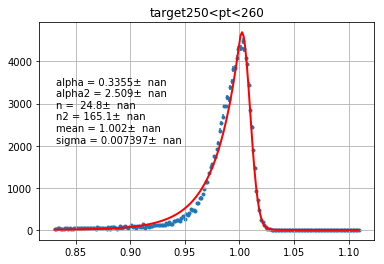

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.4155287107623328)


FCN = 3263.20182498 
 TOTAL NCALL = 573 
 NCALLS = 562 
 
 
 EDM = 23.8883296753 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0934083 
 0.00370867 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.429721 
 0.0192702 
 
 
 
 
 No 
 
 
 2 
 n 
 17.1159 
 0.784914 
 
 
 
 
 No 
 
 
 3 
 n2 
 122.679 
 16.8592 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00575 
 5.10114e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00198536 
 8.38414e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0934083 & 0.00370867 & & & & & No\\
\hline
1 & alpha2 & 0.429721 & 0.0192702 & & & & & No\\
\hline
2 & n & 17.1159 & 0.784914 & & & & & No\\
\hline
3 & n2 & 122.679 & 16.8592 & & & & & No\\
\hline
4 & mean & 1.00575 & 5.10114e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00198536 & 8.38414e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 3263.20182498 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 23.4958684062 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0934083 
 0.000781705 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.429721 
 0.00502958 
 
 
 
 
 No 
 
 
 2 
 n 
 17.1159 
 0.78209 
 
 
 
 
 No 
 
 
 3 
 n2 
 122.679 
 16.9641 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00575 
 8.5392e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00198536 
 1.06273e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0934083 & 0.000781705 & & & & & No\\
\hline
1 & alpha2 & 0.429721 & 0.00502958 & & & & & No\\
\hline
2 & n & 17.1159 & 0.78209 & & & & & No\\
\hline
3 & n2 & 122.679 & 16.9641 & & & & & No\\
\hline
4 & mean & 1.00575 & 8.5392e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00198536 & 1.06273e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250


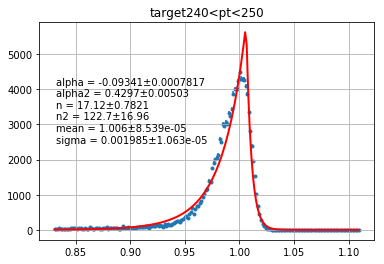

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.41425464117599814)


FCN = 3001.51430097 
 TOTAL NCALL = 623 
 NCALLS = 612 
 
 
 EDM = 9.10777100703 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0671792 
 0.0142595 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.282494 
 0.0605936 
 
 
 
 
 No 
 
 
 2 
 n 
 12.3289 
 0.503988 
 
 
 
 
 No 
 
 
 3 
 n2 
 113.027 
 13.2264 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00547 
 7.58552e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00135846 
 0.000292407 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0671792 & 0.0142595 & & & & & No\\
\hline
1 & alpha2 & 0.282494 & 0.0605936 & & & & & No\\
\hline
2 & n & 12.3289 & 0.503988 & & & & & No\\
\hline
3 & n2 & 113.027 & 13.2264 & & & & & No\\
\hline
4 & mean & 1.00547 & 7.58552e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00135846 & 0.000292407 & & & & & No\\
\hline
\end{tabular}

FCN = 3001.51430097 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 9.10086156722 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0671792 
 0.000638152 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.282494 
 0.00288172 
 
 
 
 
 No 
 
 
 2 
 n 
 12.3289 
 0.521132 
 
 
 
 
 No 
 
 
 3 
 n2 
 113.027 
 13.2677 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00547 
 8.03817e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00135846 
 6.3599e-06 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0671792 & 0.000638152 & & & & & No\\
\hline
1 & alpha2 & 0.282494 & 0.00288172 & & & & & No\\
\hline
2 & n & 12.3289 & 0.521132 & & & & & No\\
\hline
3 & n2 & 113.027 & 13.2677 & & & & & No\\
\hline
4 & mean & 1.00547 & 8.03817e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00135846 & 6.3599e-06 & & & & & No\\
\hline
\end{tabular}

230<pt<240


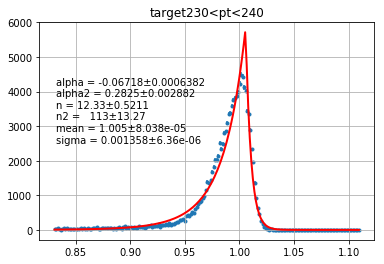

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.42571848864409095)


FCN = 2974.73805489 
 TOTAL NCALL = 666 
 NCALLS = 655 
 
 
 EDM = 11.8511488163 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0149429 
 0.000619944 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.0644876 
 0.00255113 
 
 
 
 
 No 
 
 
 2 
 n 
 13.7962 
 0.694034 
 
 
 
 
 No 
 
 
 3 
 n2 
 93.2027 
 9.75139 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00557 
 5.00472e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.000316415 
 1.26968e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0149429 & 0.000619944 & & & & & No\\
\hline
1 & alpha2 & -0.0644876 & 0.00255113 & & & & & No\\
\hline
2 & n & 13.7962 & 0.694034 & & & & & No\\
\hline
3 & n2 & 93.2027 & 9.75139 & & & & & No\\
\hline
4 & mean & 1.00557 & 5.00472e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.000316415 & 1.26968e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2974.73805489 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0149429 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 -0.0644876 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 13.7962 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 93.2027 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00557 
 nan 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.000316415 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0149429 & nan & & & & & No\\
\hline
1 & alpha2 & -0.0644876 & nan & & & & & No\\
\hline
2 & n & 13.7962 & nan & & & & & No\\
\hline
3 & n2 & 93.2027 & nan & & & & & No\\
\hline
4 & mean & 1.00557 & nan & & & & & No\\
\hline
5 & $\sigma$ & 0.000316415 & nan & & & & & No\\
\hline
\end{tabular}

220<pt<230


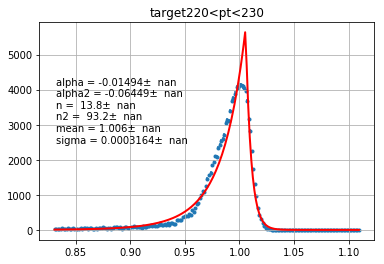

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:54: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.4235070273971321)


FCN = 17967.0011385 
 TOTAL NCALL = 147 
 NCALLS = 136 
 
 
 EDM = 252485.462834 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0504234 
 0.00011598 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.250235 
 0.00921675 
 
 
 
 
 No 
 
 
 2 
 n 
 6 
 0.0184758 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.69261 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 6.81794e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.001 
 8.09999e-06 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0504234 & 0.00011598 & & & & & No\\
\hline
1 & alpha2 & 0.250235 & 0.00921675 & & & & & No\\
\hline
2 & n & 6 & 0.0184758 & & & & & No\\
\hline
3 & n2 & 4 & 1.69261 & & & & & No\\
\hline
4 & mean & 0.999 & 6.81794e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.001 & 8.09999e-06 & & & & & No\\
\hline
\end{tabular}

FCN = 17967.0011385 
 TOTAL NCALL = 97 
 NCALLS = 86 
 
 
 EDM = 154465.207836 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 -0.0504234 
 9.83657e-05 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.250235 
 0.00986594 
 
 
 
 
 No 
 
 
 2 
 n 
 6 
 0.0171913 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.7226 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 0.000101714 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.001 
 7.70802e-07 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & -0.0504234 & 9.83657e-05 & & & & & No\\
\hline
1 & alpha2 & 0.250235 & 0.00986594 & & & & & No\\
\hline
2 & n & 6 & 0.0171913 & & & & & No\\
\hline
3 & n2 & 4 & 1.7226 & & & & & No\\
\hline
4 & mean & 0.999 & 0.000101714 & & & & & No\\
\hline
5 & $\sigma$ & 0.001 & 7.70802e-07 & & & & & No\\
\hline
\end{tabular}

210<pt<220


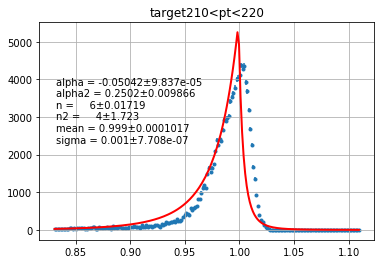

In [ ]:
tipe='target'
i=0
for para in feat_pt:
    if i>25:
        rmin=0.78
        rmax=1.2
    
    else:
        rmin = 0.83
        rmax = 1.11
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(2):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 0.999, 
                        fix_mean = False,
                        sigma  = 0.001,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
                           
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (2.0755710409663335, 1.9767907744685398, 0.564133118136755, -0.6855899709025639, 1.0147516735353648, 0.015)


FCN = 624.062320001 
 TOTAL NCALL = 339 
 NCALLS = 339 
 
 
 EDM = 5.479092139e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07509 
 0.0736932 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.26472 
 0.0997615 
 
 
 
 
 No 
 
 
 2 
 n 
 1.18648 
 0.189178 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.970074 
 0.27648 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0154 
 0.000185063 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07509 & 0.0736932 & & & & & No\\
\hline
1 & alpha2 & 2.26472 & 0.0997615 & & & & & No\\
\hline
2 & n & 1.18648 & 0.189178 & & & & & No\\
\hline
3 & n2 & 0.970074 & 0.27648 & & & & & No\\
\hline
4 & mean & 1.0154 & 0.000185063 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 235.148760316 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 1.92104961464e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07509 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.26472 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.18648 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.970074 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0154 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0106746 
 0.000125997 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07509 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.26472 & 1 & & & & & Yes\\
\hline
2 & n & 1.18648 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.970074 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0154 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0106746 & 0.000125997 & & & & & No\\
\hline
\end{tabular}

FCN = 123.472404534 
 TOTAL NCALL = 322 
 NCALLS = 322 
 
 
 EDM = 4.21109201937e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.78236 
 0.0635695 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.15428 
 0.0652716 
 
 
 
 
 No 
 
 
 2 
 n 
 1.35617 
 0.127899 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.08879 
 0.578587 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01437 
 0.000170727 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00896537 
 0.000186902 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.78236 & 0.0635695 & & & & & No\\
\hline
1 & alpha2 & 1.15428 & 0.0652716 & & & & & No\\
\hline
2 & n & 1.35617 & 0.127899 & & & & & No\\
\hline
3 & n2 & 4.08879 & 0.578587 & & & & & No\\
\hline
4 & mean & 1.01437 & 0.000170727 & & & & & No\\
\hline
5 & $\sigma$ & 0.00896537 & 0.000186902 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


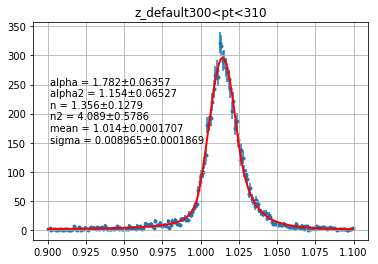

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (2.595126358879496, 2.0713531826050544, -2.912824859902262, 4.732738365874991, 1.0084880230514446, 0.015)


FCN = 4399.16787024 
 TOTAL NCALL = 173 
 NCALLS = 162 
 
 
 EDM = 6513.06019632 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.38046 
 0.0351594 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.06517 
 0.253387 
 
 
 
 
 No 
 
 
 2 
 n 
 1.92217 
 0.161813 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.45705 
 5.60251 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00833 
 4.95838e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.38046 & 0.0351594 & & & & & No\\
\hline
1 & alpha2 & 2.06517 & 0.253387 & & & & & No\\
\hline
2 & n & 1.92217 & 0.161813 & & & & & No\\
\hline
3 & n2 & 5.45705 & 5.60251 & & & & & No\\
\hline
4 & mean & 1.00833 & 4.95838e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1341.17773407 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 1.10591709268e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.38046 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.06517 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.92217 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.45705 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00833 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0119744 
 3.32814e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.38046 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.06517 & 1 & & & & & Yes\\
\hline
2 & n & 1.92217 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.45705 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00833 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0119744 & 3.32814e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 205.248031135 
 TOTAL NCALL = 349 
 NCALLS = 349 
 
 
 EDM = 2.35426528831e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.67703 
 0.0275618 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38263 
 0.0244104 
 
 
 
 
 No 
 
 
 2 
 n 
 3.31397 
 0.151325 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.41007 
 0.414438 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00753 
 4.70511e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103964 
 5.99844e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.67703 & 0.0275618 & & & & & No\\
\hline
1 & alpha2 & 1.38263 & 0.0244104 & & & & & No\\
\hline
2 & n & 3.31397 & 0.151325 & & & & & No\\
\hline
3 & n2 & 6.41007 & 0.414438 & & & & & No\\
\hline
4 & mean & 1.00753 & 4.70511e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103964 & 5.99844e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


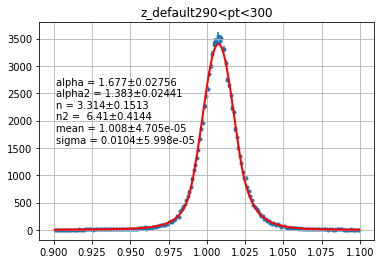

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.4884172623084357, 2.2554297747659975, 0.9160315312143368, 7.585157926033714, 1.0064508750002177, 0.015)


FCN = 3207.39057053 
 TOTAL NCALL = 428 
 NCALLS = 428 
 
 
 EDM = 6.14128267472e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.02272 
 0.0224541 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.44146 
 0.0349983 
 
 
 
 
 No 
 
 
 2 
 n 
 1.74836 
 0.0845765 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.62898 
 0.141635 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00634 
 4.89729e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.02272 & 0.0224541 & & & & & No\\
\hline
1 & alpha2 & 2.44146 & 0.0349983 & & & & & No\\
\hline
2 & n & 1.74836 & 0.0845765 & & & & & No\\
\hline
3 & n2 & 1.62898 & 0.141635 & & & & & No\\
\hline
4 & mean & 1.00634 & 4.89729e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1175.37577927 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 2.46873427363e-13 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.02272 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.44146 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.74836 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.62898 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00634 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124882 
 3.53409e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.02272 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.44146 & 1 & & & & & Yes\\
\hline
2 & n & 1.74836 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.62898 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00634 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124882 & 3.53409e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 172.163809031 
 TOTAL NCALL = 294 
 NCALLS = 294 
 
 
 EDM = 8.98304210608e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31671 
 0.0189428 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48168 
 0.0250525 
 
 
 
 
 No 
 
 
 2 
 n 
 3.61479 
 0.127406 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.16498 
 0.289877 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00682 
 4.76557e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0106559 
 6.39753e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31671 & 0.0189428 & & & & & No\\
\hline
1 & alpha2 & 1.48168 & 0.0250525 & & & & & No\\
\hline
2 & n & 3.61479 & 0.127406 & & & & & No\\
\hline
3 & n2 & 5.16498 & 0.289877 & & & & & No\\
\hline
4 & mean & 1.00682 & 4.76557e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0106559 & 6.39753e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


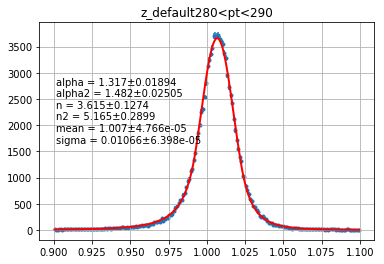

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.3456740396745126, 2.025091821587865, -0.6703412011735335, 7.468206705140473, 1.007214094984779, 0.015)


FCN = 2885.25554967 
 TOTAL NCALL = 306 
 NCALLS = 295 
 
 
 EDM = 5433.08045444 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00861 
 0.0134839 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.13983 
 0.232859 
 
 
 
 
 No 
 
 
 2 
 n 
 1.27401 
 0.0375629 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.81215 
 3.09944 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00618 
 4.64699e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00861 & 0.0134839 & & & & & No\\
\hline
1 & alpha2 & 2.13983 & 0.232859 & & & & & No\\
\hline
2 & n & 1.27401 & 0.0375629 & & & & & No\\
\hline
3 & n2 & 3.81215 & 3.09944 & & & & & No\\
\hline
4 & mean & 1.00618 & 4.64699e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1232.36253731 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 4.22520337757e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00861 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.13983 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.27401 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.81215 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00618 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0126751 
 3.64313e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00861 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.13983 & 1 & & & & & Yes\\
\hline
2 & n & 1.27401 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.81215 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00618 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0126751 & 3.64313e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 154.320279898 
 TOTAL NCALL = 305 
 NCALLS = 305 
 
 
 EDM = 2.20966798719e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35855 
 0.0185778 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.54429 
 0.0270534 
 
 
 
 
 No 
 
 
 2 
 n 
 2.68164 
 0.0839556 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.5197 
 0.25492 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0068 
 4.82467e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109862 
 6.37706e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35855 & 0.0185778 & & & & & No\\
\hline
1 & alpha2 & 1.54429 & 0.0270534 & & & & & No\\
\hline
2 & n & 2.68164 & 0.0839556 & & & & & No\\
\hline
3 & n2 & 4.5197 & 0.25492 & & & & & No\\
\hline
4 & mean & 1.0068 & 4.82467e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109862 & 6.37706e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


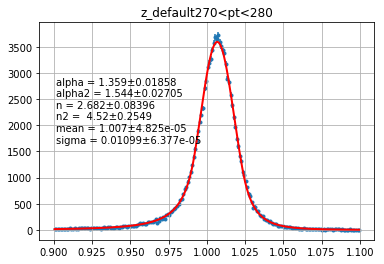

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.3462708231032776, 2.0552257196846826, -1.2832429779020185, 7.63297046377014, 1.007996309346563, 0.015)


FCN = 2979.28963092 
 TOTAL NCALL = 367 
 NCALLS = 356 
 
 
 EDM = 10903.1383016 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.11031 
 0.00748131 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.99614 
 0.213574 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00054 
 1.87986e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.24291 
 4.72798 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00613 
 4.5809e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.11031 & 0.00748131 & & & & & No\\
\hline
1 & alpha2 & 1.99614 & 0.213574 & & & & & No\\
\hline
2 & n & 1.00054 & 1.87986e-06 & & & & & No\\
\hline
3 & n2 & 5.24291 & 4.72798 & & & & & No\\
\hline
4 & mean & 1.00613 & 4.5809e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1097.26953205 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 2.9643483223e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.11031 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.99614 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00054 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.24291 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00613 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0125454 
 3.57752e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.11031 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.99614 & 1 & & & & & Yes\\
\hline
2 & n & 1.00054 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.24291 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00613 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0125454 & 3.57752e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 189.12383611 
 TOTAL NCALL = 391 
 NCALLS = 391 
 
 
 EDM = 5.38170981337e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.49625 
 0.0197052 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57735 
 0.0270147 
 
 
 
 
 No 
 
 
 2 
 n 
 2.15057 
 0.0668155 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.32251 
 0.24046 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.69548e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111053 
 6.01609e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.49625 & 0.0197052 & & & & & No\\
\hline
1 & alpha2 & 1.57735 & 0.0270147 & & & & & No\\
\hline
2 & n & 2.15057 & 0.0668155 & & & & & No\\
\hline
3 & n2 & 4.32251 & 0.24046 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.69548e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111053 & 6.01609e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


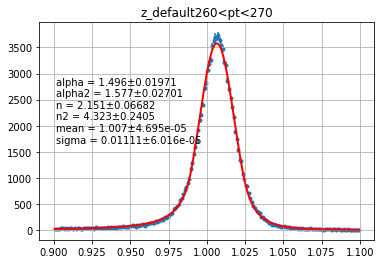

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.3345349697937794, 2.0675919470728914, -1.7058337135359416, 7.814544004949403, 1.0076537403517243, 0.015)


FCN = 2642.99636644 
 TOTAL NCALL = 291 
 NCALLS = 280 
 
 
 EDM = 4361.26954091 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.96672 
 0.01251 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.15938 
 0.24122 
 
 
 
 
 No 
 
 
 2 
 n 
 1.19896 
 0.0327771 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.81922 
 3.20145 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00595 
 4.66136e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.96672 & 0.01251 & & & & & No\\
\hline
1 & alpha2 & 2.15938 & 0.24122 & & & & & No\\
\hline
2 & n & 1.19896 & 0.0327771 & & & & & No\\
\hline
3 & n2 & 3.81922 & 3.20145 & & & & & No\\
\hline
4 & mean & 1.00595 & 4.66136e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1080.15065241 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.7098582566e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.96672 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.15938 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.19896 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.81922 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00595 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127291 
 3.66452e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.96672 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.15938 & 1 & & & & & Yes\\
\hline
2 & n & 1.19896 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.81922 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00595 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127291 & 3.66452e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 184.022758957 
 TOTAL NCALL = 274 
 NCALLS = 274 
 
 
 EDM = 2.20612064547e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41693 
 0.0194482 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50461 
 0.0257311 
 
 
 
 
 No 
 
 
 2 
 n 
 2.24149 
 0.0687504 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.1755 
 0.303574 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00652 
 4.86743e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110779 
 6.46776e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41693 & 0.0194482 & & & & & No\\
\hline
1 & alpha2 & 1.50461 & 0.0257311 & & & & & No\\
\hline
2 & n & 2.24149 & 0.0687504 & & & & & No\\
\hline
3 & n2 & 5.1755 & 0.303574 & & & & & No\\
\hline
4 & mean & 1.00652 & 4.86743e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110779 & 6.46776e-05 & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


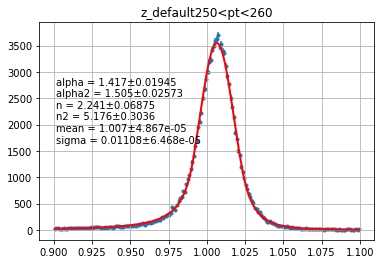

FCN = 2395.39748039 
 TOTAL NCALL = 361 
 NCALLS = 361 
 
 
 EDM = 3.29517691321e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94875 
 0.020515 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.35567 
 0.0322091 
 
 
 
 
 No 
 
 
 2 
 n 
 1.38261 
 0.0602261 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66163 
 0.13105 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.94077e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94875 & 0.020515 & & & & & No\\
\hline
1 & alpha2 & 2.35567 & 0.0322091 & & & & & No\\
\hline
2 & n & 1.38261 & 0.0602261 & & & & & No\\
\hline
3 & n2 & 1.66163 & 0.13105 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.94077e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.948754546751665, 2.35566579167621, 1.3826137711905953, 1.6616289164122722, 1.006057351647223, -0.018800189492158524)


FCN = 892.682992352 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 5.29660695068e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94875 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.35567 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.38261 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.66163 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127723 
 3.69138e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94875 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.35567 & 1 & & & & & Yes\\
\hline
2 & n & 1.38261 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.66163 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127723 & 3.69138e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 197.306805464 
 TOTAL NCALL = 266 
 NCALLS = 266 
 
 
 EDM = 2.03880465009e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38687 
 0.0197534 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.61866 
 0.0277926 
 
 
 
 
 No 
 
 
 2 
 n 
 2.60628 
 0.0854286 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.97505 
 0.219417 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00662 
 4.93727e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113424 
 6.41491e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38687 & 0.0197534 & & & & & No\\
\hline
1 & alpha2 & 1.61866 & 0.0277926 & & & & & No\\
\hline
2 & n & 2.60628 & 0.0854286 & & & & & No\\
\hline
3 & n2 & 3.97505 & 0.219417 & & & & & No\\
\hline
4 & mean & 1.00662 & 4.93727e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113424 & 6.41491e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


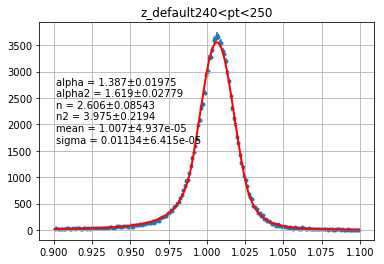

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.3379149870478586, 2.036798159067287, -2.844428730751071, 7.671086471125434, 1.0076791963362424, 0.015)


FCN = 2476.64007653 
 TOTAL NCALL = 538 
 NCALLS = 527 
 
 
 EDM = 559.11401501 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07481 
 0.00795213 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.04553 
 0.0788705 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00059 
 1.83276e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.93666 
 0.964403 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00586 
 5.01031e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07481 & 0.00795213 & & & & & No\\
\hline
1 & alpha2 & 2.04553 & 0.0788705 & & & & & No\\
\hline
2 & n & 1.00059 & 1.83276e-06 & & & & & No\\
\hline
3 & n2 & 3.93666 & 0.964403 & & & & & No\\
\hline
4 & mean & 1.00586 & 5.01031e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1032.86696224 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.91277666642e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07481 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.04553 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00059 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.93666 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00586 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127908 
 3.72139e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07481 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.04553 & 1 & & & & & Yes\\
\hline
2 & n & 1.00059 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.93666 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00586 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127908 & 3.72139e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1011.88243079 
 TOTAL NCALL = 116 
 NCALLS = 105 
 
 
 EDM = 89508.7058276 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07448 
 0.00575541 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.04465 
 0.157151 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00009 
 6.7045e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.82711 
 3.88321 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00586 
 3.85236e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127908 
 0.000114709 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07448 & 0.00575541 & & & & & No\\
\hline
1 & alpha2 & 2.04465 & 0.157151 & & & & & No\\
\hline
2 & n & 1.00009 & 6.7045e-07 & & & & & No\\
\hline
3 & n2 & 3.82711 & 3.88321 & & & & & No\\
\hline
4 & mean & 1.00586 & 3.85236e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127908 & 0.000114709 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


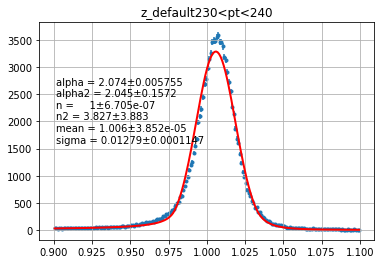

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.3164636083741692, 1.9817932743716218, -2.32845582942525, 7.545689212469716, 1.007731112448781, 0.015)


FCN = 2090.1683985 
 TOTAL NCALL = 373 
 NCALLS = 373 
 
 
 EDM = 4.40661646162e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90331 
 0.019334 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.32547 
 0.0325058 
 
 
 
 
 No 
 
 
 2 
 n 
 1.32345 
 0.0543375 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67897 
 0.132412 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.98773e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90331 & 0.019334 & & & & & No\\
\hline
1 & alpha2 & 2.32547 & 0.0325058 & & & & & No\\
\hline
2 & n & 1.32345 & 0.0543375 & & & & & No\\
\hline
3 & n2 & 1.67897 & 0.132412 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.98773e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 826.3688994 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 8.74009252322e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90331 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.32547 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.32345 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.67897 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0129171 
 3.79259e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90331 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.32547 & 1 & & & & & Yes\\
\hline
2 & n & 1.32345 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.67897 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0129171 & 3.79259e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 214.688716121 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 4.87404022891e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39037 
 0.020313 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.59728 
 0.0257802 
 
 
 
 
 No 
 
 
 2 
 n 
 2.38329 
 0.0785098 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.06997 
 0.216401 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00658 
 5.09703e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115055 
 6.51824e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39037 & 0.020313 & & & & & No\\
\hline
1 & alpha2 & 1.59728 & 0.0257802 & & & & & No\\
\hline
2 & n & 2.38329 & 0.0785098 & & & & & No\\
\hline
3 & n2 & 4.06997 & 0.216401 & & & & & No\\
\hline
4 & mean & 1.00658 & 5.09703e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115055 & 6.51824e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


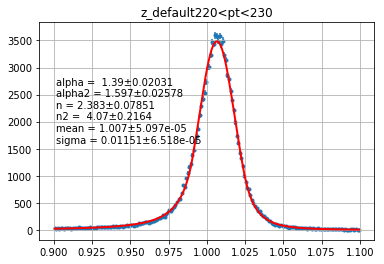

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.2911096598921805, 1.973616459712521, -1.7248670416896665, 7.53500688531815, 1.0081570091010223, 0.015)


FCN = 2149.73556533 
 TOTAL NCALL = 428 
 NCALLS = 417 
 
 
 EDM = 254.983930337 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03606 
 0.00768007 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.98777 
 0.0493275 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00032 
 1.5923e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.83033 
 0.572323 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00648 
 4.99796e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03606 & 0.00768007 & & & & & No\\
\hline
1 & alpha2 & 1.98777 & 0.0493275 & & & & & No\\
\hline
2 & n & 1.00032 & 1.5923e-06 & & & & & No\\
\hline
3 & n2 & 3.83033 & 0.572323 & & & & & No\\
\hline
4 & mean & 1.00648 & 4.99796e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 928.511441588 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.63489450999e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03606 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.98777 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00032 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.83033 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00648 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0129448 
 3.80791e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03606 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.98777 & 1 & & & & & Yes\\
\hline
2 & n & 1.00032 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.83033 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00648 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0129448 & 3.80791e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 921.737618127 
 TOTAL NCALL = 116 
 NCALLS = 105 
 
 
 EDM = 48624.291219 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0358 
 0.00649004 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.98709 
 0.156175 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00004 
 6.79825e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.8005 
 3.10472 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00648 
 3.62469e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0129448 
 0.000108424 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0358 & 0.00649004 & & & & & No\\
\hline
1 & alpha2 & 1.98709 & 0.156175 & & & & & No\\
\hline
2 & n & 1.00004 & 6.79825e-07 & & & & & No\\
\hline
3 & n2 & 3.8005 & 3.10472 & & & & & No\\
\hline
4 & mean & 1.00648 & 3.62469e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0129448 & 0.000108424 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


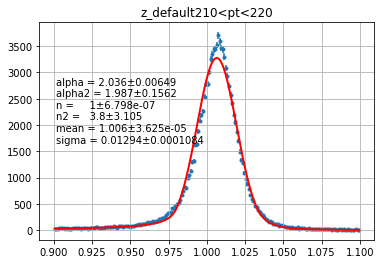

FCN = 1846.54150817 
 TOTAL NCALL = 373 
 NCALLS = 373 
 
 
 EDM = 3.50202164004e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83531 
 0.0193153 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.2765 
 0.0307642 
 
 
 
 
 No 
 
 
 2 
 n 
 1.4391 
 0.0578346 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.72693 
 0.128691 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00682 
 5.09271e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83531 & 0.0193153 & & & & & No\\
\hline
1 & alpha2 & 2.2765 & 0.0307642 & & & & & No\\
\hline
2 & n & 1.4391 & 0.0578346 & & & & & No\\
\hline
3 & n2 & 1.72693 & 0.128691 & & & & & No\\
\hline
4 & mean & 1.00682 & 5.09271e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.8353050492819862, 2.2765033951703435, 1.439098597742002, 1.726933036627411, 1.0068190419216103, -0.014677228961751415)


FCN = 756.185647577 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.44020009247e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83531 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.2765 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.4391 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.72693 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00682 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0130215 
 3.89495e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83531 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.2765 & 1 & & & & & Yes\\
\hline
2 & n & 1.4391 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.72693 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00682 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0130215 & 3.89495e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 177.857019974 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 3.51629563319e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32313 
 0.0192191 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.63098 
 0.0265316 
 
 
 
 
 No 
 
 
 2 
 n 
 2.5694 
 0.0832258 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.66266 
 0.192741 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.27619e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115845 
 6.64377e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32313 & 0.0192191 & & & & & No\\
\hline
1 & alpha2 & 1.63098 & 0.0265316 & & & & & No\\
\hline
2 & n & 2.5694 & 0.0832258 & & & & & No\\
\hline
3 & n2 & 3.66266 & 0.192741 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.27619e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115845 & 6.64377e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


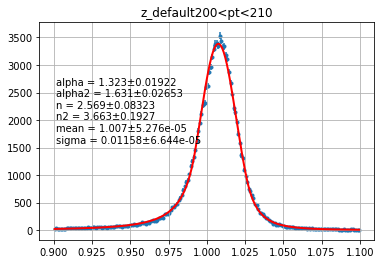

FCN = 1653.59632535 
 TOTAL NCALL = 334 
 NCALLS = 334 
 
 
 EDM = 5.24732863244e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.80847 
 0.0190615 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.1624 
 0.0279072 
 
 
 
 
 No 
 
 
 2 
 n 
 1.52094 
 0.0595919 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.80572 
 0.120259 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 5.15157e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.80847 & 0.0190615 & & & & & No\\
\hline
1 & alpha2 & 2.1624 & 0.0279072 & & & & & No\\
\hline
2 & n & 1.52094 & 0.0595919 & & & & & No\\
\hline
3 & n2 & 1.80572 & 0.120259 & & & & & No\\
\hline
4 & mean & 1.00707 & 5.15157e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.8084663515593902, 2.1623967416961003, 1.5209405122072897, 1.8057241154916328, 1.007069474284388, -0.013084417336803312)


FCN = 772.868178293 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.57498802968e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.80847 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.1624 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.52094 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.80572 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00707 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.013187 
 4.005e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.80847 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.1624 & 1 & & & & & Yes\\
\hline
2 & n & 1.52094 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.80572 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00707 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.013187 & 4.005e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 206.208230742 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 4.21251779553e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.283 
 0.0198065 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57676 
 0.0239633 
 
 
 
 
 No 
 
 
 2 
 n 
 2.76024 
 0.0931356 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.48334 
 0.166099 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00773 
 5.53088e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0116316 
 7.05631e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.283 & 0.0198065 & & & & & No\\
\hline
1 & alpha2 & 1.57676 & 0.0239633 & & & & & No\\
\hline
2 & n & 2.76024 & 0.0931356 & & & & & No\\
\hline
3 & n2 & 3.48334 & 0.166099 & & & & & No\\
\hline
4 & mean & 1.00773 & 5.53088e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0116316 & 7.05631e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


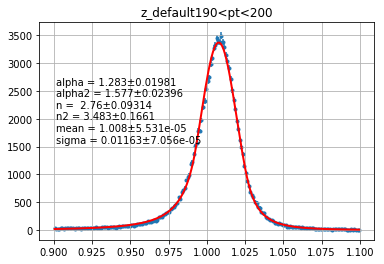

FCN = 1310.84475934 
 TOTAL NCALL = 316 
 NCALLS = 316 
 
 
 EDM = 1.06320835274e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74075 
 0.0189663 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.09914 
 0.0282777 
 
 
 
 
 No 
 
 
 2 
 n 
 1.65667 
 0.0642202 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.91395 
 0.127534 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00738 
 5.27077e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74075 & 0.0189663 & & & & & No\\
\hline
1 & alpha2 & 2.09914 & 0.0282777 & & & & & No\\
\hline
2 & n & 1.65667 & 0.0642202 & & & & & No\\
\hline
3 & n2 & 1.91395 & 0.127534 & & & & & No\\
\hline
4 & mean & 1.00738 & 5.27077e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.7407457361344705, 2.099142846188696, 1.6566707250918564, 1.913953969674176, 1.0073767639668014, -0.010005955969037268)


FCN = 688.881832212 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.01298302719e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74075 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.09914 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.65667 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.91395 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00738 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0134446 
 4.14349e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74075 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.09914 & 1 & & & & & Yes\\
\hline
2 & n & 1.65667 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.91395 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00738 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0134446 & 4.14349e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 207.793429387 
 TOTAL NCALL = 252 
 NCALLS = 252 
 
 
 EDM = 4.02592630878e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24413 
 0.0197016 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.56387 
 0.025619 
 
 
 
 
 No 
 
 
 2 
 n 
 2.93726 
 0.102479 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.49952 
 0.177912 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 5.76815e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0118911 
 7.60617e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24413 & 0.0197016 & & & & & No\\
\hline
1 & alpha2 & 1.56387 & 0.025619 & & & & & No\\
\hline
2 & n & 2.93726 & 0.102479 & & & & & No\\
\hline
3 & n2 & 3.49952 & 0.177912 & & & & & No\\
\hline
4 & mean & 1.00805 & 5.76815e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0118911 & 7.60617e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


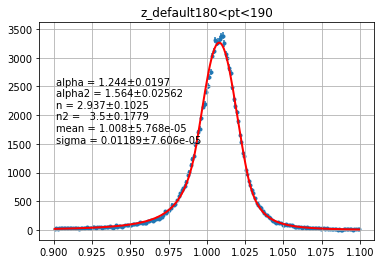

FCN = 1109.68184677 
 TOTAL NCALL = 315 
 NCALLS = 315 
 
 
 EDM = 3.20938799638e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72554 
 0.0191231 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.94734 
 0.0267022 
 
 
 
 
 No 
 
 
 2 
 n 
 1.64493 
 0.0636669 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50365 
 0.159301 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00784 
 5.39772e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72554 & 0.0191231 & & & & & No\\
\hline
1 & alpha2 & 1.94734 & 0.0267022 & & & & & No\\
\hline
2 & n & 1.64493 & 0.0636669 & & & & & No\\
\hline
3 & n2 & 2.50365 & 0.159301 & & & & & No\\
\hline
4 & mean & 1.00784 & 5.39772e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.725543122426967, 1.9473410711169596, 1.6449281441772077, 2.503653754804121, 1.0078369448211326, -0.008008170153122711)


FCN = 613.326504596 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.40293187351e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72554 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.94734 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.64493 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.50365 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00784 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0135885 
 4.22328e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72554 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.94734 & 1 & & & & & Yes\\
\hline
2 & n & 1.64493 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.50365 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00784 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0135885 & 4.22328e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 169.656524924 
 TOTAL NCALL = 270 
 NCALLS = 270 
 
 
 EDM = 3.43184321679e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26519 
 0.0195066 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.45578 
 0.0245226 
 
 
 
 
 No 
 
 
 2 
 n 
 2.77787 
 0.0940358 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.1923 
 0.226108 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00835 
 5.72089e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0120154 
 7.8661e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26519 & 0.0195066 & & & & & No\\
\hline
1 & alpha2 & 1.45578 & 0.0245226 & & & & & No\\
\hline
2 & n & 2.77787 & 0.0940358 & & & & & No\\
\hline
3 & n2 & 4.1923 & 0.226108 & & & & & No\\
\hline
4 & mean & 1.00835 & 5.72089e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0120154 & 7.8661e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


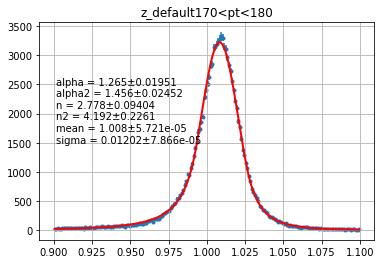

FCN = 859.814163152 
 TOTAL NCALL = 318 
 NCALLS = 318 
 
 
 EDM = 1.76415331673e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.70835 
 0.0182078 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.01058 
 0.0271025 
 
 
 
 
 No 
 
 
 2 
 n 
 1.68019 
 0.0623677 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96448 
 0.123996 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00853 
 5.32198e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.70835 & 0.0182078 & & & & & No\\
\hline
1 & alpha2 & 2.01058 & 0.0271025 & & & & & No\\
\hline
2 & n & 1.68019 & 0.0623677 & & & & & No\\
\hline
3 & n2 & 1.96448 & 0.123996 & & & & & No\\
\hline
4 & mean & 1.00853 & 5.32198e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.7083535693402212, 2.010576909981475, 1.680186602956052, 1.9644846028090575, 1.00853236677244, -0.005254128266016966)


FCN = 474.611184983 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 7.97478230198e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.70835 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.01058 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.68019 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.96448 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00853 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.013759 
 4.25266e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.70835 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.01058 & 1 & & & & & Yes\\
\hline
2 & n & 1.68019 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.96448 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00853 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.013759 & 4.25266e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 161.277735443 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 6.92148956877e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3367 
 0.0193909 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50526 
 0.0266949 
 
 
 
 
 No 
 
 
 2 
 n 
 2.54795 
 0.0853579 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.75073 
 0.208188 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00885 
 5.59543e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0124493 
 7.66906e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3367 & 0.0193909 & & & & & No\\
\hline
1 & alpha2 & 1.50526 & 0.0266949 & & & & & No\\
\hline
2 & n & 2.54795 & 0.0853579 & & & & & No\\
\hline
3 & n2 & 3.75073 & 0.208188 & & & & & No\\
\hline
4 & mean & 1.00885 & 5.59543e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0124493 & 7.66906e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


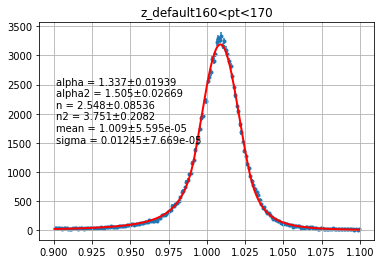

FCN = 614.805887626 
 TOTAL NCALL = 329 
 NCALLS = 329 
 
 
 EDM = 1.52559475208e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.62381 
 0.0182795 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.86459 
 0.0257397 
 
 
 
 
 No 
 
 
 2 
 n 
 1.7986 
 0.0662467 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.16647 
 0.129503 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00896 
 5.63794e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.62381 & 0.0182795 & & & & & No\\
\hline
1 & alpha2 & 1.86459 & 0.0257397 & & & & & No\\
\hline
2 & n & 1.7986 & 0.0662467 & & & & & No\\
\hline
3 & n2 & 2.16647 & 0.129503 & & & & & No\\
\hline
4 & mean & 1.00896 & 5.63794e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.6238088215272852, 1.8645926898160532, 1.7985963797846765, 2.166466057486132, 1.0089573863646555, -0.002128942638270726)


FCN = 408.433578218 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.54246451026e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.62381 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.86459 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.7986 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.16647 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00896 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0140465 
 4.52459e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.62381 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.86459 & 1 & & & & & Yes\\
\hline
2 & n & 1.7986 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.16647 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00896 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0140465 & 4.52459e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 182.397568022 
 TOTAL NCALL = 234 
 NCALLS = 234 
 
 
 EDM = 9.04500610569e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30756 
 0.0190296 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46328 
 0.0247481 
 
 
 
 
 No 
 
 
 2 
 n 
 2.56769 
 0.0864269 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.59795 
 0.191125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00923 
 5.87914e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.012812 
 7.94987e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30756 & 0.0190296 & & & & & No\\
\hline
1 & alpha2 & 1.46328 & 0.0247481 & & & & & No\\
\hline
2 & n & 2.56769 & 0.0864269 & & & & & No\\
\hline
3 & n2 & 3.59795 & 0.191125 & & & & & No\\
\hline
4 & mean & 1.00923 & 5.87914e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.012812 & 7.94987e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


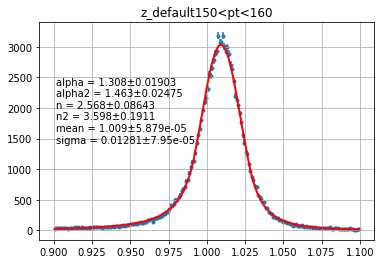

FCN = 329.756830665 
 TOTAL NCALL = 306 
 NCALLS = 306 
 
 
 EDM = 1.07060354943e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5797 
 0.0181346 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.6431 
 0.0243552 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95366 
 0.0722929 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.03975 
 0.185818 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 5.97092e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5797 & 0.0181346 & & & & & No\\
\hline
1 & alpha2 & 1.6431 & 0.0243552 & & & & & No\\
\hline
2 & n & 1.95366 & 0.0722929 & & & & & No\\
\hline
3 & n2 & 3.03975 & 0.185818 & & & & & No\\
\hline
4 & mean & 1.00934 & 5.97092e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 270.835025495 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 2.62124190941e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5797 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.6431 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.95366 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.03975 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00934 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0144804 
 4.69238e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5797 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.6431 & 1 & & & & & Yes\\
\hline
2 & n & 1.95366 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.03975 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00934 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0144804 & 4.69238e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 178.305073443 
 TOTAL NCALL = 233 
 NCALLS = 233 
 
 
 EDM = 7.55859377525e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36585 
 0.0210224 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.36265 
 0.0266489 
 
 
 
 
 No 
 
 
 2 
 n 
 2.50187 
 0.0926274 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.5302 
 0.297207 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00938 
 6.29013e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.013539 
 9.13947e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36585 & 0.0210224 & & & & & No\\
\hline
1 & alpha2 & 1.36265 & 0.0266489 & & & & & No\\
\hline
2 & n & 2.50187 & 0.0926274 & & & & & No\\
\hline
3 & n2 & 4.5302 & 0.297207 & & & & & No\\
\hline
4 & mean & 1.00938 & 6.29013e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.013539 & 9.13947e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


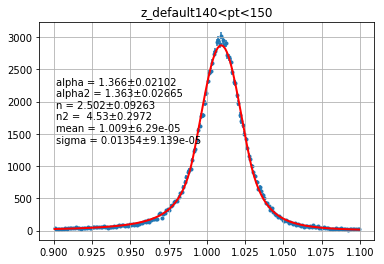

FCN = 277.799879961 
 TOTAL NCALL = 303 
 NCALLS = 303 
 
 
 EDM = 3.42191224002e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.53505 
 0.0179608 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.522 
 0.0220186 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9685 
 0.0721081 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.04511 
 0.172116 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00966 
 6.27515e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.53505 & 0.0179608 & & & & & No\\
\hline
1 & alpha2 & 1.522 & 0.0220186 & & & & & No\\
\hline
2 & n & 1.9685 & 0.0721081 & & & & & No\\
\hline
3 & n2 & 3.04511 & 0.172116 & & & & & No\\
\hline
4 & mean & 1.00966 & 6.27515e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 248.117676467 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 4.25318535623e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.53505 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.522 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.9685 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.04511 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00966 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0146146 
 4.93109e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.53505 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.522 & 1 & & & & & Yes\\
\hline
2 & n & 1.9685 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.04511 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00966 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0146146 & 4.93109e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 187.308806587 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 1.73578790246e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36197 
 0.0218584 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28401 
 0.0254125 
 
 
 
 
 No 
 
 
 2 
 n 
 2.39394 
 0.0904377 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.35344 
 0.273231 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0096 
 6.63383e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0137286 
 0.000100954 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36197 & 0.0218584 & & & & & No\\
\hline
1 & alpha2 & 1.28401 & 0.0254125 & & & & & No\\
\hline
2 & n & 2.39394 & 0.0904377 & & & & & No\\
\hline
3 & n2 & 4.35344 & 0.273231 & & & & & No\\
\hline
4 & mean & 1.0096 & 6.63383e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0137286 & 0.000100954 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


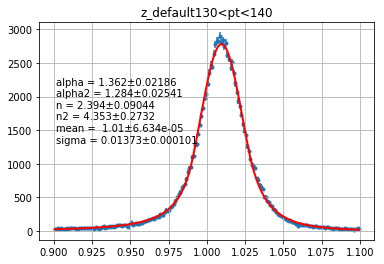

FCN = 210.069018753 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 1.64921885199e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40428 
 0.0172858 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.29961 
 0.0193754 
 
 
 
 
 No 
 
 
 2 
 n 
 2.3524 
 0.0876468 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.28843 
 0.377546 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01017 
 6.9191e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40428 & 0.0172858 & & & & & No\\
\hline
1 & alpha2 & 1.29961 & 0.0193754 & & & & & No\\
\hline
2 & n & 2.3524 & 0.0876468 & & & & & No\\
\hline
3 & n2 & 5.28843 & 0.377546 & & & & & No\\
\hline
4 & mean & 1.01017 & 6.9191e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 204.719819585 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 7.59085395579e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40428 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.29961 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.3524 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.28843 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01017 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0148354 
 5.00132e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40428 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.29961 & 1 & & & & & Yes\\
\hline
2 & n & 2.3524 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.28843 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01017 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0148354 & 5.00132e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 186.450630752 
 TOTAL NCALL = 222 
 NCALLS = 222 
 
 
 EDM = 6.96927363247e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31024 
 0.0215482 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1673 
 0.0260714 
 
 
 
 
 No 
 
 
 2 
 n 
 2.60467 
 0.101183 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.86343 
 0.615869 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01008 
 7.35859e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0142326 
 0.000117283 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31024 & 0.0215482 & & & & & No\\
\hline
1 & alpha2 & 1.1673 & 0.0260714 & & & & & No\\
\hline
2 & n & 2.60467 & 0.101183 & & & & & No\\
\hline
3 & n2 & 6.86343 & 0.615869 & & & & & No\\
\hline
4 & mean & 1.01008 & 7.35859e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0142326 & 0.000117283 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


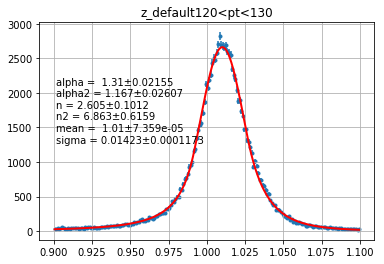

FCN = 212.816412833 
 TOTAL NCALL = 277 
 NCALLS = 277 
 
 
 EDM = 5.96209487517e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28323 
 0.0161656 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1889 
 0.0176209 
 
 
 
 
 No 
 
 
 2 
 n 
 2.76194 
 0.105061 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.77849 
 0.425462 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00993 
 7.47642e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28323 & 0.0161656 & & & & & No\\
\hline
1 & alpha2 & 1.1889 & 0.0176209 & & & & & No\\
\hline
2 & n & 2.76194 & 0.105061 & & & & & No\\
\hline
3 & n2 & 5.77849 & 0.425462 & & & & & No\\
\hline
4 & mean & 1.00993 & 7.47642e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 211.597118812 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 2.49775325031e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28323 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.1889 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.76194 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.77849 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00993 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0149194 
 5.12052e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28323 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.1889 & 1 & & & & & Yes\\
\hline
2 & n & 2.76194 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.77849 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00993 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0149194 & 5.12052e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 205.413303789 
 TOTAL NCALL = 205 
 NCALLS = 205 
 
 
 EDM = 2.06795404743e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2239 
 0.0219511 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.11466 
 0.0250171 
 
 
 
 
 No 
 
 
 2 
 n 
 2.95174 
 0.121913 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.70872 
 0.585972 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00988 
 7.72056e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0145002 
 0.000132876 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2239 & 0.0219511 & & & & & No\\
\hline
1 & alpha2 & 1.11466 & 0.0250171 & & & & & No\\
\hline
2 & n & 2.95174 & 0.121913 & & & & & No\\
\hline
3 & n2 & 6.70872 & 0.585972 & & & & & No\\
\hline
4 & mean & 1.00988 & 7.72056e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0145002 & 0.000132876 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


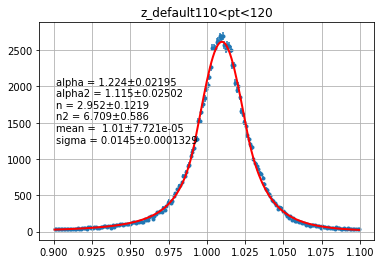

FCN = 11355.3025892 
 TOTAL NCALL = 76 
 NCALLS = 65 
 
 
 EDM = 28879.6682562 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00369434 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.074257 
 
 
 
 
 No 
 
 
 2 
 n 
 10 
 0.221478 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.49114 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 0.000136641 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00369434 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.074257 & & & & & No\\
\hline
2 & n & 10 & 0.221478 & & & & & No\\
\hline
3 & n2 & 4 & 1.49114 & & & & & No\\
\hline
4 & mean & 0.999 & 0.000136641 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, 10.0, 4.0, 0.999, -0.05858578660469785)


FCN = 11065.8506665 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 2.63516005276e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 10 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.999 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0163516 
 5.9265e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 10 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 0.999 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0163516 & 5.9265e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 160.823599663 
 TOTAL NCALL = 354 
 NCALLS = 354 
 
 
 EDM = 6.30544451388e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26228 
 0.0222029 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24999 
 0.0275647 
 
 
 
 
 No 
 
 
 2 
 n 
 3.04195 
 0.141103 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.1138 
 0.30455 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0091 
 7.93735e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0157686 
 0.000123875 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26228 & 0.0222029 & & & & & No\\
\hline
1 & alpha2 & 1.24999 & 0.0275647 & & & & & No\\
\hline
2 & n & 3.04195 & 0.141103 & & & & & No\\
\hline
3 & n2 & 4.1138 & 0.30455 & & & & & No\\
\hline
4 & mean & 1.0091 & 7.93735e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0157686 & 0.000123875 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


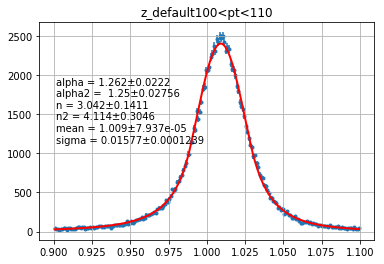

FCN = 188.120785842 
 TOTAL NCALL = 337 
 NCALLS = 337 
 
 
 EDM = 9.2073289432e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13695 
 0.0161022 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.81345 
 0.0120958 
 
 
 
 
 No 
 
 
 2 
 n 
 3.50503 
 0.16154 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.1518 
 2.1905 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00665 
 9.75795e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13695 & 0.0161022 & & & & & No\\
\hline
1 & alpha2 & 0.81345 & 0.0120958 & & & & & No\\
\hline
2 & n & 3.50503 & 0.16154 & & & & & No\\
\hline
3 & n2 & 14.1518 & 2.1905 & & & & & No\\
\hline
4 & mean & 1.00665 & 9.75795e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 183.795530518 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 7.30223892579e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13695 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.81345 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.50503 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.1518 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00665 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151578 
 5.40307e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13695 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.81345 & 1 & & & & & Yes\\
\hline
2 & n & 3.50503 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.1518 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00665 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151578 & 5.40307e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 138.163960768 
 TOTAL NCALL = 316 
 NCALLS = 316 
 
 
 EDM = 4.35945730949e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30834 
 0.0237397 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.991117 
 0.023578 
 
 
 
 
 No 
 
 
 2 
 n 
 2.88134 
 0.143359 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.44877 
 0.828277 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0071 
 9.83558e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0166564 
 0.000150464 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30834 & 0.0237397 & & & & & No\\
\hline
1 & alpha2 & 0.991117 & 0.023578 & & & & & No\\
\hline
2 & n & 2.88134 & 0.143359 & & & & & No\\
\hline
3 & n2 & 7.44877 & 0.828277 & & & & & No\\
\hline
4 & mean & 1.0071 & 9.83558e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0166564 & 0.000150464 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


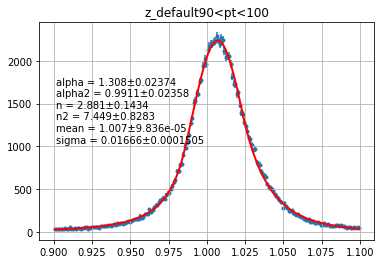

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0101071723494417, 0.8770821641413801, -10.632661789645496, 2.398327858122611, 1.0057621619579096, 0.015)


FCN = 258.829439231 
 TOTAL NCALL = 444 
 NCALLS = 433 
 
 
 EDM = 2.81591013716 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.06715 
 0.0204475 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.646587 
 0.00398193 
 
 
 
 
 No 
 
 
 2 
 n 
 3.8938 
 0.260871 
 
 
 
 
 No 
 
 
 3 
 n2 
 132.55 
 35.5189 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 0.000110373 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.06715 & 0.0204475 & & & & & No\\
\hline
1 & alpha2 & 0.646587 & 0.00398193 & & & & & No\\
\hline
2 & n & 3.8938 & 0.260871 & & & & & No\\
\hline
3 & n2 & 132.55 & 35.5189 & & & & & No\\
\hline
4 & mean & 1.004 & 0.000110373 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 251.660811747 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 4.66218802588e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.06715 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.646587 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.8938 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 132.55 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0152056 
 5.48821e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.06715 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.646587 & 1 & & & & & Yes\\
\hline
2 & n & 3.8938 & 1 & & & & & Yes\\
\hline
3 & n2 & 132.55 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0152056 & 5.48821e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 251.660811747 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 75.4771144093 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.06715 
 0.0256952 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.646587 
 0.0113125 
 
 
 
 
 No 
 
 
 2 
 n 
 3.8938 
 0.222436 
 
 
 
 
 No 
 
 
 3 
 n2 
 132.55 
 27.8249 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 0.000118038 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0152056 
 0.000215738 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.06715 & 0.0256952 & & & & & No\\
\hline
1 & alpha2 & 0.646587 & 0.0113125 & & & & & No\\
\hline
2 & n & 3.8938 & 0.222436 & & & & & No\\
\hline
3 & n2 & 132.55 & 27.8249 & & & & & No\\
\hline
4 & mean & 1.004 & 0.000118038 & & & & & No\\
\hline
5 & $\sigma$ & 0.0152056 & 0.000215738 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


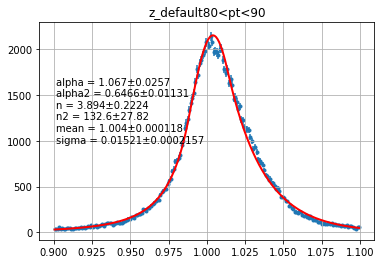

FCN = 5418.05109304 
 TOTAL NCALL = 124 
 NCALLS = 113 
 
 
 EDM = 32066.7388329 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00491798 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0668113 
 
 
 
 
 No 
 
 
 2 
 n 
 5.46934 
 0.139473 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.12821 
 0.560795 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 7.52855e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00491798 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0668113 & & & & & No\\
\hline
2 & n & 5.46934 & 0.139473 & & & & & No\\
\hline
3 & n2 & 2.12821 & 0.560795 & & & & & No\\
\hline
4 & mean & 0.999 & 7.52855e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, 5.46933684221841, 2.1282103512816968, 0.999, -0.035830760340308895)


FCN = 4358.32467204 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 3.04390147532e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.46934 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.12821 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.999 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0182924 
 8.04021e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 5.46934 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.12821 & 1 & & & & & Yes\\
\hline
4 & mean & 0.999 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0182924 & 8.04021e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 163.440014936 
 TOTAL NCALL = 523 
 NCALLS = 512 
 
 
 EDM = 0.221387458497 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18189 
 0.0281578 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.833841 
 0.0155072 
 
 
 
 
 No 
 
 
 2 
 n 
 3.504 
 0.253912 
 
 
 
 
 No 
 
 
 3 
 n2 
 130.705 
 101.401 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00608 
 0.0001219 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0196055 
 0.000224191 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18189 & 0.0281578 & & & & & No\\
\hline
1 & alpha2 & 0.833841 & 0.0155072 & & & & & No\\
\hline
2 & n & 3.504 & 0.253912 & & & & & No\\
\hline
3 & n2 & 130.705 & 101.401 & & & & & No\\
\hline
4 & mean & 1.00608 & 0.0001219 & & & & & No\\
\hline
5 & $\sigma$ & 0.0196055 & 0.000224191 & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


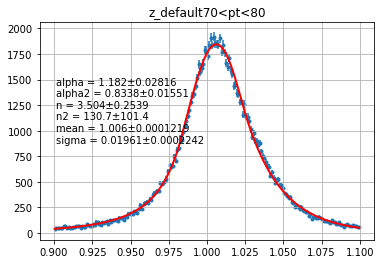

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, -0.05652195213779798, 4.0, 0.999, 0.015)


FCN = 265.959201782 
 TOTAL NCALL = 476 
 NCALLS = 465 
 
 
 EDM = 0.406793359748 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.59583 
 0.00349517 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.527968 
 0.00355341 
 
 
 
 
 No 
 
 
 2 
 n 
 103.854 
 3.58775 
 
 
 
 
 No 
 
 
 3 
 n2 
 119.239 
 29.792 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 0.0001375 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.59583 & 0.00349517 & & & & & No\\
\hline
1 & alpha2 & 0.527968 & 0.00355341 & & & & & No\\
\hline
2 & n & 103.854 & 3.58775 & & & & & No\\
\hline
3 & n2 & 119.239 & 29.792 & & & & & No\\
\hline
4 & mean & 1.00654 & 0.0001375 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 265.370682212 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 8.3986324273e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.59583 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.527968 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 103.854 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 119.239 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00654 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150615 
 5.67711e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.59583 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.527968 & 1 & & & & & Yes\\
\hline
2 & n & 103.854 & 1 & & & & & Yes\\
\hline
3 & n2 & 119.239 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00654 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150615 & 5.67711e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 264.422093374 
 TOTAL NCALL = 112 
 NCALLS = 101 
 
 
 EDM = 543.679654758 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.597407 
 0.00323316 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.527612 
 0.00264799 
 
 
 
 
 No 
 
 
 2 
 n 
 54.5153 
 31.8504 
 
 
 
 
 No 
 
 
 3 
 n2 
 118.768 
 23.7147 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 8.46176e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150444 
 5.90401e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.597407 & 0.00323316 & & & & & No\\
\hline
1 & alpha2 & 0.527612 & 0.00264799 & & & & & No\\
\hline
2 & n & 54.5153 & 31.8504 & & & & & No\\
\hline
3 & n2 & 118.768 & 23.7147 & & & & & No\\
\hline
4 & mean & 1.00655 & 8.46176e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150444 & 5.90401e-05 & & & & & No\\
\hline
\end{tabular}

60<pt<70
24


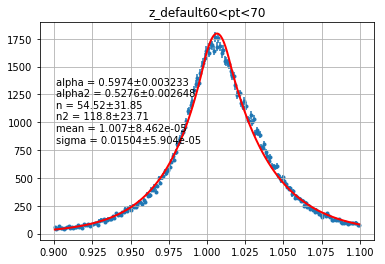

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, 0.6777061806681406, 4.0, 0.999, 0.015)


FCN = 219.778857581 
 TOTAL NCALL = 422 
 NCALLS = 411 
 
 
 EDM = 5.23301443904 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.549901 
 0.00404366 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.41691 
 0.00355771 
 
 
 
 
 No 
 
 
 2 
 n 
 124.706 
 43.5142 
 
 
 
 
 No 
 
 
 3 
 n2 
 36.234 
 6.39538 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00463 
 0.000173131 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.549901 & 0.00404366 & & & & & No\\
\hline
1 & alpha2 & 0.41691 & 0.00355771 & & & & & No\\
\hline
2 & n & 124.706 & 43.5142 & & & & & No\\
\hline
3 & n2 & 36.234 & 6.39538 & & & & & No\\
\hline
4 & mean & 1.00463 & 0.000173131 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 219.736525856 
 TOTAL NCALL = 18 
 NCALLS = 18 
 
 
 EDM = 3.45161087361e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.549901 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.41691 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 124.706 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 36.234 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00463 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0149819 
 6.40431e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.549901 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.41691 & 1 & & & & & Yes\\
\hline
2 & n & 124.706 & 1 & & & & & Yes\\
\hline
3 & n2 & 36.234 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00463 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0149819 & 6.40431e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 136.789717649 
 TOTAL NCALL = 305 
 NCALLS = 294 
 
 
 EDM = 0.123257462151 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.848107 
 0.019196 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.613578 
 0.0137462 
 
 
 
 
 No 
 
 
 2 
 n 
 22.9965 
 5.68069 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.056 
 25.3954 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0056 
 0.00016978 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0215551 
 0.00038703 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.848107 & 0.019196 & & & & & No\\
\hline
1 & alpha2 & 0.613578 & 0.0137462 & & & & & No\\
\hline
2 & n & 22.9965 & 5.68069 & & & & & No\\
\hline
3 & n2 & 124.056 & 25.3954 & & & & & No\\
\hline
4 & mean & 1.0056 & 0.00016978 & & & & & No\\
\hline
5 & $\sigma$ & 0.0215551 & 0.00038703 & & & & & No\\
\hline
\end{tabular}

50<pt<60
25


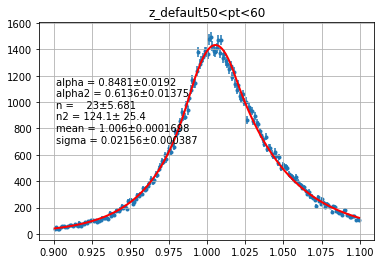

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, -4.917465528793176, 4.0, 0.999, 0.015)


FCN = 832.413875531 
 TOTAL NCALL = 556 
 NCALLS = 556 
 
 
 EDM = 2.45610552862e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.624685 
 0.00755606 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.290047 
 0.00313479 
 
 
 
 
 No 
 
 
 2 
 n 
 3.52875 
 0.0731774 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.3137 
 1.21034 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00026 
 0.000238839 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.624685 & 0.00755606 & & & & & No\\
\hline
1 & alpha2 & 0.290047 & 0.00313479 & & & & & No\\
\hline
2 & n & 3.52875 & 0.0731774 & & & & & No\\
\hline
3 & n2 & 14.3137 & 1.21034 & & & & & No\\
\hline
4 & mean & 1.00026 & 0.000238839 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 832.001319693 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 5.61653335526e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.624685 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.290047 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.52875 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.3137 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00026 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150498 
 5.48625e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.624685 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.290047 & 1 & & & & & Yes\\
\hline
2 & n & 3.52875 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.3137 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00026 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150498 & 5.48625e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 636.476400814 
 TOTAL NCALL = 316 
 NCALLS = 305 
 
 
 EDM = 79.4709149888 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22134 
 0.0292286 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.541093 
 0.0120113 
 
 
 
 
 No 
 
 
 2 
 n 
 2.67136 
 0.0855931 
 
 
 
 
 No 
 
 
 3 
 n2 
 17.9488 
 1.9001 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00449 
 0.000280228 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0286796 
 0.000507898 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22134 & 0.0292286 & & & & & No\\
\hline
1 & alpha2 & 0.541093 & 0.0120113 & & & & & No\\
\hline
2 & n & 2.67136 & 0.0855931 & & & & & No\\
\hline
3 & n2 & 17.9488 & 1.9001 & & & & & No\\
\hline
4 & mean & 1.00449 & 0.000280228 & & & & & No\\
\hline
5 & $\sigma$ & 0.0286796 & 0.000507898 & & & & & No\\
\hline
\end{tabular}

40<pt<50
26


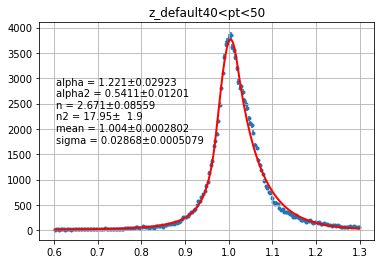

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, -0.5246210778789546, 4.0, 0.999, 0.015)


FCN = 611.191603626 
 TOTAL NCALL = 490 
 NCALLS = 490 
 
 
 EDM = 7.48036582481e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269683 
 0.00269447 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.427787 
 0.0077786 
 
 
 
 
 No 
 
 
 2 
 n 
 16.7418 
 1.30542 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.67579 
 0.0839211 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03984 
 0.000346071 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269683 & 0.00269447 & & & & & No\\
\hline
1 & alpha2 & 0.427787 & 0.0077786 & & & & & No\\
\hline
2 & n & 16.7418 & 1.30542 & & & & & No\\
\hline
3 & n2 & 2.67579 & 0.0839211 & & & & & No\\
\hline
4 & mean & 1.03984 & 0.000346071 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 611.128585317 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 6.01191273762e-12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269683 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.427787 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 16.7418 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.67579 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.03984 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150202 
 5.70748e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269683 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.427787 & 1 & & & & & Yes\\
\hline
2 & n & 16.7418 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.67579 & 1 & & & & & Yes\\
\hline
4 & mean & 1.03984 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150202 & 5.70748e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 338.866240044 
 TOTAL NCALL = 448 
 NCALLS = 448 
 
 
 EDM = 9.63087032254e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.822932 
 0.0206272 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08725 
 0.0200144 
 
 
 
 
 No 
 
 
 2 
 n 
 7.12074 
 0.389354 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.82105 
 0.0662812 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03417 
 0.000311488 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0389765 
 0.000578198 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.822932 & 0.0206272 & & & & & No\\
\hline
1 & alpha2 & 1.08725 & 0.0200144 & & & & & No\\
\hline
2 & n & 7.12074 & 0.389354 & & & & & No\\
\hline
3 & n2 & 1.82105 & 0.0662812 & & & & & No\\
\hline
4 & mean & 1.03417 & 0.000311488 & & & & & No\\
\hline
5 & $\sigma$ & 0.0389765 & 0.000578198 & & & & & No\\
\hline
\end{tabular}

30<pt<40
27


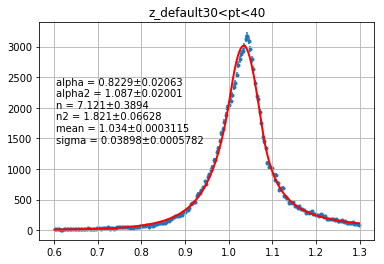

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:70: SmallIntegralWarning: (1.0, 1.0, 0.5832310705237482, 4.0, 0.999, 0.015)


FCN = 71829.3001322 
 TOTAL NCALL = 65 
 NCALLS = 65 
 
 
 EDM = 0.0 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 0.583231 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 0 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0 & & & & & No\\
\hline
1 & alpha2 & 1 & 0 & & & & & No\\
\hline
2 & n & 0.583231 & 0 & & & & & No\\
\hline
3 & n2 & 4 & 0 & & & & & No\\
\hline
4 & mean & 0.999 & 0 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 71829.3001322 
 TOTAL NCALL = 16 
 NCALLS = 16 
 
 
 EDM = 0.0 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 0.583231 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.999 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.015 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 0.583231 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 0.999 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.015 & 0 & & & & & No\\
\hline
\end{tabular}

FCN = 71829.3001322 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 0.0 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 0.583231 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 0 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0 & & & & & No\\
\hline
1 & alpha2 & 1 & 0 & & & & & No\\
\hline
2 & n & 0.583231 & 0 & & & & & No\\
\hline
3 & n2 & 4 & 0 & & & & & No\\
\hline
4 & mean & 0.999 & 0 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 0 & & & & & No\\
\hline
\end{tabular}

20<pt<30
28


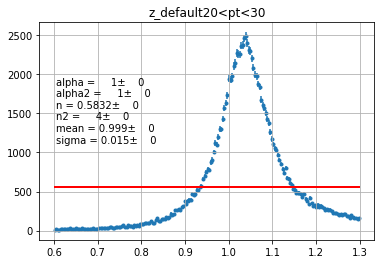

In [21]:
tipe='z_default'
i=0
for para in feat_pt:
  
    if i>25:
        rmin=0.6
        rmax=1.3
    elif: i==28:
            rmin=0.6
            rmax=1.5
    else:
        rmin = 0.9
        rmax = 1.1
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(3):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 0.999, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.9537888950150524, 4.9721091668372495, -6.06040787805923, 1.7218320987743565, 1.0159359433135926, 0.015)


FCN = 1416.64828386 
 TOTAL NCALL = 315 
 NCALLS = 304 
 
 
 EDM = 0.00349373747321 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.13452 
 0.067176 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.21251 
 0.0124748 
 
 
 
 
 No 
 
 
 2 
 n 
 1.08143 
 0.208249 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.57779 
 0.102495 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01612 
 0.000145499 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.13452 & 0.067176 & & & & & No\\
\hline
1 & alpha2 & 5.21251 & 0.0124748 & & & & & No\\
\hline
2 & n & 1.08143 & 0.208249 & & & & & No\\
\hline
3 & n2 & 1.57779 & 0.102495 & & & & & No\\
\hline
4 & mean & 1.01612 & 0.000145499 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 885.979859873 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 1.34478693098e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.13452 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.21251 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.08143 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.57779 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01612 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0106663 
 9.94171e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.13452 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.21251 & 1 & & & & & Yes\\
\hline
2 & n & 1.08143 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.57779 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01612 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0106663 & 9.94171e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 173.130083877 
 TOTAL NCALL = 579 
 NCALLS = 568 
 
 
 EDM = 1.34455396231e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.98311 
 0.0247873 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.23041 
 0.073136 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00031 
 3.44813e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.9952 
 0.842721 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01517 
 0.000138211 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00753128 
 0.0001428 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.98311 & 0.0247873 & & & & & No\\
\hline
1 & alpha2 & 1.23041 & 0.073136 & & & & & No\\
\hline
2 & n & 1.00031 & 3.44813e-06 & & & & & No\\
\hline
3 & n2 & 4.9952 & 0.842721 & & & & & No\\
\hline
4 & mean & 1.01517 & 0.000138211 & & & & & No\\
\hline
5 & $\sigma$ & 0.00753128 & 0.0001428 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


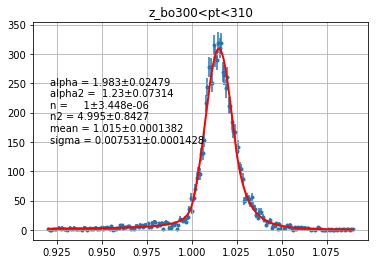

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.7493682787453935, 1.5924214670633874, -10.7147175903819, 1.4631314393485164, 1.008603867932742, 0.015)


FCN = 10007.819111 
 TOTAL NCALL = 731 
 NCALLS = 720 
 
 
 EDM = 2.62167266715e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.6805 
 0.0165353 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.79334 
 0.0637088 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00336 
 6.79222e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.1876 
 0.234924 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00838 
 4.96607e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.6805 & 0.0165353 & & & & & No\\
\hline
1 & alpha2 & 2.79334 & 0.0637088 & & & & & No\\
\hline
2 & n & 1.00336 & 6.79222e-06 & & & & & No\\
\hline
3 & n2 & 1.1876 & 0.234924 & & & & & No\\
\hline
4 & mean & 1.00838 & 4.96607e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

290<pt<300
1


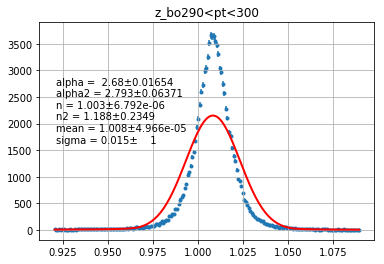

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.147940416064838, 2.254341549741318, 0.5663517776599494, 5.745184006281238, 1.006945358814665, 0.015)


FCN = 7727.60029258 
 TOTAL NCALL = 405 
 NCALLS = 405 
 
 
 EDM = 2.17409734956e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14777 
 0.0265186 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.65906 
 0.0425187 
 
 
 
 
 No 
 
 
 2 
 n 
 1.517 
 0.102369 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.33424 
 0.170432 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00673 
 4.78782e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14777 & 0.0265186 & & & & & No\\
\hline
1 & alpha2 & 2.65906 & 0.0425187 & & & & & No\\
\hline
2 & n & 1.517 & 0.102369 & & & & & No\\
\hline
3 & n2 & 1.33424 & 0.170432 & & & & & No\\
\hline
4 & mean & 1.00673 & 4.78782e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1960.46358826 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 2.09148110185e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14777 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.65906 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.517 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.33424 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00673 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.010962 
 3.05724e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14777 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.65906 & 1 & & & & & Yes\\
\hline
2 & n & 1.517 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.33424 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00673 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.010962 & 3.05724e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 204.197192945 
 TOTAL NCALL = 353 
 NCALLS = 353 
 
 
 EDM = 2.48978738789e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22152 
 0.0190747 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.49215 
 0.0270933 
 
 
 
 
 No 
 
 
 2 
 n 
 3.80737 
 0.140897 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.92612 
 0.273121 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00762 
 4.2552e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00896769 
 6.11117e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22152 & 0.0190747 & & & & & No\\
\hline
1 & alpha2 & 1.49215 & 0.0270933 & & & & & No\\
\hline
2 & n & 3.80737 & 0.140897 & & & & & No\\
\hline
3 & n2 & 4.92612 & 0.273121 & & & & & No\\
\hline
4 & mean & 1.00762 & 4.2552e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00896769 & 6.11117e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


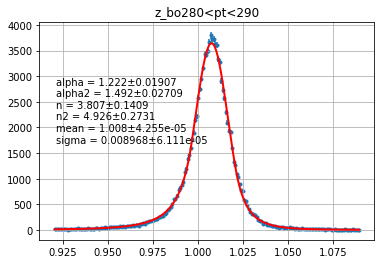

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.1365262145629518, 3.16582946836883, 0.8464900988579356, -4.536423255702175, 1.006537568192061, 0.015)


FCN = 7184.11728423 
 TOTAL NCALL = 515 
 NCALLS = 515 
 
 
 EDM = 5.09160133515e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03584 
 0.02284 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.62733 
 0.0413444 
 
 
 
 
 No 
 
 
 2 
 n 
 1.28827 
 0.074594 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.36728 
 0.167152 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00656 
 4.81891e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03584 & 0.02284 & & & & & No\\
\hline
1 & alpha2 & 2.62733 & 0.0413444 & & & & & No\\
\hline
2 & n & 1.28827 & 0.074594 & & & & & No\\
\hline
3 & n2 & 1.36728 & 0.167152 & & & & & No\\
\hline
4 & mean & 1.00656 & 4.81891e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1936.69960876 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 2.73702417798e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03584 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.62733 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.28827 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.36728 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00656 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.011033 
 3.1962e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03584 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.62733 & 1 & & & & & Yes\\
\hline
2 & n & 1.28827 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.36728 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00656 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.011033 & 3.1962e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 168.822971163 
 TOTAL NCALL = 341 
 NCALLS = 341 
 
 
 EDM = 3.42627786753e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24006 
 0.0181427 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48719 
 0.0260629 
 
 
 
 
 No 
 
 
 2 
 n 
 2.87939 
 0.091209 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.78019 
 0.257132 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00752 
 4.25761e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00905032 
 5.93338e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24006 & 0.0181427 & & & & & No\\
\hline
1 & alpha2 & 1.48719 & 0.0260629 & & & & & No\\
\hline
2 & n & 2.87939 & 0.091209 & & & & & No\\
\hline
3 & n2 & 4.78019 & 0.257132 & & & & & No\\
\hline
4 & mean & 1.00752 & 4.25761e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00905032 & 5.93338e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


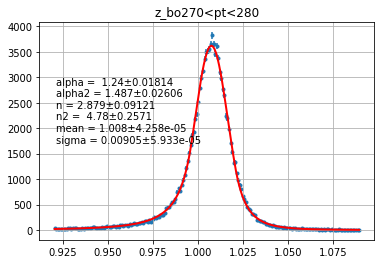

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.1242352662764885, 2.147917284979223, 0.777490240444338, 6.110570081019572, 1.006266234250779, 0.015)


FCN = 6906.51174624 
 TOTAL NCALL = 502 
 NCALLS = 491 
 
 
 EDM = 2.11048849948e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14029 
 0.00882236 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.34088 
 0.042974 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00136 
 2.15888e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.71275 
 0.390936 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 4.69625e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14029 & 0.00882236 & & & & & No\\
\hline
1 & alpha2 & 2.34088 & 0.042974 & & & & & No\\
\hline
2 & n & 1.00136 & 2.15888e-06 & & & & & No\\
\hline
3 & n2 & 2.71275 & 0.390936 & & & & & No\\
\hline
4 & mean & 1.00655 & 4.69625e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1735.06827194 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.52261195893e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14029 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.34088 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00136 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.71275 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00655 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0110606 
 3.20226e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14029 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.34088 & 1 & & & & & Yes\\
\hline
2 & n & 1.00136 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.71275 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00655 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0110606 & 3.20226e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 235.478338113 
 TOTAL NCALL = 450 
 NCALLS = 450 
 
 
 EDM = 8.31677659843e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32588 
 0.0192049 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.55908 
 0.0267736 
 
 
 
 
 No 
 
 
 2 
 n 
 2.63596 
 0.0852441 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.10121 
 0.211538 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00729 
 4.22634e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00932288 
 5.71313e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32588 & 0.0192049 & & & & & No\\
\hline
1 & alpha2 & 1.55908 & 0.0267736 & & & & & No\\
\hline
2 & n & 2.63596 & 0.0852441 & & & & & No\\
\hline
3 & n2 & 4.10121 & 0.211538 & & & & & No\\
\hline
4 & mean & 1.00729 & 4.22634e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00932288 & 5.71313e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


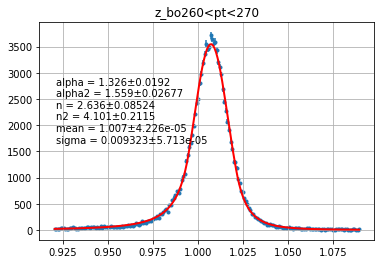

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.9644085458031137, 2.2542127640735647, 0.8790210138170276, 7.2276420629446525, 1.0066804794187143, 0.015)


FCN = 6193.98217436 
 TOTAL NCALL = 520 
 NCALLS = 509 
 
 
 EDM = 3.48782333384e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07939 
 0.00861575 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.64617 
 0.0443569 
 
 
 
 
 No 
 
 
 2 
 n 
 1.0011 
 2.29536e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.23069 
 0.162675 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 4.82649e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07939 & 0.00861575 & & & & & No\\
\hline
1 & alpha2 & 2.64617 & 0.0443569 & & & & & No\\
\hline
2 & n & 1.0011 & 2.29536e-06 & & & & & No\\
\hline
3 & n2 & 1.23069 & 0.162675 & & & & & No\\
\hline
4 & mean & 1.00628 & 4.82649e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

250<pt<260
5


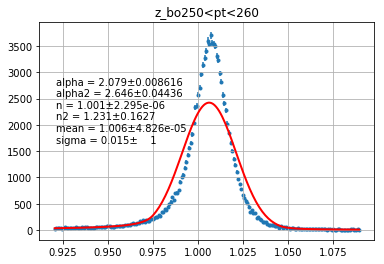

FCN = 5797.43019266 
 TOTAL NCALL = 396 
 NCALLS = 396 
 
 
 EDM = 1.06598947705e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.09555 
 0.0243918 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.57037 
 0.0422884 
 
 
 
 
 No 
 
 
 2 
 n 
 1.09406 
 0.0689477 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.56432 
 0.186235 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00621 
 4.81039e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.09555 & 0.0243918 & & & & & No\\
\hline
1 & alpha2 & 2.57037 & 0.0422884 & & & & & No\\
\hline
2 & n & 1.09406 & 0.0689477 & & & & & No\\
\hline
3 & n2 & 1.56432 & 0.186235 & & & & & No\\
\hline
4 & mean & 1.00621 & 4.81039e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.095553608018972, 2.5703708005719514, 1.094064851924827, 1.5643162633568097, 1.0062106288701547, -0.03758011246616015)


FCN = 1714.58011875 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 6.92168571525e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.09555 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.57037 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.09406 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.56432 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00621 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0114947 
 3.28333e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.09555 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.57037 & 1 & & & & & Yes\\
\hline
2 & n & 1.09406 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.56432 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00621 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0114947 & 3.28333e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 187.803832215 
 TOTAL NCALL = 341 
 NCALLS = 341 
 
 
 EDM = 1.07785789388e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.25748 
 0.0188221 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.44459 
 0.0258203 
 
 
 
 
 No 
 
 
 2 
 n 
 2.93105 
 0.0975284 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.53789 
 0.328667 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00705 
 4.42526e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00948335 
 6.31392e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.25748 & 0.0188221 & & & & & No\\
\hline
1 & alpha2 & 1.44459 & 0.0258203 & & & & & No\\
\hline
2 & n & 2.93105 & 0.0975284 & & & & & No\\
\hline
3 & n2 & 5.53789 & 0.328667 & & & & & No\\
\hline
4 & mean & 1.00705 & 4.42526e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00948335 & 6.31392e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


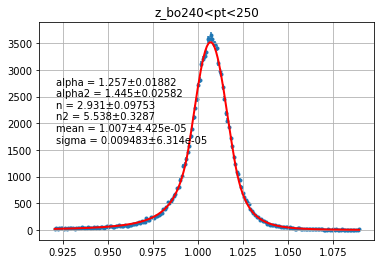

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.111850010411467, 2.105137418446331, 0.9156143131302117, 6.291157716624301, 1.0063161460615893, 0.015)


FCN = 5534.66996452 
 TOTAL NCALL = 279 
 NCALLS = 268 
 
 
 EDM = 11402.7310467 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.08036 
 0.00765069 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.09019 
 0.248257 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00117 
 3.11337e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.44331 
 9.30055 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00635 
 4.79107e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.08036 & 0.00765069 & & & & & No\\
\hline
1 & alpha2 & 2.09019 & 0.248257 & & & & & No\\
\hline
2 & n & 1.00117 & 3.11337e-06 & & & & & No\\
\hline
3 & n2 & 6.44331 & 9.30055 & & & & & No\\
\hline
4 & mean & 1.00635 & 4.79107e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

230<pt<240
7


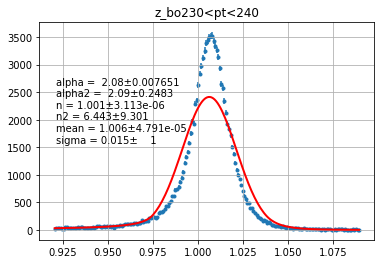

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.1153592834749166, 2.680411452277942, 0.9120433284109005, -1.225186388643566, 1.0065174424218981, 0.015)


FCN = 5072.78761371 
 TOTAL NCALL = 297 
 NCALLS = 286 
 
 
 EDM = 3884.50534193 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.08239 
 0.0138356 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.32937 
 0.280868 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00008 
 0.0365669 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.30332 
 3.52781 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 4.53367e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.08239 & 0.0138356 & & & & & No\\
\hline
1 & alpha2 & 2.32937 & 0.280868 & & & & & No\\
\hline
2 & n & 1.00008 & 0.0365669 & & & & & No\\
\hline
3 & n2 & 3.30332 & 3.52781 & & & & & No\\
\hline
4 & mean & 1.00645 & 4.53367e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1807.60971717 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 8.79481112401e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.08239 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.32937 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00008 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.30332 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00645 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0118226 
 3.38255e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.08239 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.32937 & 1 & & & & & Yes\\
\hline
2 & n & 1.00008 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.30332 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00645 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0118226 & 3.38255e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 203.453607292 
 TOTAL NCALL = 639 
 NCALLS = 639 
 
 
 EDM = 4.79672641415e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26712 
 0.0190399 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38384 
 0.0251245 
 
 
 
 
 No 
 
 
 2 
 n 
 2.70869 
 0.0887339 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.88522 
 0.357908 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00714 
 4.53828e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00963538 
 6.69108e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26712 & 0.0190399 & & & & & No\\
\hline
1 & alpha2 & 1.38384 & 0.0251245 & & & & & No\\
\hline
2 & n & 2.70869 & 0.0887339 & & & & & No\\
\hline
3 & n2 & 5.88522 & 0.357908 & & & & & No\\
\hline
4 & mean & 1.00714 & 4.53828e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00963538 & 6.69108e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


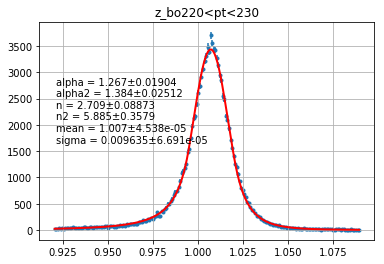

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.0846928437153665, 2.0366764922266936, 0.9646199810012321, 6.270879124657778, 1.0067743754756988, 0.015)


FCN = 4560.31170984 
 TOTAL NCALL = 411 
 NCALLS = 411 
 
 
 EDM = 5.28239268524e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07 
 0.021902 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.43647 
 0.0389942 
 
 
 
 
 No 
 
 
 2 
 n 
 1.01816 
 0.0583859 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.62365 
 0.172233 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00683 
 4.862e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07 & 0.021902 & & & & & No\\
\hline
1 & alpha2 & 2.43647 & 0.0389942 & & & & & No\\
\hline
2 & n & 1.01816 & 0.0583859 & & & & & No\\
\hline
3 & n2 & 1.62365 & 0.172233 & & & & & No\\
\hline
4 & mean & 1.00683 & 4.862e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1431.97182652 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 5.19667326608e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.43647 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.01816 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.62365 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00683 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0118302 
 3.48667e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.43647 & 1 & & & & & Yes\\
\hline
2 & n & 1.01816 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.62365 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00683 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0118302 & 3.48667e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 202.243288401 
 TOTAL NCALL = 459 
 NCALLS = 459 
 
 
 EDM = 2.12748336184e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37308 
 0.0206253 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.3744 
 0.0252056 
 
 
 
 
 No 
 
 
 2 
 n 
 2.37124 
 0.0806772 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.83375 
 0.364175 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00725 
 4.56954e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00995424 
 6.6718e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37308 & 0.0206253 & & & & & No\\
\hline
1 & alpha2 & 1.3744 & 0.0252056 & & & & & No\\
\hline
2 & n & 2.37124 & 0.0806772 & & & & & No\\
\hline
3 & n2 & 5.83375 & 0.364175 & & & & & No\\
\hline
4 & mean & 1.00725 & 4.56954e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00995424 & 6.6718e-05 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


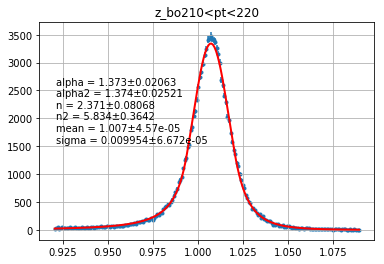

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.0614690419905886, 1.966077773054928, 0.9492967962949795, 6.257450875265008, 1.0070118691954593, 0.015)


FCN = 3881.31709883 
 TOTAL NCALL = 426 
 NCALLS = 426 
 
 
 EDM = 1.78414058671e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04449 
 0.0222111 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.34919 
 0.037514 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00824 
 0.0579438 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.86806 
 0.186449 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.9297e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04449 & 0.0222111 & & & & & No\\
\hline
1 & alpha2 & 2.34919 & 0.037514 & & & & & No\\
\hline
2 & n & 1.00824 & 0.0579438 & & & & & No\\
\hline
3 & n2 & 1.86806 & 0.186449 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.9297e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1329.49298727 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 3.62387371908e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04449 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.34919 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00824 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.86806 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00706 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0120737 
 3.59277e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04449 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.34919 & 1 & & & & & Yes\\
\hline
2 & n & 1.00824 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.86806 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00706 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0120737 & 3.59277e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 183.99174555 
 TOTAL NCALL = 384 
 NCALLS = 384 
 
 
 EDM = 5.3168480871e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32803 
 0.0196258 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.33654 
 0.0243887 
 
 
 
 
 No 
 
 
 2 
 n 
 2.46876 
 0.0821337 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.18439 
 0.398232 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 4.71681e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100771 
 6.88192e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32803 & 0.0196258 & & & & & No\\
\hline
1 & alpha2 & 1.33654 & 0.0243887 & & & & & No\\
\hline
2 & n & 2.46876 & 0.0821337 & & & & & No\\
\hline
3 & n2 & 6.18439 & 0.398232 & & & & & No\\
\hline
4 & mean & 1.00749 & 4.71681e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100771 & 6.88192e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


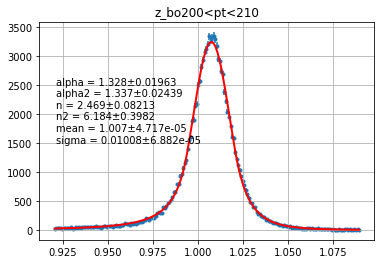

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.9658732133936703, 1.8310066829753415, 0.6737875771461233, 6.030155099388258, 1.0075690122268517, 0.015)


FCN = 3217.05107518 
 TOTAL NCALL = 477 
 NCALLS = 466 
 
 
 EDM = 4.49848424038e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07317 
 0.00753746 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.00733 
 0.0411834 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00064 
 3.8614e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.98523 
 0.69546 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00759 
 4.91092e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07317 & 0.00753746 & & & & & No\\
\hline
1 & alpha2 & 2.00733 & 0.0411834 & & & & & No\\
\hline
2 & n & 1.00064 & 3.8614e-06 & & & & & No\\
\hline
3 & n2 & 3.98523 & 0.69546 & & & & & No\\
\hline
4 & mean & 1.00759 & 4.91092e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1315.02467913 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 5.29415216661e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07317 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.00733 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00064 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.98523 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00759 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124627 
 3.6716e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07317 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.00733 & 1 & & & & & Yes\\
\hline
2 & n & 1.00064 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.98523 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00759 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124627 & 3.6716e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 156.662464452 
 TOTAL NCALL = 468 
 NCALLS = 468 
 
 
 EDM = 1.2859363787e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3333 
 0.0208341 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.23278 
 0.0230304 
 
 
 
 
 No 
 
 
 2 
 n 
 2.53426 
 0.089654 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.64103 
 0.560454 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00776 
 4.95595e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102794 
 7.55543e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3333 & 0.0208341 & & & & & No\\
\hline
1 & alpha2 & 1.23278 & 0.0230304 & & & & & No\\
\hline
2 & n & 2.53426 & 0.089654 & & & & & No\\
\hline
3 & n2 & 7.64103 & 0.560454 & & & & & No\\
\hline
4 & mean & 1.00776 & 4.95595e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102794 & 7.55543e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


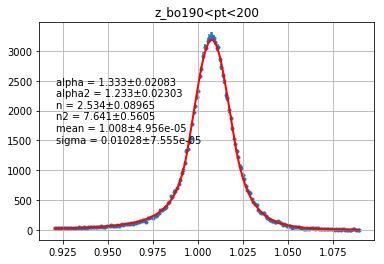

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.98452642839423, 1.8365039439000466, 0.4800502582283055, 5.745371916943939, 1.0077436181449435, 0.015)


FCN = 2536.5320339 
 TOTAL NCALL = 871 
 NCALLS = 871 
 
 
 EDM = 1.98852431934e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00654 
 0.0221677 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.20468 
 0.0324302 
 
 
 
 
 No 
 
 
 2 
 n 
 1.06343 
 0.0594039 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96331 
 0.167781 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00795 
 4.99731e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00654 & 0.0221677 & & & & & No\\
\hline
1 & alpha2 & 2.20468 & 0.0324302 & & & & & No\\
\hline
2 & n & 1.06343 & 0.0594039 & & & & & No\\
\hline
3 & n2 & 1.96331 & 0.167781 & & & & & No\\
\hline
4 & mean & 1.00795 & 4.99731e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1079.89250688 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 6.6270485148e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00654 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.20468 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.06343 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.96331 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00795 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.012732 
 3.81878e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00654 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.20468 & 1 & & & & & Yes\\
\hline
2 & n & 1.06343 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.96331 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00795 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.012732 & 3.81878e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 230.182710959 
 TOTAL NCALL = 340 
 NCALLS = 340 
 
 
 EDM = 7.70257370196e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.34123 
 0.0222472 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25126 
 0.0253291 
 
 
 
 
 No 
 
 
 2 
 n 
 2.50069 
 0.0933897 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.27108 
 0.554492 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00811 
 5.18634e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0106581 
 8.35156e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.34123 & 0.0222472 & & & & & No\\
\hline
1 & alpha2 & 1.25126 & 0.0253291 & & & & & No\\
\hline
2 & n & 2.50069 & 0.0933897 & & & & & No\\
\hline
3 & n2 & 7.27108 & 0.554492 & & & & & No\\
\hline
4 & mean & 1.00811 & 5.18634e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0106581 & 8.35156e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


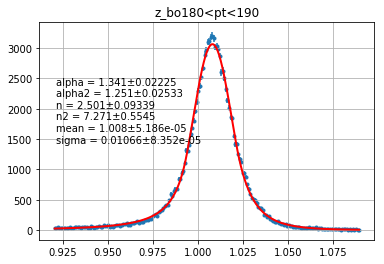

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (2.049737061806289, 2.0241979366930964, 0.8809997814788855, 2.9797820905452905, 1.008218023256839, 0.015)


FCN = 2094.29902231 
 TOTAL NCALL = 443 
 NCALLS = 443 
 
 
 EDM = 3.65340060494e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92674 
 0.0221765 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.09881 
 0.0326401 
 
 
 
 
 No 
 
 
 2 
 n 
 1.25928 
 0.0668841 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.38632 
 0.203021 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00813 
 5.09481e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92674 & 0.0221765 & & & & & No\\
\hline
1 & alpha2 & 2.09881 & 0.0326401 & & & & & No\\
\hline
2 & n & 1.25928 & 0.0668841 & & & & & No\\
\hline
3 & n2 & 2.38632 & 0.203021 & & & & & No\\
\hline
4 & mean & 1.00813 & 5.09481e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1024.94116861 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.69686702205e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92674 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.09881 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.25928 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.38632 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00813 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0130218 
 3.94603e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92674 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.09881 & 1 & & & & & Yes\\
\hline
2 & n & 1.25928 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.38632 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00813 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0130218 & 3.94603e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 213.855145755 
 TOTAL NCALL = 340 
 NCALLS = 340 
 
 
 EDM = 1.05513720352e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28004 
 0.0212992 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19275 
 0.0243454 
 
 
 
 
 No 
 
 
 2 
 n 
 2.78144 
 0.104396 
 
 
 
 
 No 
 
 
 3 
 n2 
 8.61116 
 0.73773 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00826 
 5.40092e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0107828 
 8.83324e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28004 & 0.0212992 & & & & & No\\
\hline
1 & alpha2 & 1.19275 & 0.0243454 & & & & & No\\
\hline
2 & n & 2.78144 & 0.104396 & & & & & No\\
\hline
3 & n2 & 8.61116 & 0.73773 & & & & & No\\
\hline
4 & mean & 1.00826 & 5.40092e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0107828 & 8.83324e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


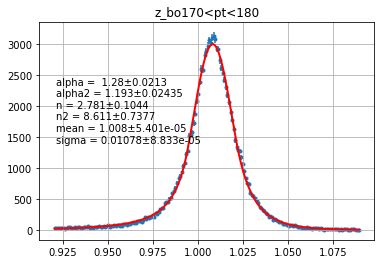

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.8516613867649072, 1.8057713209081623, 0.9000480954781687, 5.953446954844834, 1.0087192635431004, 0.015)


FCN = 1748.05768931 
 TOTAL NCALL = 383 
 NCALLS = 383 
 
 
 EDM = 2.6754503088e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.86436 
 0.0215403 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.076 
 0.0303237 
 
 
 
 
 No 
 
 
 2 
 n 
 1.45134 
 0.0736361 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.30041 
 0.182976 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00867 
 5.10263e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.86436 & 0.0215403 & & & & & No\\
\hline
1 & alpha2 & 2.076 & 0.0303237 & & & & & No\\
\hline
2 & n & 1.45134 & 0.0736361 & & & & & No\\
\hline
3 & n2 & 2.30041 & 0.182976 & & & & & No\\
\hline
4 & mean & 1.00867 & 5.10263e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 844.364084826 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.60191617994e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.86436 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.076 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.45134 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.30041 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00867 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0131898 
 3.94481e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.86436 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.076 & 1 & & & & & Yes\\
\hline
2 & n & 1.45134 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.30041 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00867 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0131898 & 3.94481e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 221.367405049 
 TOTAL NCALL = 284 
 NCALLS = 284 
 
 
 EDM = 1.23804200362e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36837 
 0.0208272 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25689 
 0.0263447 
 
 
 
 
 No 
 
 
 2 
 n 
 2.5477 
 0.0960554 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.74607 
 0.676332 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00868 
 5.46115e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113729 
 8.1992e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36837 & 0.0208272 & & & & & No\\
\hline
1 & alpha2 & 1.25689 & 0.0263447 & & & & & No\\
\hline
2 & n & 2.5477 & 0.0960554 & & & & & No\\
\hline
3 & n2 & 7.74607 & 0.676332 & & & & & No\\
\hline
4 & mean & 1.00868 & 5.46115e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113729 & 8.1992e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


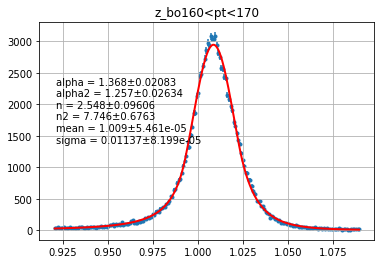

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.6206544575825839, 1.7113980581461232, -0.9064504027296092, 6.272889310007324, 1.0086542446358937, 0.015)


FCN = 1122.86495354 
 TOTAL NCALL = 305 
 NCALLS = 305 
 
 
 EDM = 1.8098633777e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.8061 
 0.0208282 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.89398 
 0.0279541 
 
 
 
 
 No 
 
 
 2 
 n 
 1.4748 
 0.0717397 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.61568 
 0.193003 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0088 
 5.30374e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.8061 & 0.0208282 & & & & & No\\
\hline
1 & alpha2 & 1.89398 & 0.0279541 & & & & & No\\
\hline
2 & n & 1.4748 & 0.0717397 & & & & & No\\
\hline
3 & n2 & 2.61568 & 0.193003 & & & & & No\\
\hline
4 & mean & 1.0088 & 5.30374e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 644.936745769 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.39944587679e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.8061 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.89398 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.4748 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.61568 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0088 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0136233 
 4.21847e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.8061 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.89398 & 1 & & & & & Yes\\
\hline
2 & n & 1.4748 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.61568 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0088 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0136233 & 4.21847e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 194.221178393 
 TOTAL NCALL = 295 
 NCALLS = 295 
 
 
 EDM = 4.82218695971e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33757 
 0.0213203 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.20095 
 0.0240845 
 
 
 
 
 No 
 
 
 2 
 n 
 2.59736 
 0.102302 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.73852 
 0.661999 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00872 
 5.77794e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0117689 
 8.75741e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33757 & 0.0213203 & & & & & No\\
\hline
1 & alpha2 & 1.20095 & 0.0240845 & & & & & No\\
\hline
2 & n & 2.59736 & 0.102302 & & & & & No\\
\hline
3 & n2 & 7.73852 & 0.661999 & & & & & No\\
\hline
4 & mean & 1.00872 & 5.77794e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0117689 & 8.75741e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


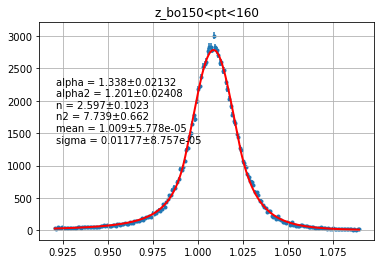

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.5317258482839704, 1.5834002040122708, -0.2382407351277589, 6.231384692395695, 1.0087730732808737, 0.015)


FCN = 845.44937758 
 TOTAL NCALL = 328 
 NCALLS = 328 
 
 
 EDM = 5.12565597971e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74603 
 0.0213723 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.70107 
 0.024655 
 
 
 
 
 No 
 
 
 2 
 n 
 1.62754 
 0.0804273 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.33145 
 0.234232 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 5.53438e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74603 & 0.0213723 & & & & & No\\
\hline
1 & alpha2 & 1.70107 & 0.024655 & & & & & No\\
\hline
2 & n & 1.62754 & 0.0804273 & & & & & No\\
\hline
3 & n2 & 3.33145 & 0.234232 & & & & & No\\
\hline
4 & mean & 1.00883 & 5.53438e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 533.622905765 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 5.19041725886e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74603 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.70107 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.62754 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.33145 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00883 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0138537 
 4.38021e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74603 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.70107 & 1 & & & & & Yes\\
\hline
2 & n & 1.62754 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.33145 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00883 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0138537 & 4.38021e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 171.145225739 
 TOTAL NCALL = 281 
 NCALLS = 281 
 
 
 EDM = 1.60695005764e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32164 
 0.0224018 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16879 
 0.024642 
 
 
 
 
 No 
 
 
 2 
 n 
 2.72284 
 0.11516 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.46297 
 0.65625 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00871 
 6.12911e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0121031 
 9.59044e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32164 & 0.0224018 & & & & & No\\
\hline
1 & alpha2 & 1.16879 & 0.024642 & & & & & No\\
\hline
2 & n & 2.72284 & 0.11516 & & & & & No\\
\hline
3 & n2 & 7.46297 & 0.65625 & & & & & No\\
\hline
4 & mean & 1.00871 & 6.12911e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0121031 & 9.59044e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


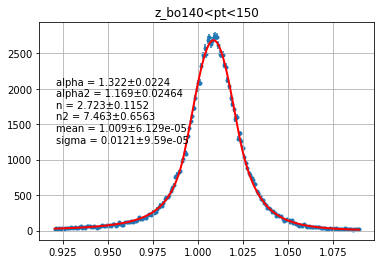

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.5111584563585978, 1.4396679804700303, -0.3071177397094145, 6.044820144335308, 1.0087867105450918, 0.015)


FCN = 536.073152562 
 TOTAL NCALL = 289 
 NCALLS = 289 
 
 
 EDM = 1.71020703727e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.68651 
 0.020269 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.5387 
 0.0226987 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70316 
 0.0798229 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.64491 
 0.25194 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00891 
 5.7976e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.68651 & 0.020269 & & & & & No\\
\hline
1 & alpha2 & 1.5387 & 0.0226987 & & & & & No\\
\hline
2 & n & 1.70316 & 0.0798229 & & & & & No\\
\hline
3 & n2 & 3.64491 & 0.25194 & & & & & No\\
\hline
4 & mean & 1.00891 & 5.7976e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 368.914319931 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 8.98933233694e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.68651 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.5387 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.70316 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.64491 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00891 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.014127 
 4.61539e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.68651 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.5387 & 1 & & & & & Yes\\
\hline
2 & n & 1.70316 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.64491 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00891 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.014127 & 4.61539e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 146.983015212 
 TOTAL NCALL = 258 
 NCALLS = 258 
 
 
 EDM = 7.54821168937e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39278 
 0.0219638 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13666 
 0.0242042 
 
 
 
 
 No 
 
 
 2 
 n 
 2.38218 
 0.100017 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.11452 
 0.644155 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00863 
 6.57906e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127146 
 9.50059e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39278 & 0.0219638 & & & & & No\\
\hline
1 & alpha2 & 1.13666 & 0.0242042 & & & & & No\\
\hline
2 & n & 2.38218 & 0.100017 & & & & & No\\
\hline
3 & n2 & 7.11452 & 0.644155 & & & & & No\\
\hline
4 & mean & 1.00863 & 6.57906e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127146 & 9.50059e-05 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


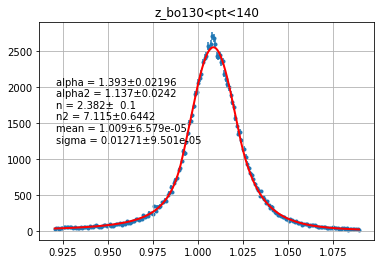

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.4221462232022701, 1.3319483323587735, 0.7658525739744091, 7.400511485595883, 1.0092210690961776, 0.015)


FCN = 336.8706706 
 TOTAL NCALL = 264 
 NCALLS = 264 
 
 
 EDM = 4.43313085898e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5702 
 0.0202681 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.31961 
 0.0209314 
 
 
 
 
 No 
 
 
 2 
 n 
 1.93369 
 0.0909089 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.13409 
 0.566262 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 6.39742e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5702 & 0.0202681 & & & & & No\\
\hline
1 & alpha2 & 1.31961 & 0.0209314 & & & & & No\\
\hline
2 & n & 1.93369 & 0.0909089 & & & & & No\\
\hline
3 & n2 & 6.13409 & 0.566262 & & & & & No\\
\hline
4 & mean & 1.00934 & 6.39742e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 302.47822092 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.23101507603e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5702 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.31961 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.93369 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.13409 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00934 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0145953 
 4.80231e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5702 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.31961 & 1 & & & & & Yes\\
\hline
2 & n & 1.93369 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.13409 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00934 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0145953 & 4.80231e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 213.628900903 
 TOTAL NCALL = 284 
 NCALLS = 284 
 
 
 EDM = 3.31380326275e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35106 
 0.0240926 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.02523 
 0.026633 
 
 
 
 
 No 
 
 
 2 
 n 
 2.51139 
 0.1151 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.3572 
 2.62957 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00899 
 7.95498e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0133353 
 0.000125706 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35106 & 0.0240926 & & & & & No\\
\hline
1 & alpha2 & 1.02523 & 0.026633 & & & & & No\\
\hline
2 & n & 2.51139 & 0.1151 & & & & & No\\
\hline
3 & n2 & 14.3572 & 2.62957 & & & & & No\\
\hline
4 & mean & 1.00899 & 7.95498e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0133353 & 0.000125706 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


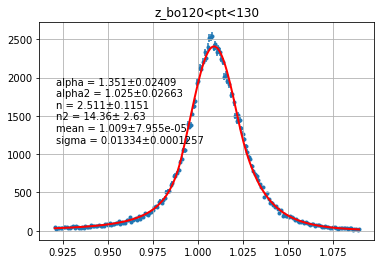

FCN = 199.667497958 
 TOTAL NCALL = 296 
 NCALLS = 296 
 
 
 EDM = 4.57010852973e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.494 
 0.0190739 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.17373 
 0.0187781 
 
 
 
 
 No 
 
 
 2 
 n 
 2.15803 
 0.098939 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.8717 
 0.855071 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00922 
 6.8057e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.494 & 0.0190739 & & & & & No\\
\hline
1 & alpha2 & 1.17373 & 0.0187781 & & & & & No\\
\hline
2 & n & 2.15803 & 0.098939 & & & & & No\\
\hline
3 & n2 & 7.8717 & 0.855071 & & & & & No\\
\hline
4 & mean & 1.00922 & 6.8057e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 190.942809677 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 3.87879361858e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.494 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.17373 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.15803 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.8717 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00922 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.014794 
 4.89455e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.494 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.17373 & 1 & & & & & Yes\\
\hline
2 & n & 2.15803 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.8717 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00922 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.014794 & 4.89455e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 162.82471084 
 TOTAL NCALL = 249 
 NCALLS = 249 
 
 
 EDM = 4.10765615933e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38656 
 0.0228824 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01647 
 0.0238417 
 
 
 
 
 No 
 
 
 2 
 n 
 2.42863 
 0.113634 
 
 
 
 
 No 
 
 
 3 
 n2 
 13.5644 
 2.36433 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00895 
 8.02491e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0140643 
 0.000114528 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38656 & 0.0228824 & & & & & No\\
\hline
1 & alpha2 & 1.01647 & 0.0238417 & & & & & No\\
\hline
2 & n & 2.42863 & 0.113634 & & & & & No\\
\hline
3 & n2 & 13.5644 & 2.36433 & & & & & No\\
\hline
4 & mean & 1.00895 & 8.02491e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0140643 & 0.000114528 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


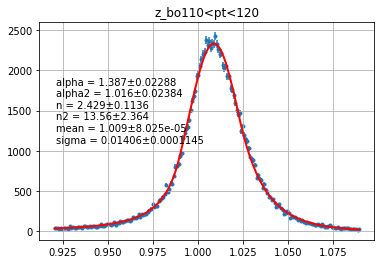

FCN = 13995.4157521 
 TOTAL NCALL = 76 
 NCALLS = 65 
 
 
 EDM = 17474.266955 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00286458 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0472727 
 
 
 
 
 No 
 
 
 2 
 n 
 6 
 0.0464024 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 3.80544 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 0.000146123 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00286458 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0472727 & & & & & No\\
\hline
2 & n & 6 & 0.0464024 & & & & & No\\
\hline
3 & n2 & 4 & 3.80544 & & & & & No\\
\hline
4 & mean & 0.999 & 0.000146123 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.999, -0.0666931569844372)


FCN = 13919.3847072 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 7.28063753604e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.999 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0157308 
 6.10471e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 6 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 0.999 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0157308 & 6.10471e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 13919.3847072 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 37315.7150215 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00364136 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.067133 
 
 
 
 
 No 
 
 
 2 
 n 
 6 
 0.076453 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.81094 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999 
 7.46032e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0157308 
 7.3477e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00364136 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.067133 & & & & & No\\
\hline
2 & n & 6 & 0.076453 & & & & & No\\
\hline
3 & n2 & 4 & 1.81094 & & & & & No\\
\hline
4 & mean & 0.999 & 7.46032e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0157308 & 7.3477e-05 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


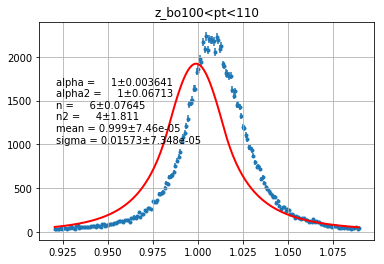

FCN = 154.696783433 
 TOTAL NCALL = 350 
 NCALLS = 350 
 
 
 EDM = 3.82886262011e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18142 
 0.018099 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.872518 
 0.013882 
 
 
 
 
 No 
 
 
 2 
 n 
 4.18576 
 0.2658 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.503 
 2.69731 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00862 
 8.88597e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18142 & 0.018099 & & & & & No\\
\hline
1 & alpha2 & 0.872518 & 0.013882 & & & & & No\\
\hline
2 & n & 4.18576 & 0.2658 & & & & & No\\
\hline
3 & n2 & 14.503 & 2.69731 & & & & & No\\
\hline
4 & mean & 1.00862 & 8.88597e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 154.417348938 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 1.03818674184e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18142 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.872518 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.18576 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.503 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00862 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150395 
 5.25694e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18142 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.872518 & 1 & & & & & Yes\\
\hline
2 & n & 4.18576 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.503 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00862 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150395 & 5.25694e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 152.069897774 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 4.28855428223e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2209 
 0.0250763 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.914255 
 0.0236997 
 
 
 
 
 No 
 
 
 2 
 n 
 3.97851 
 0.264354 
 
 
 
 
 No 
 
 
 3 
 n2 
 11.8462 
 2.13958 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00873 
 9.82044e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0153631 
 0.000155637 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2209 & 0.0250763 & & & & & No\\
\hline
1 & alpha2 & 0.914255 & 0.0236997 & & & & & No\\
\hline
2 & n & 3.97851 & 0.264354 & & & & & No\\
\hline
3 & n2 & 11.8462 & 2.13958 & & & & & No\\
\hline
4 & mean & 1.00873 & 9.82044e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0153631 & 0.000155637 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


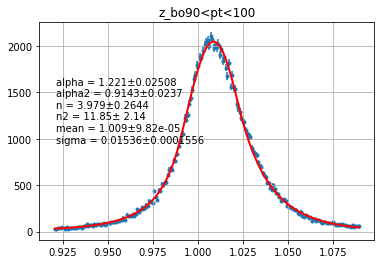

FCN = 192.626545594 
 TOTAL NCALL = 502 
 NCALLS = 491 
 
 
 EDM = 0.285562636931 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.10326 
 0.0175761 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.717303 
 0.00591911 
 
 
 
 
 No 
 
 
 2 
 n 
 4.34206 
 0.286435 
 
 
 
 
 No 
 
 
 3 
 n2 
 134.779 
 88.5038 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00783 
 9.60573e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.10326 & 0.0175761 & & & & & No\\
\hline
1 & alpha2 & 0.717303 & 0.00591911 & & & & & No\\
\hline
2 & n & 4.34206 & 0.286435 & & & & & No\\
\hline
3 & n2 & 134.779 & 88.5038 & & & & & No\\
\hline
4 & mean & 1.00783 & 9.60573e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 191.117477964 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 3.52351441587e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.10326 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.717303 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.34206 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 134.779 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00783 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150938 
 5.42212e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.10326 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.717303 & 1 & & & & & Yes\\
\hline
2 & n & 4.34206 & 1 & & & & & Yes\\
\hline
3 & n2 & 134.779 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00783 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150938 & 5.42212e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 167.236248093 
 TOTAL NCALL = 306 
 NCALLS = 306 
 
 
 EDM = 5.81846226547e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.25696 
 0.0275817 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.822901 
 0.0214776 
 
 
 
 
 No 
 
 
 2 
 n 
 3.47365 
 0.246139 
 
 
 
 
 No 
 
 
 3 
 n2 
 30.656 
 14.3868 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00823 
 0.000112255 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0163661 
 0.000172228 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.25696 & 0.0275817 & & & & & No\\
\hline
1 & alpha2 & 0.822901 & 0.0214776 & & & & & No\\
\hline
2 & n & 3.47365 & 0.246139 & & & & & No\\
\hline
3 & n2 & 30.656 & 14.3868 & & & & & No\\
\hline
4 & mean & 1.00823 & 0.000112255 & & & & & No\\
\hline
5 & $\sigma$ & 0.0163661 & 0.000172228 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


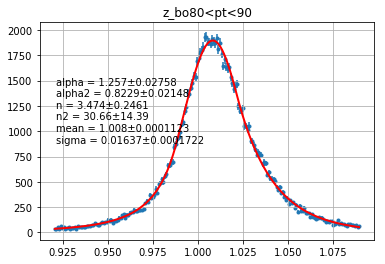

FCN = 309.425749 
 TOTAL NCALL = 488 
 NCALLS = 477 
 
 
 EDM = 0.335127049709 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.766635 
 0.00431063 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.613131 
 0.00450996 
 
 
 
 
 No 
 
 
 2 
 n 
 113.77 
 6.0157 
 
 
 
 
 No 
 
 
 3 
 n2 
 116.809 
 33.1263 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00893 
 0.000109685 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.766635 & 0.00431063 & & & & & No\\
\hline
1 & alpha2 & 0.613131 & 0.00450996 & & & & & No\\
\hline
2 & n & 113.77 & 6.0157 & & & & & No\\
\hline
3 & n2 & 116.809 & 33.1263 & & & & & No\\
\hline
4 & mean & 1.00893 & 0.000109685 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 308.664945024 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 7.10120520699e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.766635 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.613131 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 113.77 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 116.809 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00893 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150671 
 5.45686e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.766635 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.613131 & 1 & & & & & Yes\\
\hline
2 & n & 113.77 & 1 & & & & & Yes\\
\hline
3 & n2 & 116.809 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00893 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150671 & 5.45686e-05 & & & & & No\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:71: SmallIntegralWarning: (0.7666354532217908, 0.6131308932354985, -7.6470060944561595, 116.80867206450377, 1.0089265704127472, 0.015067135285179879)


FCN = 270.372169166 
 TOTAL NCALL = 167 
 NCALLS = 156 
 
 
 EDM = 23.8955655991 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.831025 
 0.0176509 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.656776 
 0.0149265 
 
 
 
 
 No 
 
 
 2 
 n 
 23.0612 
 5.358 
 
 
 
 
 No 
 
 
 3 
 n2 
 127.986 
 44.8461 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00907 
 0.000130991 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0159462 
 0.000290319 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.831025 & 0.0176509 & & & & & No\\
\hline
1 & alpha2 & 0.656776 & 0.0149265 & & & & & No\\
\hline
2 & n & 23.0612 & 5.358 & & & & & No\\
\hline
3 & n2 & 127.986 & 44.8461 & & & & & No\\
\hline
4 & mean & 1.00907 & 0.000130991 & & & & & No\\
\hline
5 & $\sigma$ & 0.0159462 & 0.000290319 & & & & & No\\
\hline
\end{tabular}

In [ ]:
tipe='z_bo'
i=0
for para in feat_pt:
    if i>25:
        rmin=0.6
        rmax=1.4
        
    else:
        rmin = 0.92
        rmax = 1.09
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(3):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 0.999, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        elif j==1:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
            if i==1 or i==5 or i==7:
                break
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()

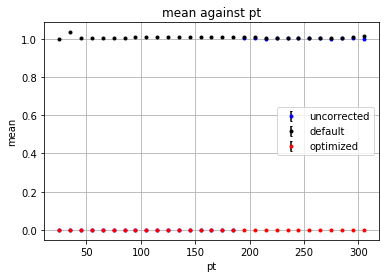

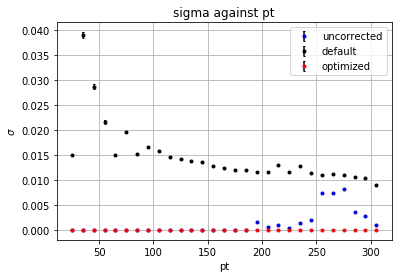

In [22]:
plt.figure()
plt.errorbar(pt,mean_pt_un, yerr=mean_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_de, yerr=mean_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_bo, yerr=mean_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against pt')
plt.xlabel('pt')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_pt'+'.png'))
plt.show()

plt.figure()
plt.errorbar(pt,sigma_pt_un, yerr=sigma_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_de, yerr=sigma_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_bo, yerr=sigma_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('sigma against pt')
plt.xlabel('pt')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_pt'+'.png'))
plt.show()